In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.aug_pipelines import medium_aug
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from pipeline_config import (
    dataloaders_conf,
    aug_config,
    train_conf,
    model_config, 
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Prepare train, validation and test data

In [7]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 702.13it/s]
100%|██████████| 720/720 [00:07<00:00, 94.12it/s] 
8280it [00:00, 252779.26it/s]
7920it [00:00, 245967.45it/s]
720it [00:00, 869.34it/s]
100%|██████████| 720/720 [00:07<00:00, 94.65it/s] 
8280it [00:00, 243755.61it/s]
720it [00:00, 848.30it/s]
100%|██████████| 720/720 [00:07<00:00, 94.24it/s] 
8280it [00:00, 227900.44it/s]
700it [00:00, 814.38it/s]
100%|██████████| 700/700 [00:06<00:00, 100.28it/s]
8280it [00:00, 250121.26it/s]
509it [00:00, 1203.79it/s]
100%|██████████| 509/509 [00:02<00:00, 199.79it/s]
3664it [00:00, 246486.33it/s]
700it [00:00, 850.96it/s]
100%|██████████| 700/700 [00:06<00:00, 100.44it/s]
8280it [00:00, 250523.62it/s]
700it [00:00, 836.33it/s]
100%|██████████| 700/700 [00:06<00:00, 100.43it/s]
8280it [00:00, 77345.01it/s]
710it [00:01, 402.26it/s]
100%|██████████| 710/710 [00:07<00:00, 101.00it/s]
8280it [00:00, 247905.53it/s]
710it [00:01, 403.70it/s]
100%|██████████| 710/710 [00:07<00:00, 97.86it/s] 
8280it [00:00, 240934.89it/s]
710it [

In [8]:
len(data_train), len(data_val), len(data_test)

(8280, 7920, 11)

In [9]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [10]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [11]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [12]:
device = 'cuda:0'

In [13]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [ ]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

## Dump experiment results

In [14]:
import pickle
import json

In [16]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'wb') as f:
#     pickle.dump(results, f)

In [15]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'rb') as f:
    results = pickle.load(f)

In [17]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))
# model = model.to('cpu').to(device)

<All keys matched successfully>

## Train and validation losses

In [18]:
from itertools import chain

In [19]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [20]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

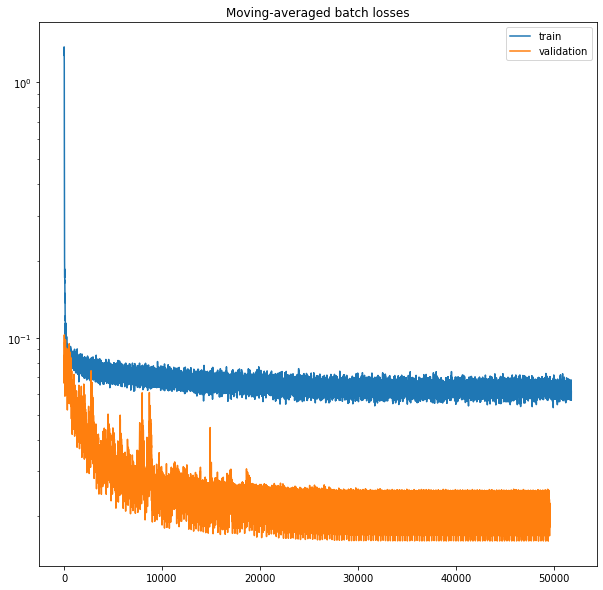

In [21]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [22]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

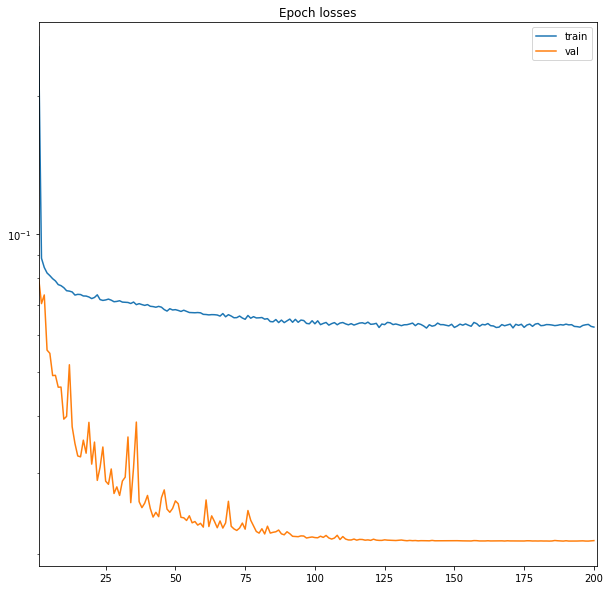

In [23]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Predicted samples

In [24]:
import os

In [25]:
import torch

In [26]:
from visualization_utils import output_to_binary, plot_sample

In [27]:
threshold = 0.5
to_plot = 10
# device = model_conf['device']

carb96558


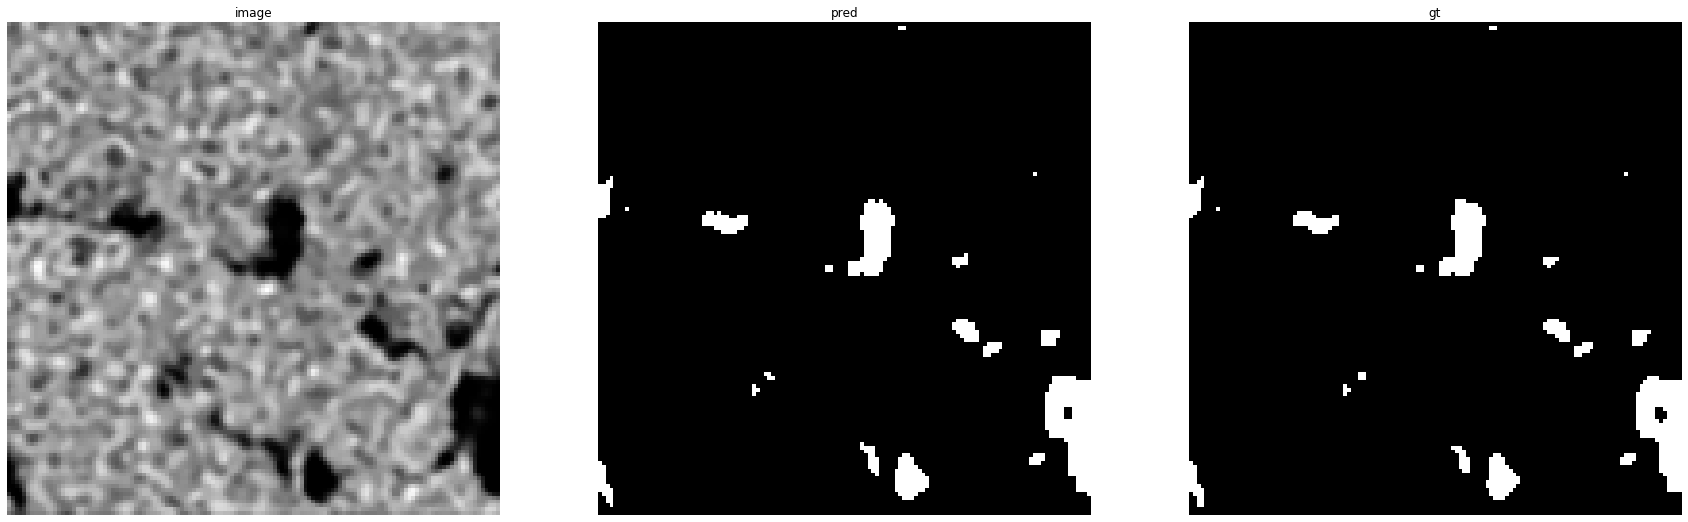

accuracy    : 0.9976806640625
precision   : 0.9542203147353362
recall      : 0.9910846953937593
f1          : 0.9723032069970845
pr_auc      : 0.9982344714463269
iou         : 0.9460992907801419


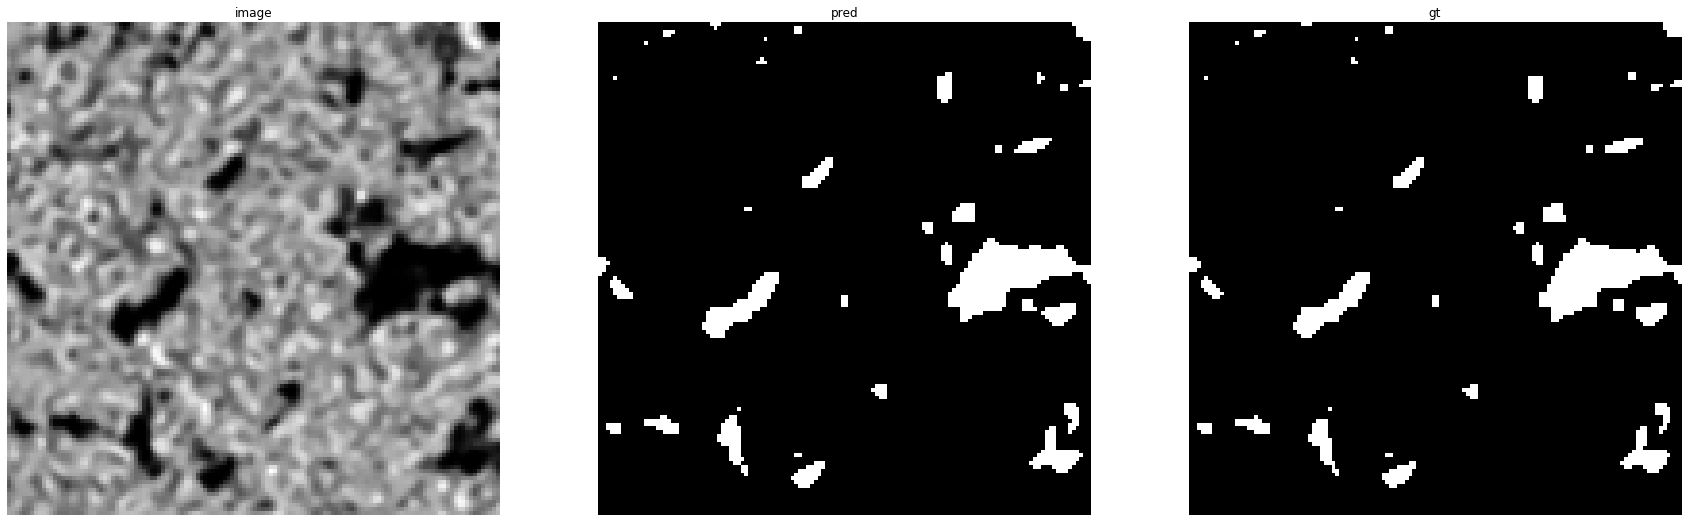

accuracy    : 0.9964599609375
precision   : 0.9523809523809523
recall      : 0.9908998988877654
f1          : 0.9712586719524281
pr_auc      : 0.9972182864711095
iou         : 0.9441233140655106


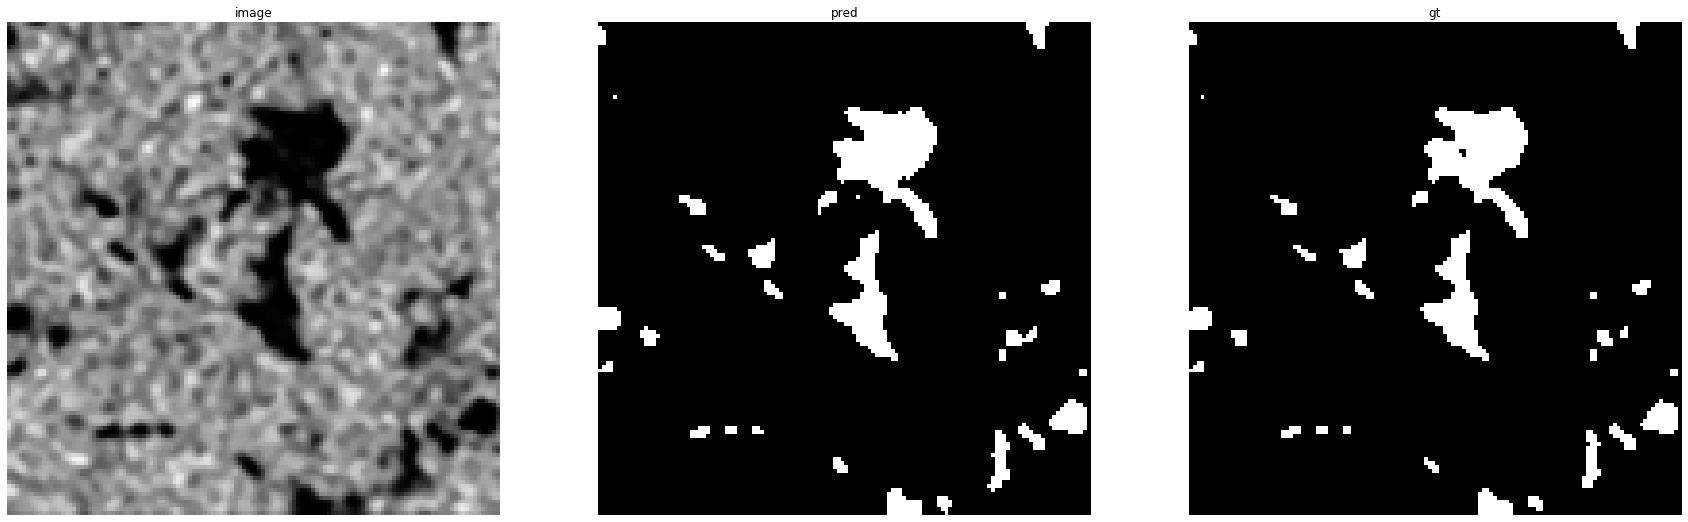

accuracy    : 0.99560546875
precision   : 0.9457682826622843
recall      : 0.9948141745894555
f1          : 0.9696714406065712
pr_auc      : 0.998555529372142
iou         : 0.9411283728536386


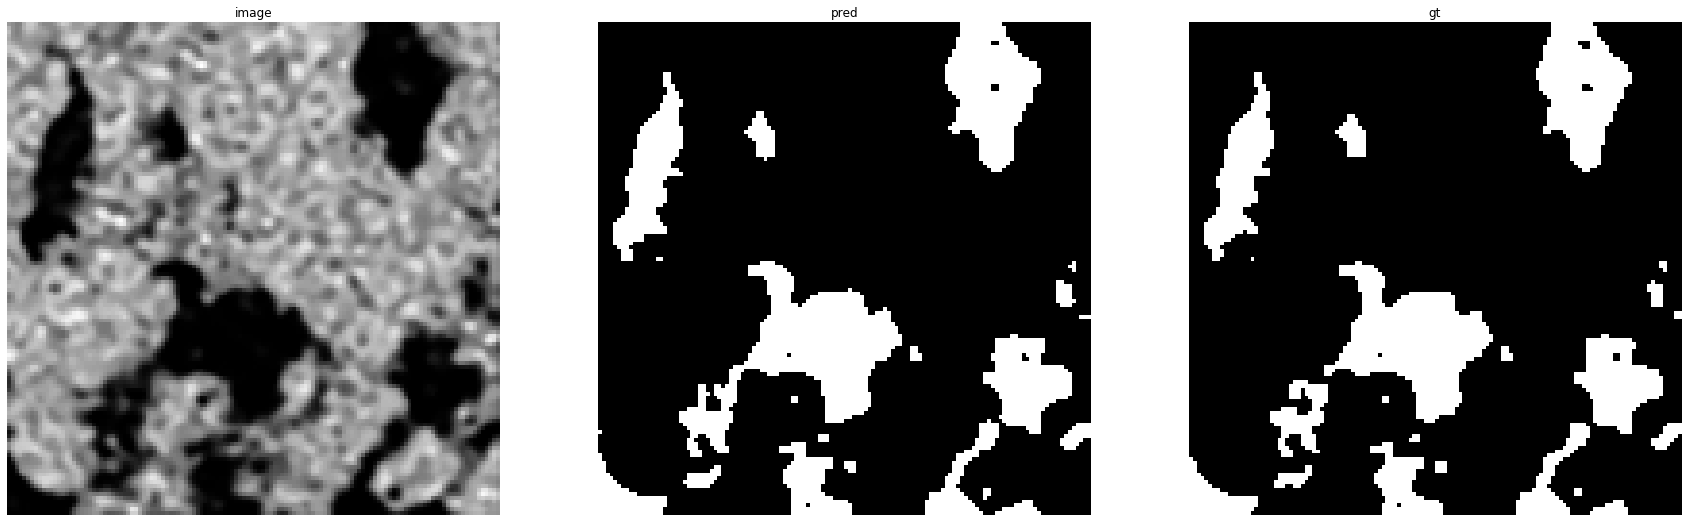

accuracy    : 0.99151611328125
precision   : 0.9613788700925631
recall      : 0.994059405940594
f1          : 0.9774460490021094
pr_auc      : 0.9989019558831813
iou         : 0.9558870199936528


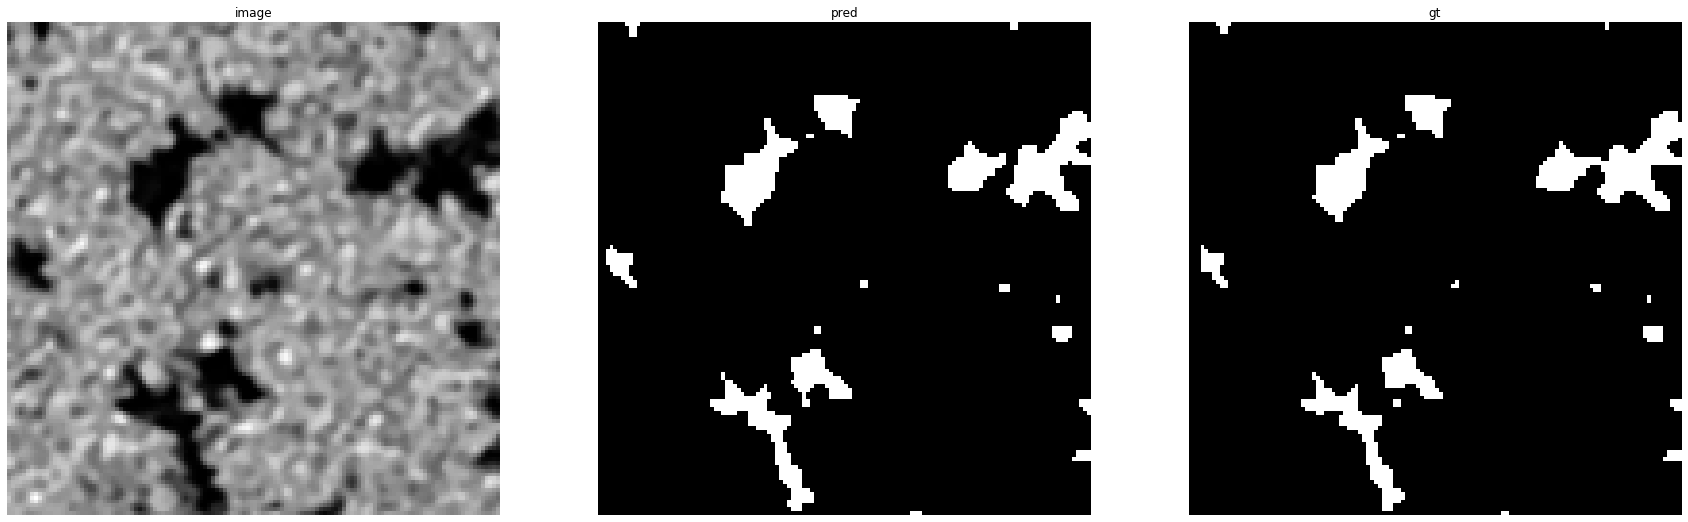

accuracy    : 0.9954833984375
precision   : 0.9499151103565365
recall      : 0.9867724867724867
f1          : 0.9679930795847751
pr_auc      : 0.9973962240375485
iou         : 0.9379715004191115


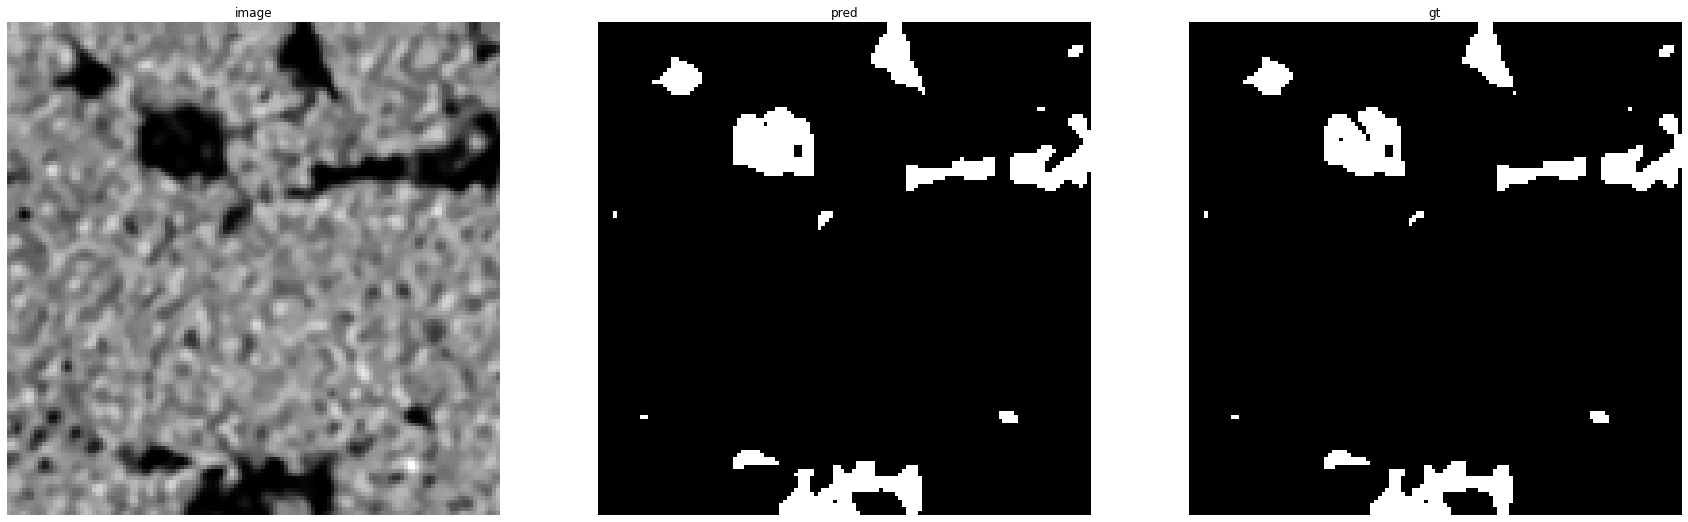

accuracy    : 0.99615478515625
precision   : 0.950210970464135
recall      : 0.9964601769911504
f1          : 0.9727861771058315
pr_auc      : 0.9976488447914013
iou         : 0.9470142977291842


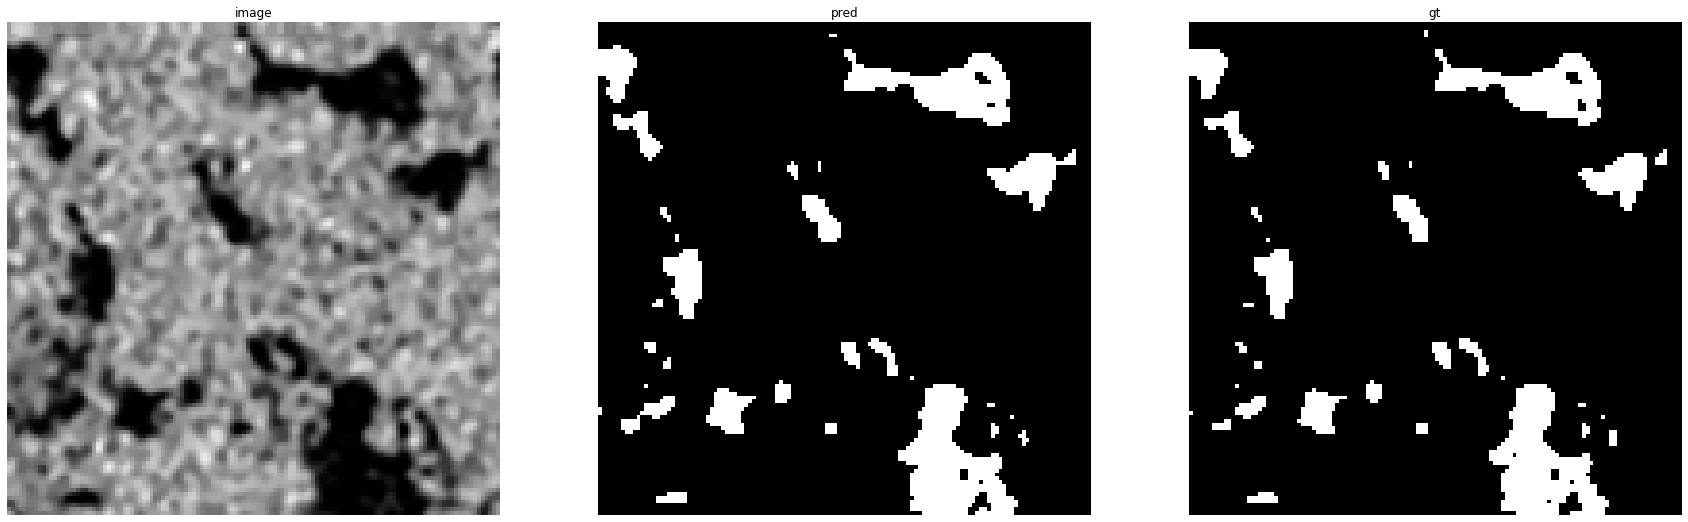

accuracy    : 0.99420166015625
precision   : 0.9536312849162011
recall      : 0.9930191972076788
f1          : 0.9729267597606156
pr_auc      : 0.9980049539722573
iou         : 0.9472807991120976


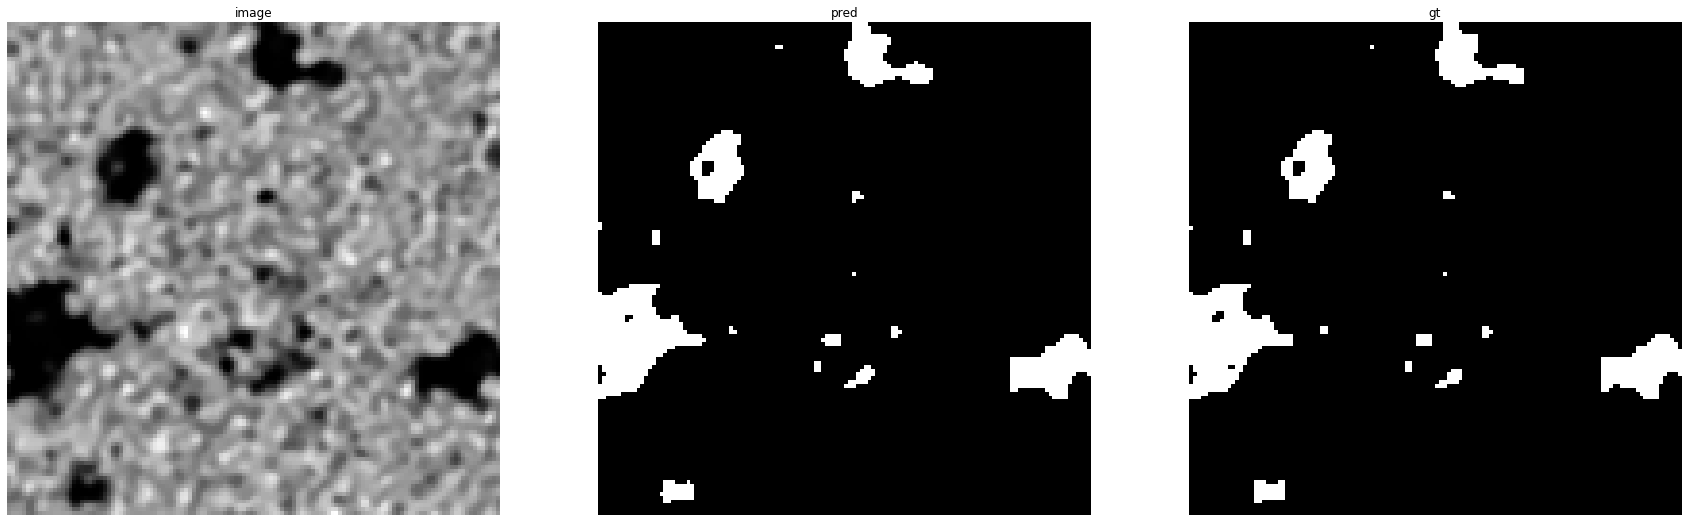

accuracy    : 0.99755859375
precision   : 0.970357454228422
recall      : 0.9946380697050938
f1          : 0.9823477493380407
pr_auc      : 0.9995106709699515
iou         : 0.9653078924544666


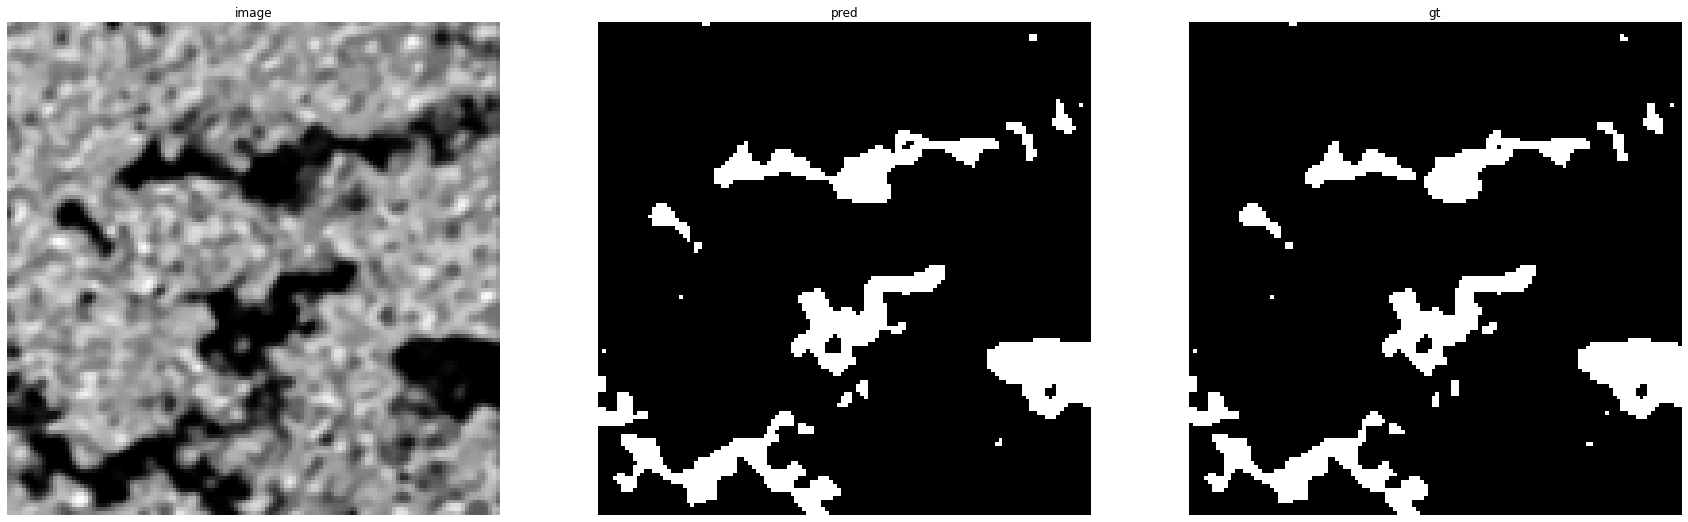

accuracy    : 0.99322509765625
precision   : 0.9550731953558809
recall      : 0.9885057471264368
f1          : 0.9715019255455714
pr_auc      : 0.998253798160082
iou         : 0.9445831253120319


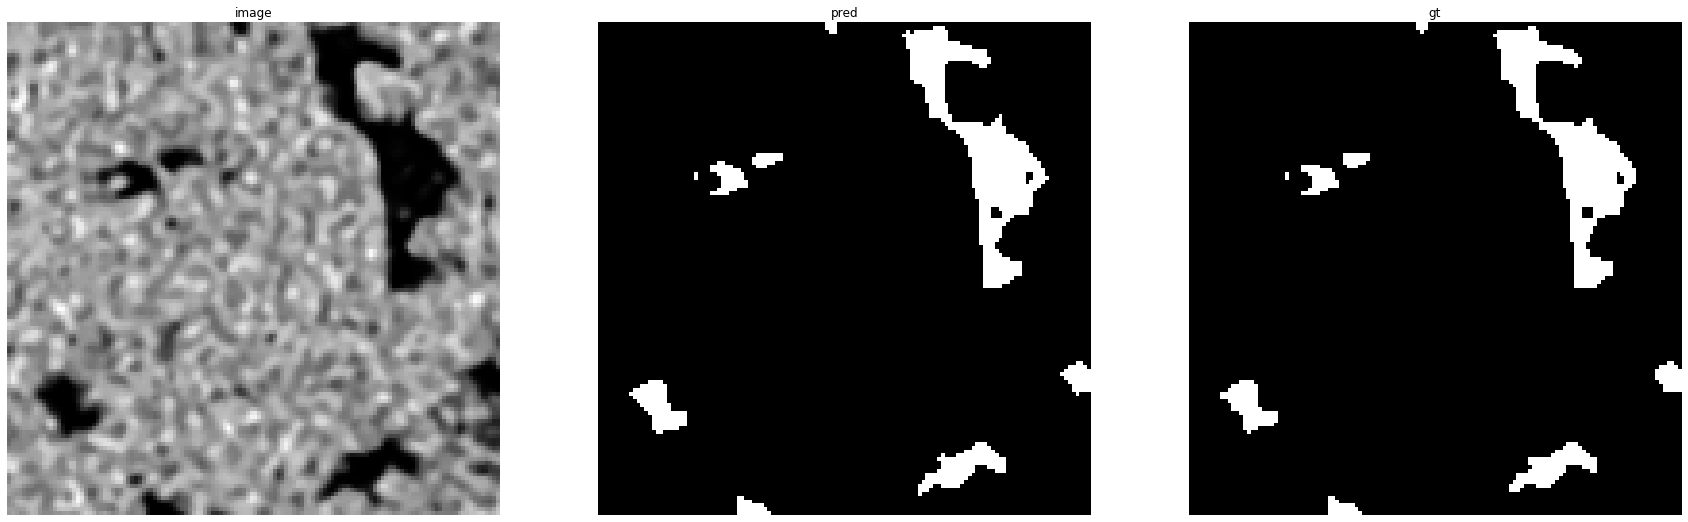

accuracy    : 0.9971923828125
precision   : 0.9677980852915579
recall      : 0.991971454058876
f1          : 0.9797356828193833
pr_auc      : 0.9990877383285496
iou         : 0.9602763385146805
carb71


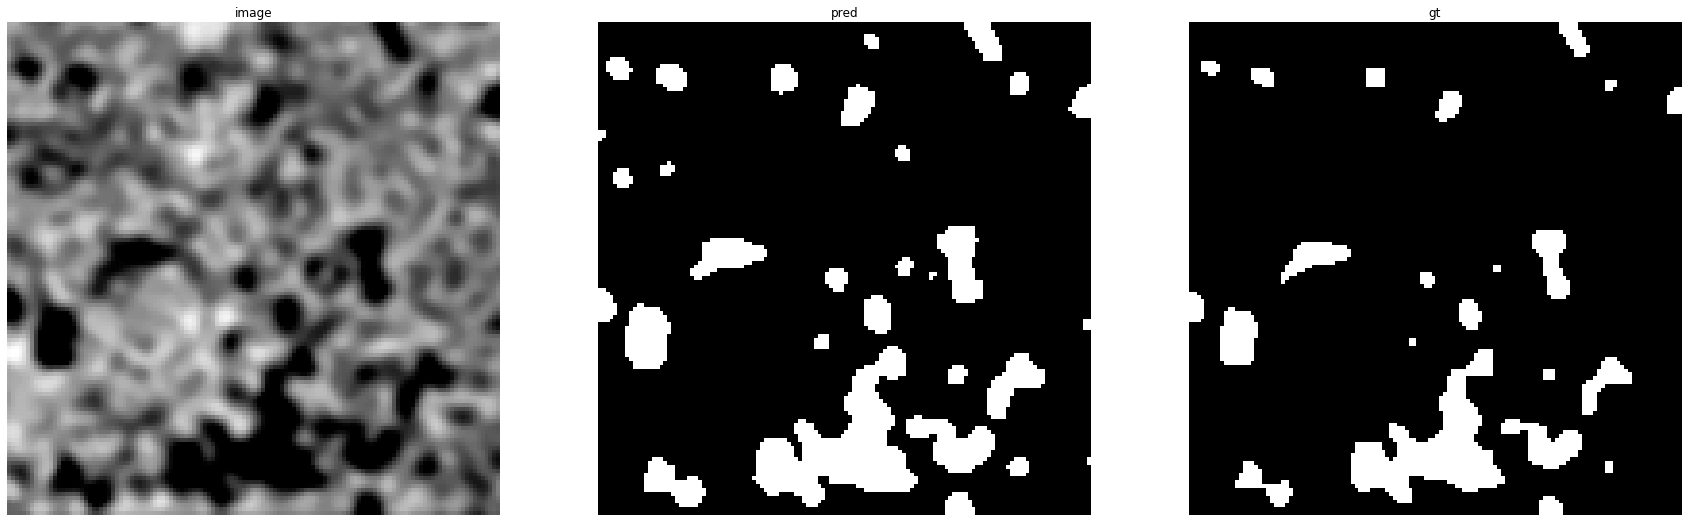

accuracy    : 0.95635986328125
precision   : 0.6897302001740644
recall      : 0.9987397605545053
f1          : 0.8159588159588159
pr_auc      : 0.9930699581610438
iou         : 0.6891304347826087


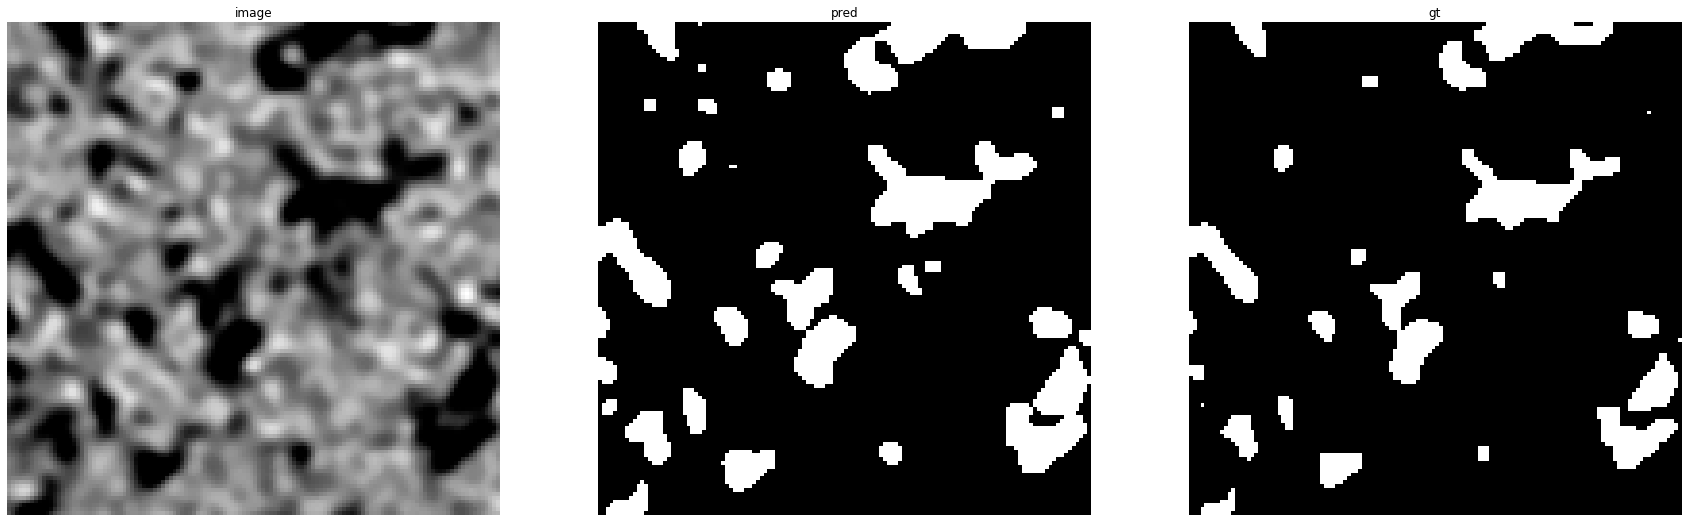

accuracy    : 0.9510498046875
precision   : 0.6964759378552482
recall      : 0.9994562262098967
f1          : 0.8209021884769987
pr_auc      : 0.9918168607702438
iou         : 0.6962121212121212


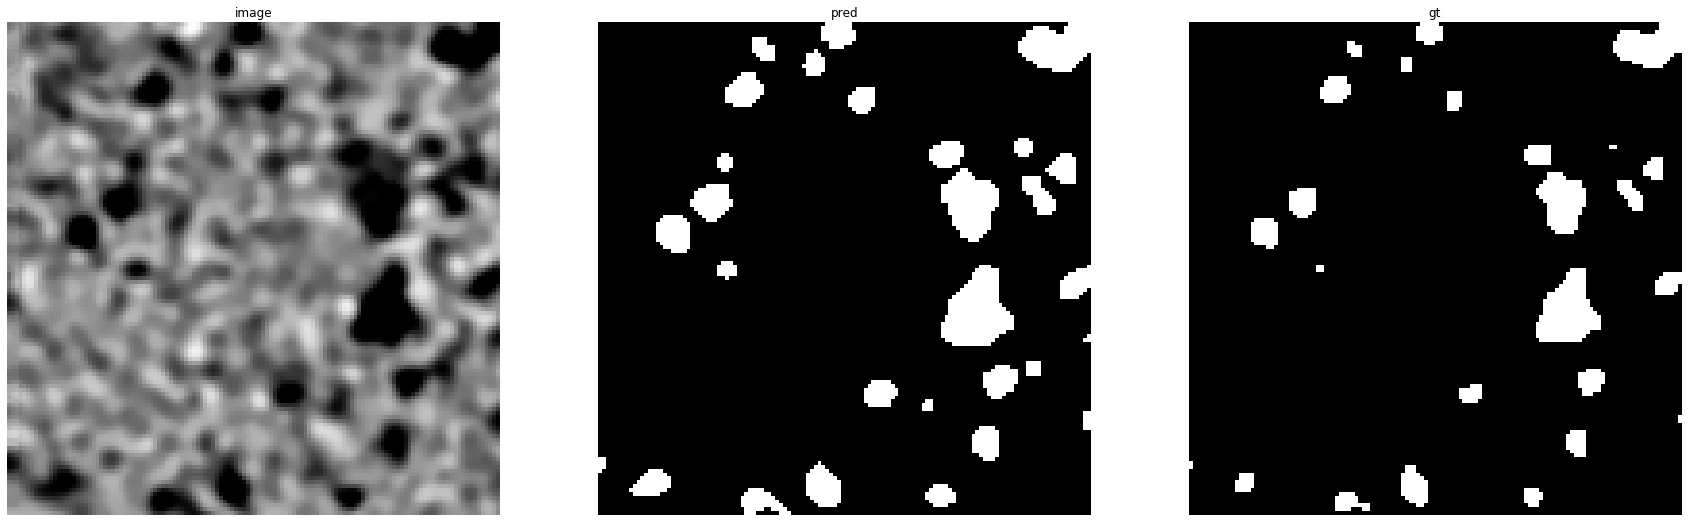

accuracy    : 0.9632568359375
precision   : 0.6448377581120944
recall      : 1.0
f1          : 0.784074605451937
pr_auc      : 0.9904331686884995
iou         : 0.6448377581120944


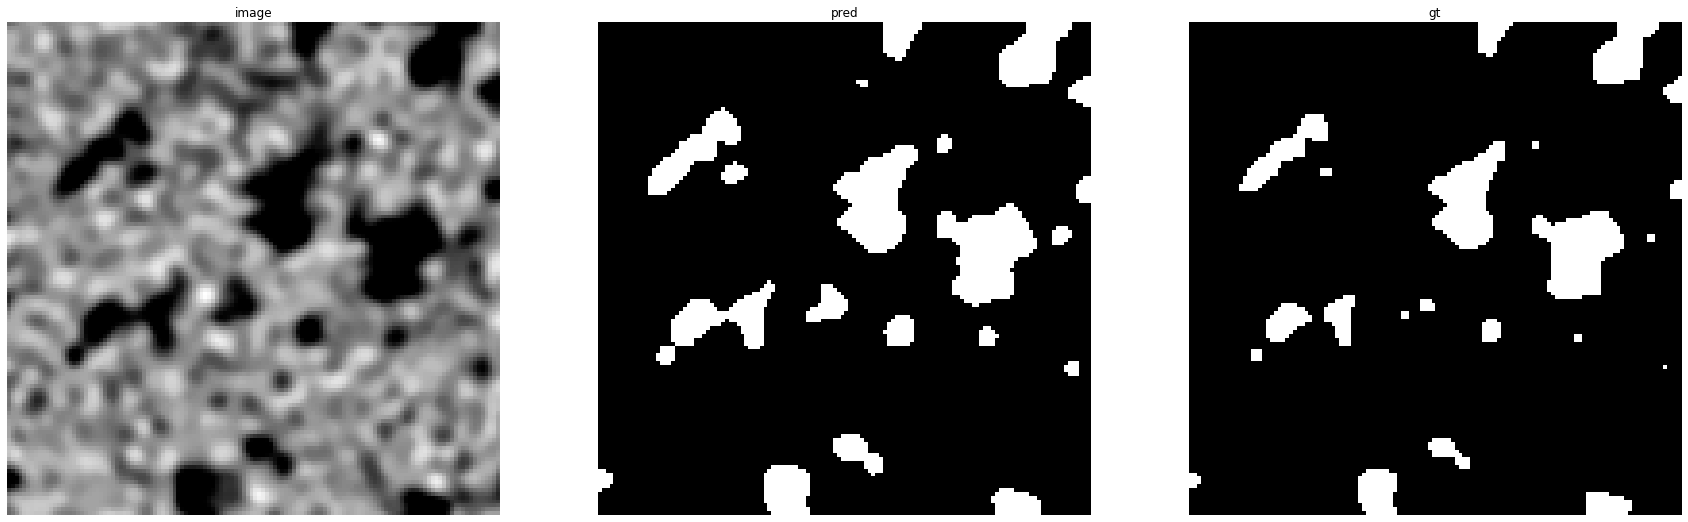

accuracy    : 0.962890625
precision   : 0.7158290277125411
recall      : 0.9980353634577603
f1          : 0.8336980306345733
pr_auc      : 0.9938618013673891
iou         : 0.7148217636022514


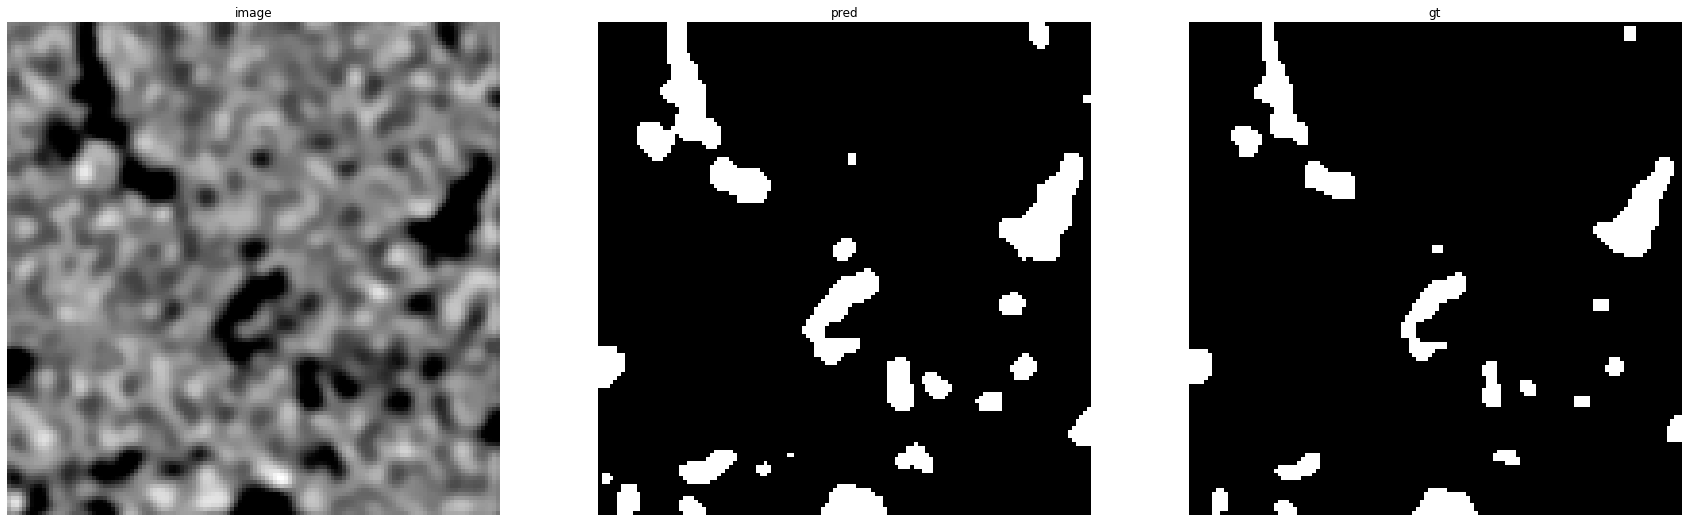

accuracy    : 0.96490478515625
precision   : 0.6611667648791986
recall      : 1.0
f1          : 0.7960269599148634
pr_auc      : 0.993656855559031
iou         : 0.6611667648791986


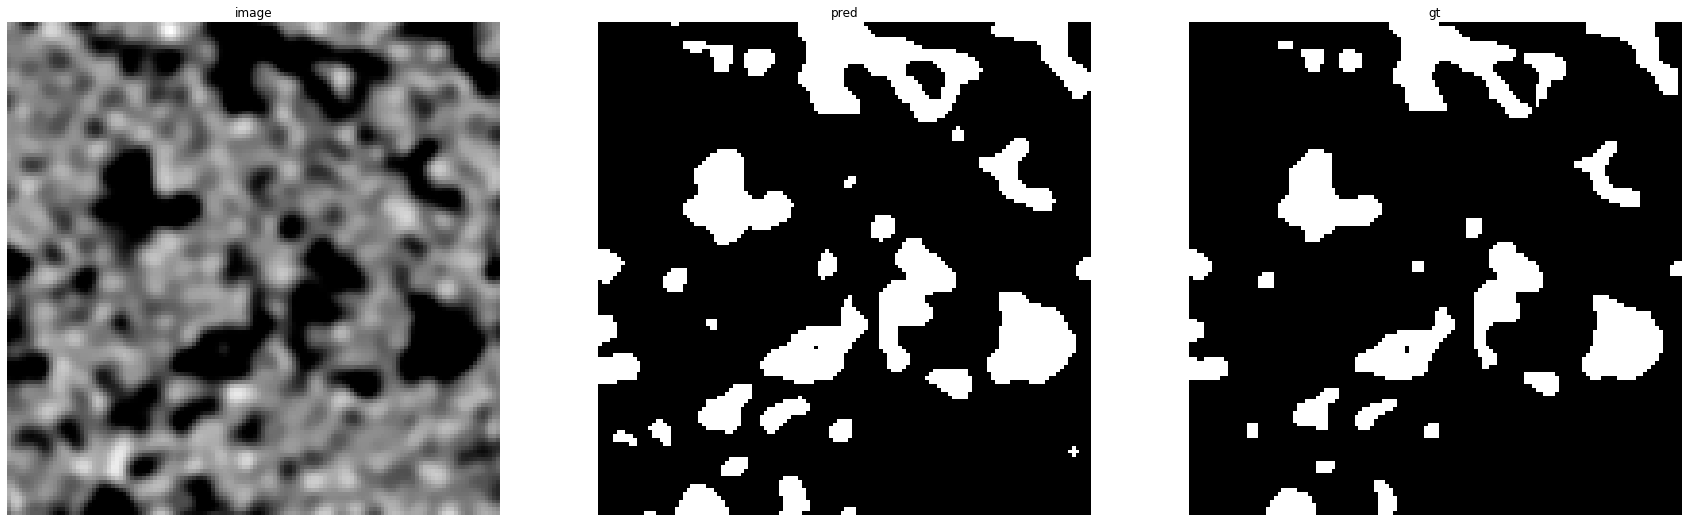

accuracy    : 0.9510498046875
precision   : 0.7598802395209581
recall      : 1.0
f1          : 0.8635590336849268
pr_auc      : 0.9953351443197959
iou         : 0.7598802395209581


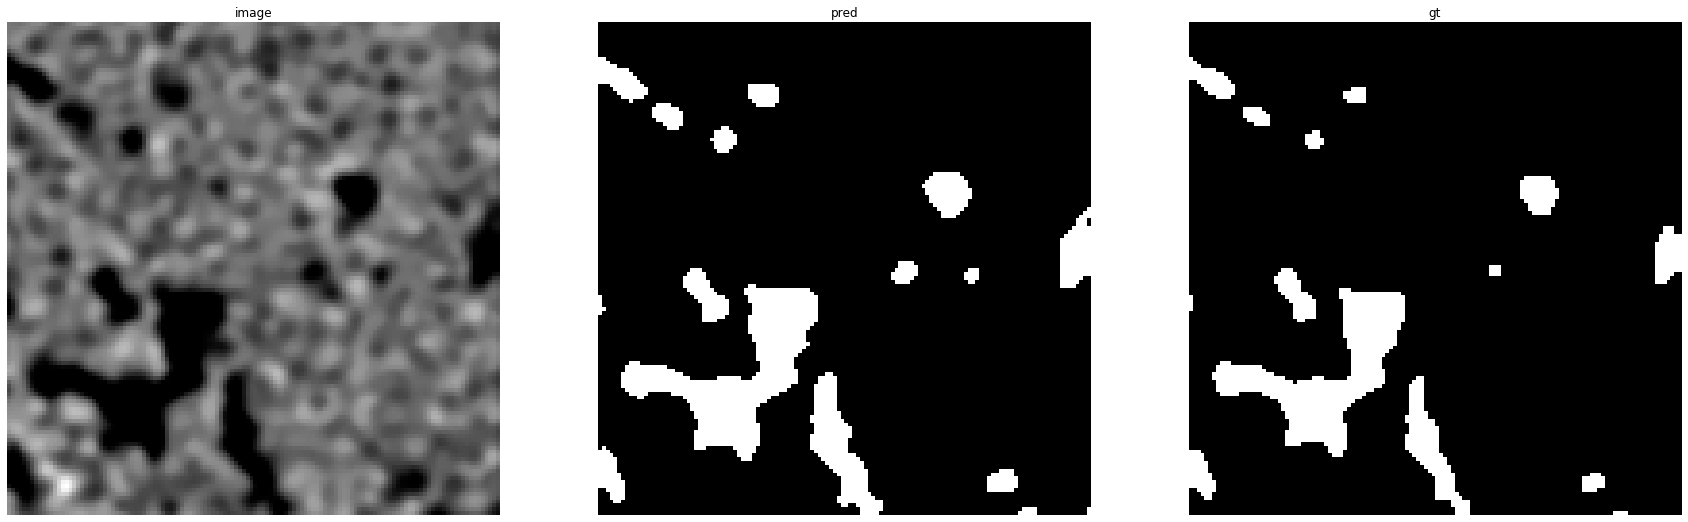

accuracy    : 0.97723388671875
precision   : 0.7960308710033076
recall      : 0.9979267449896337
f1          : 0.8856179086169886
pr_auc      : 0.9951347440151304
iou         : 0.7947165657677491


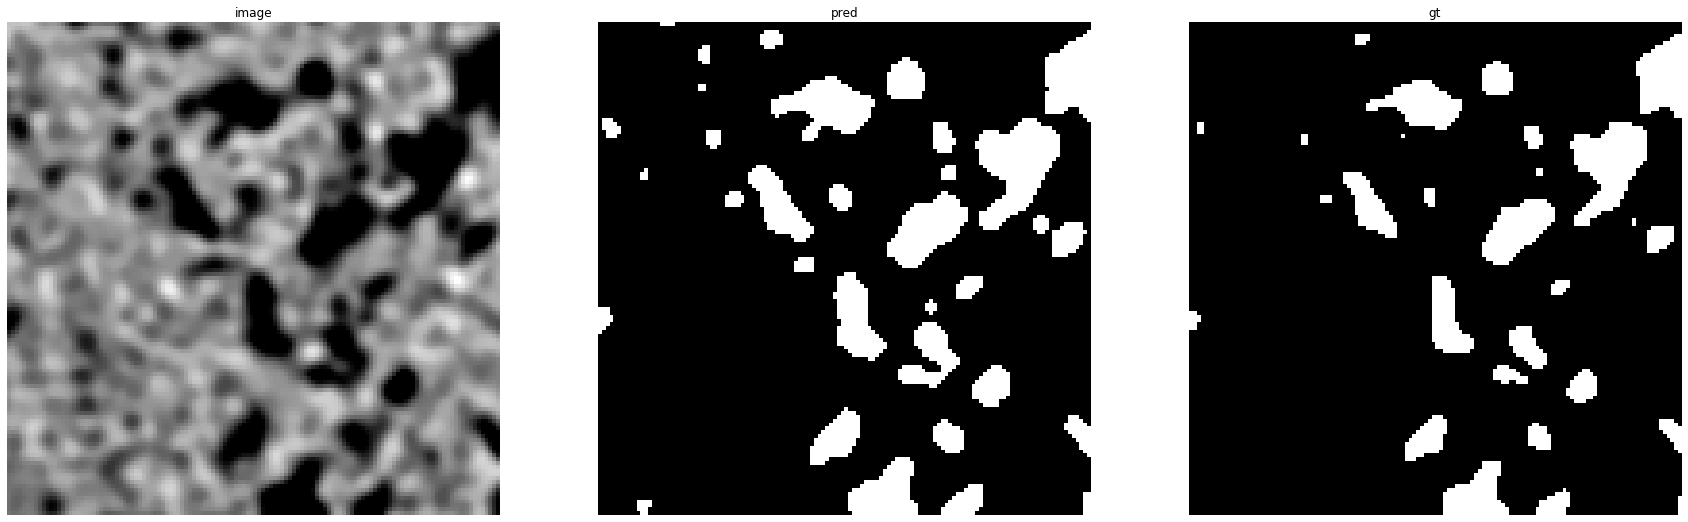

accuracy    : 0.9561767578125
precision   : 0.7198595396020289
recall      : 1.0
f1          : 0.8371143375680581
pr_auc      : 0.9933461126081345
iou         : 0.7198595396020289


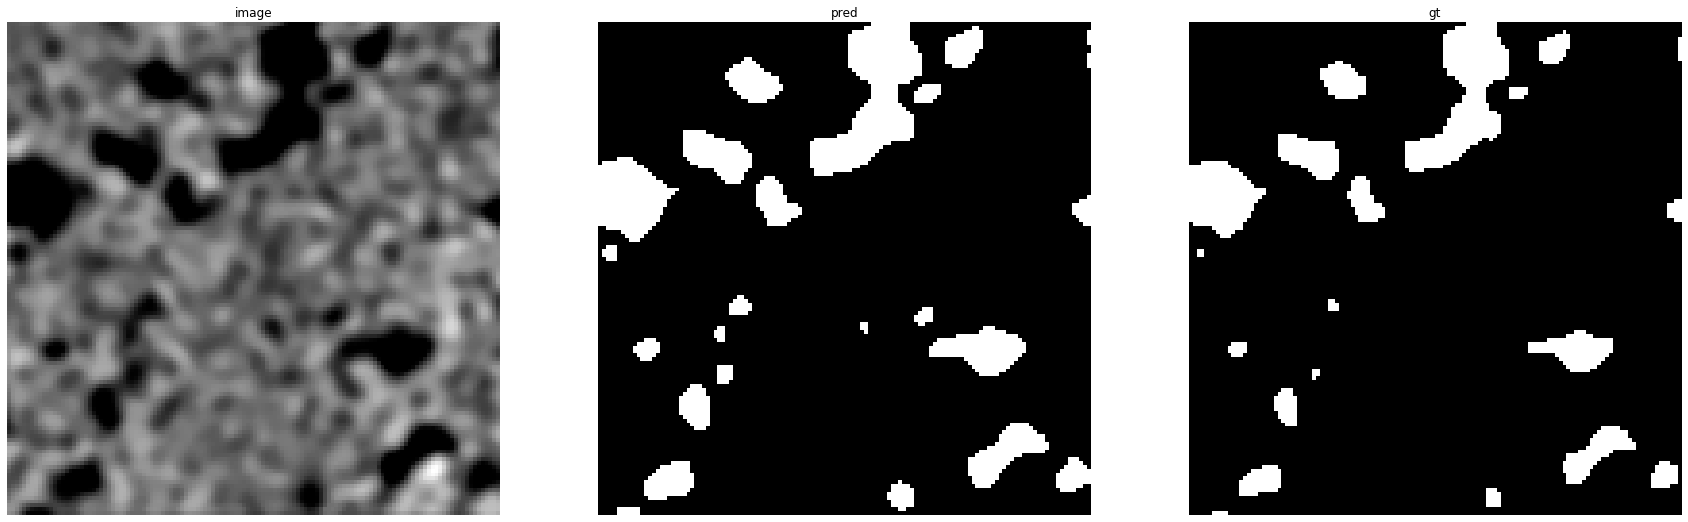

accuracy    : 0.96673583984375
precision   : 0.7519450800915332
recall      : 0.9981773997569866
f1          : 0.857739493604803
pr_auc      : 0.9952094469900579
iou         : 0.7509140767824497


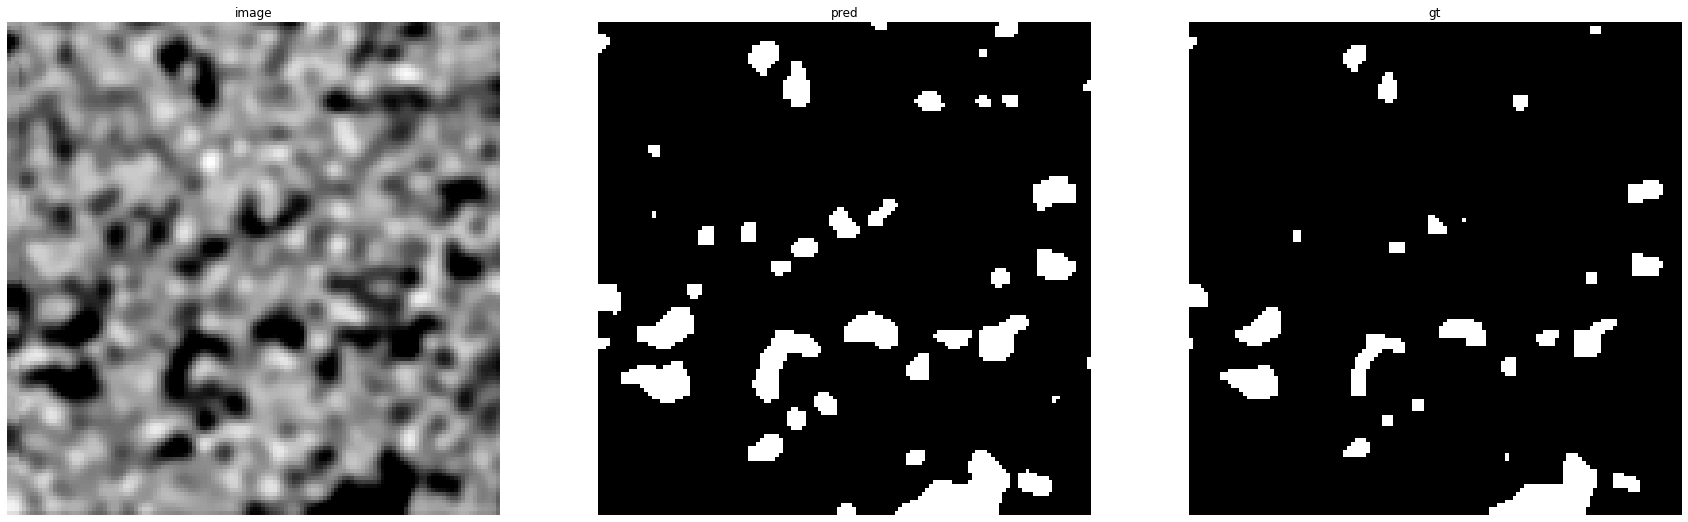

accuracy    : 0.95599365234375
precision   : 0.5736250739207569
recall      : 1.0
f1          : 0.7290492296129274
pr_auc      : 0.9842799874040108
iou         : 0.5736250739207569
carbRNF


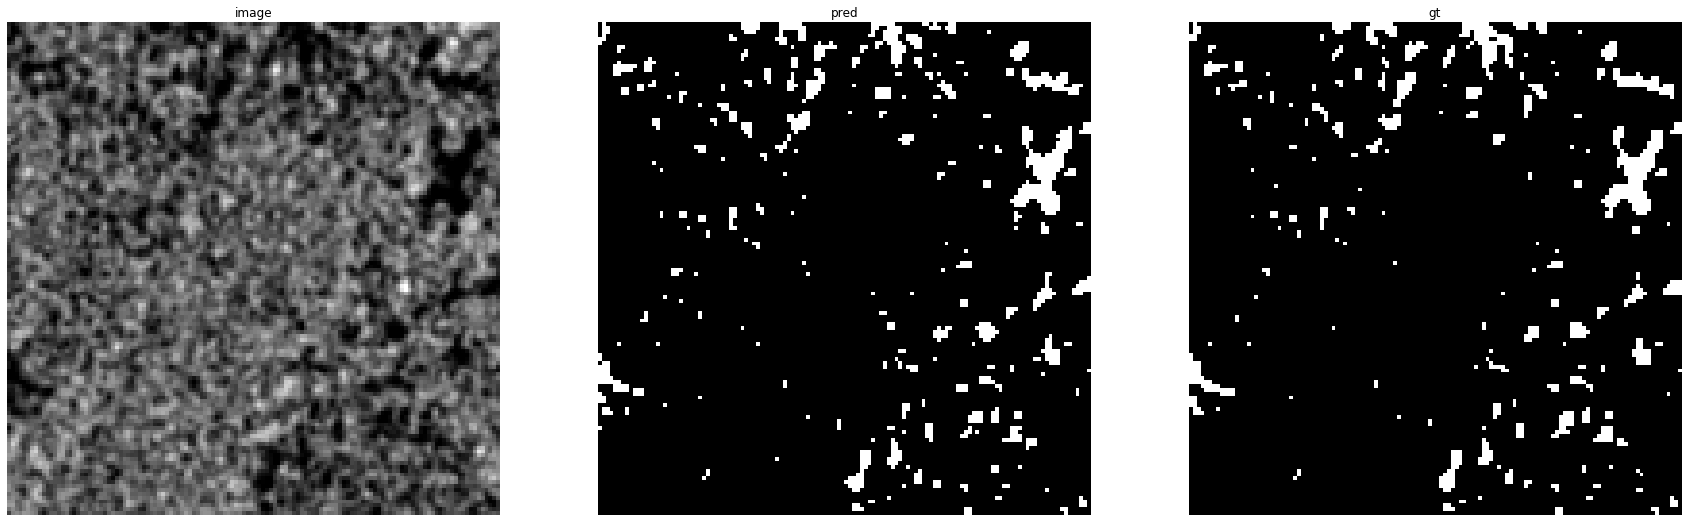

accuracy    : 0.98638916015625
precision   : 0.8796380090497737
recall      : 0.9152542372881356
f1          : 0.8970927549607752
pr_auc      : 0.9695245714582224
iou         : 0.8133891213389122


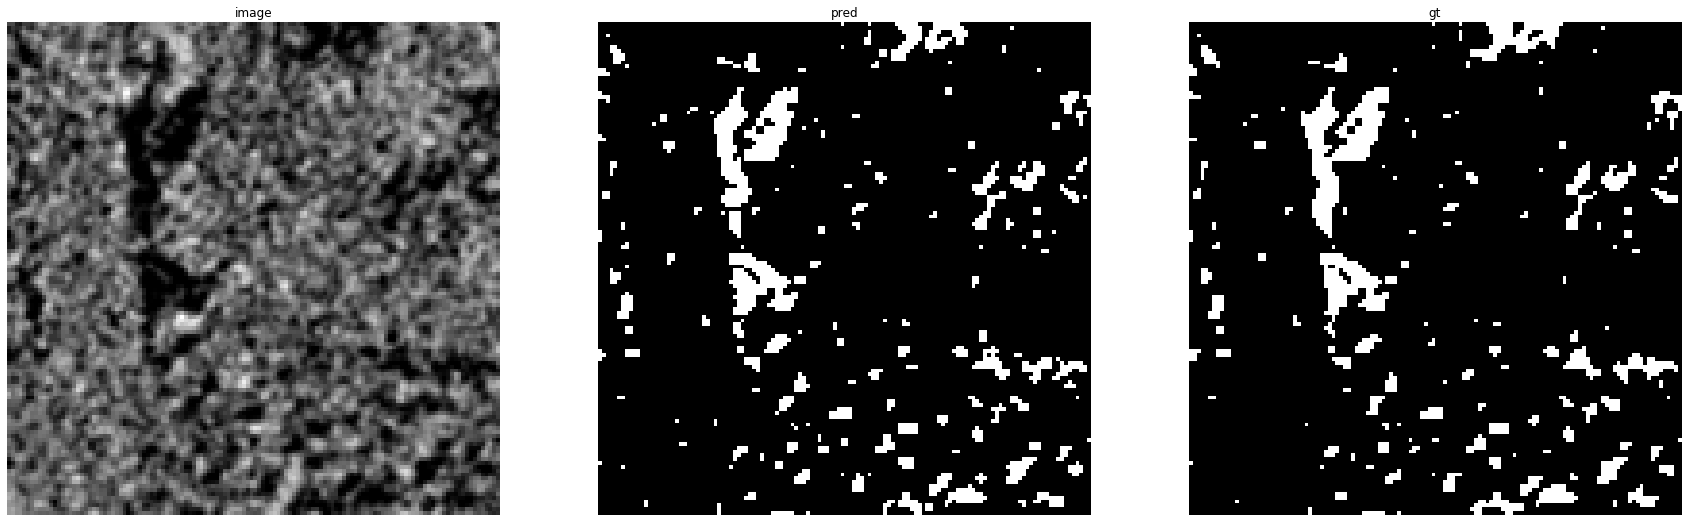

accuracy    : 0.98291015625
precision   : 0.9093851132686084
recall      : 0.9093851132686084
f1          : 0.9093851132686084
pr_auc      : 0.9762072589036926
iou         : 0.8338278931750742


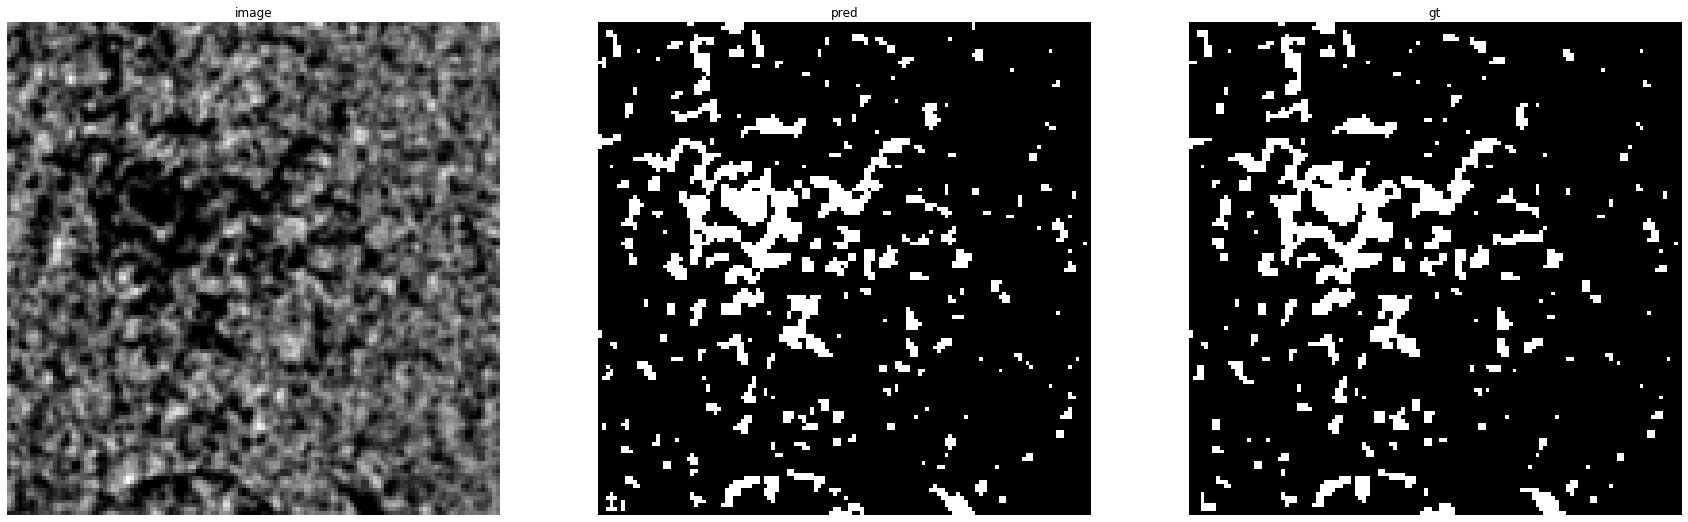

accuracy    : 0.97943115234375
precision   : 0.9056508577194753
recall      : 0.922879177377892
f1          : 0.9141838553603259
pr_auc      : 0.9788997759132763
iou         : 0.8419324577861164


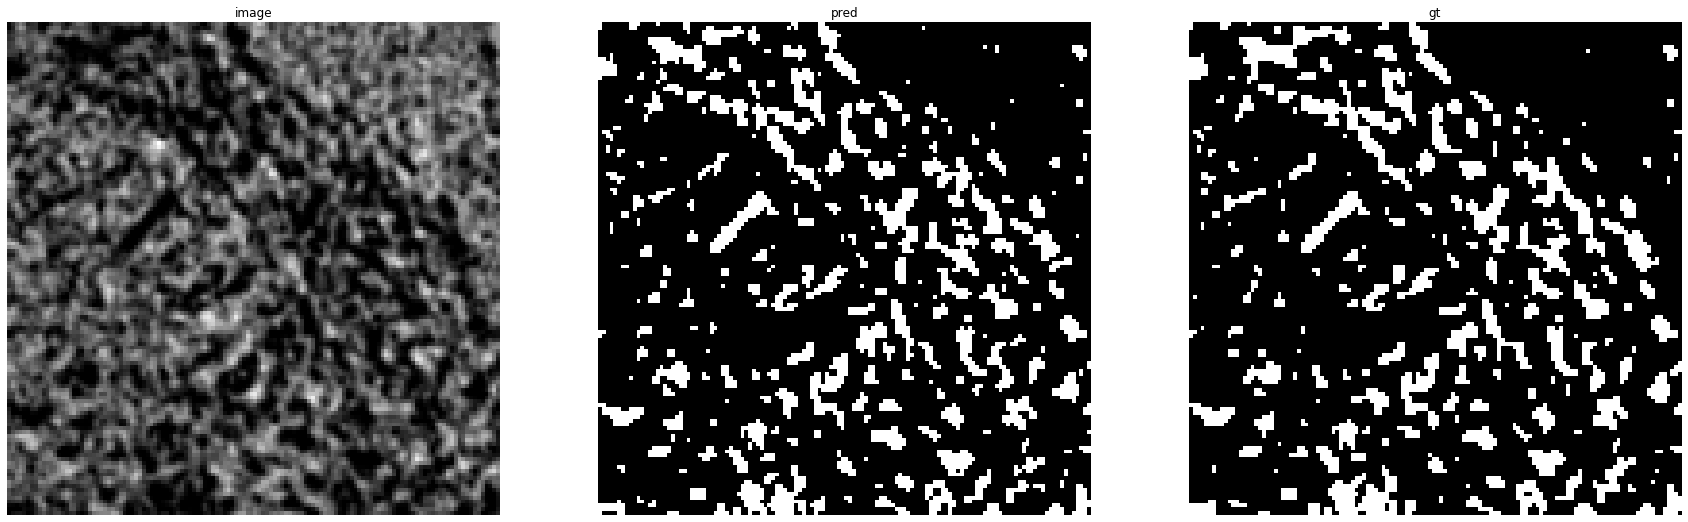

accuracy    : 0.97198486328125
precision   : 0.9308028216325159
recall      : 0.9163359788359788
f1          : 0.9235127478753541
pr_auc      : 0.9834414461875828
iou         : 0.8578947368421053


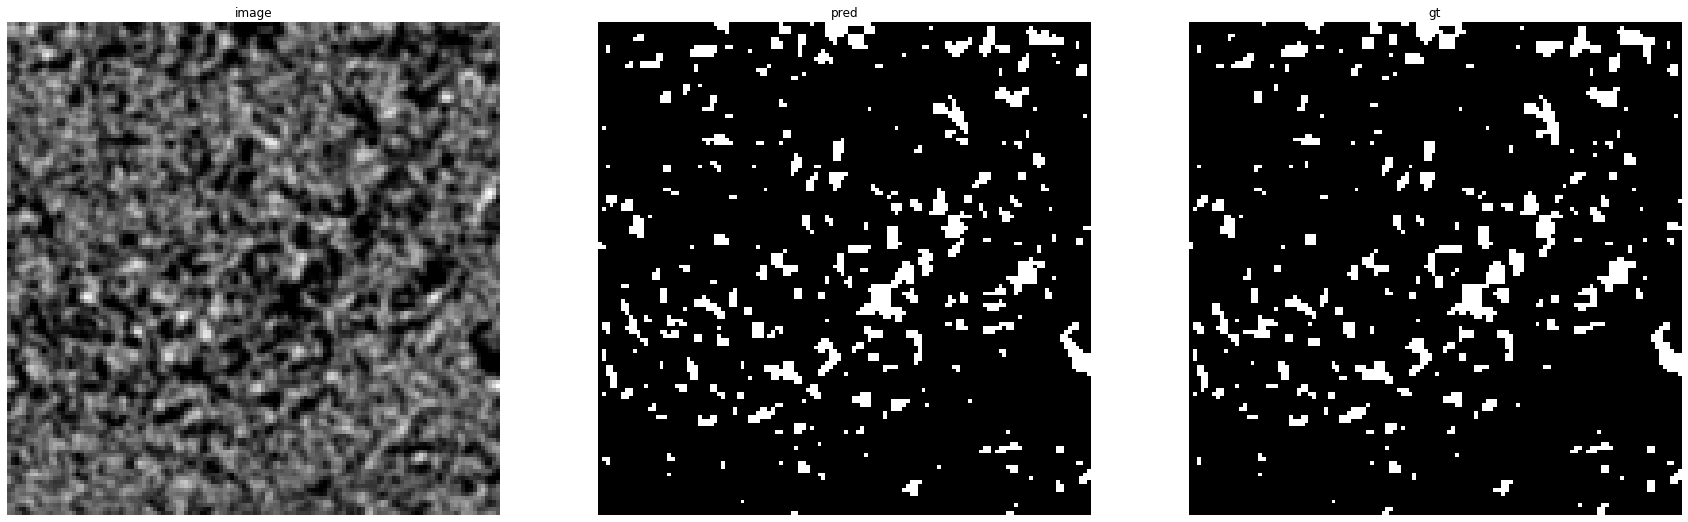

accuracy    : 0.98345947265625
precision   : 0.8990228013029316
recall      : 0.9224598930481284
f1          : 0.910590564170241
pr_auc      : 0.9764598980255854
iou         : 0.8358570563294972


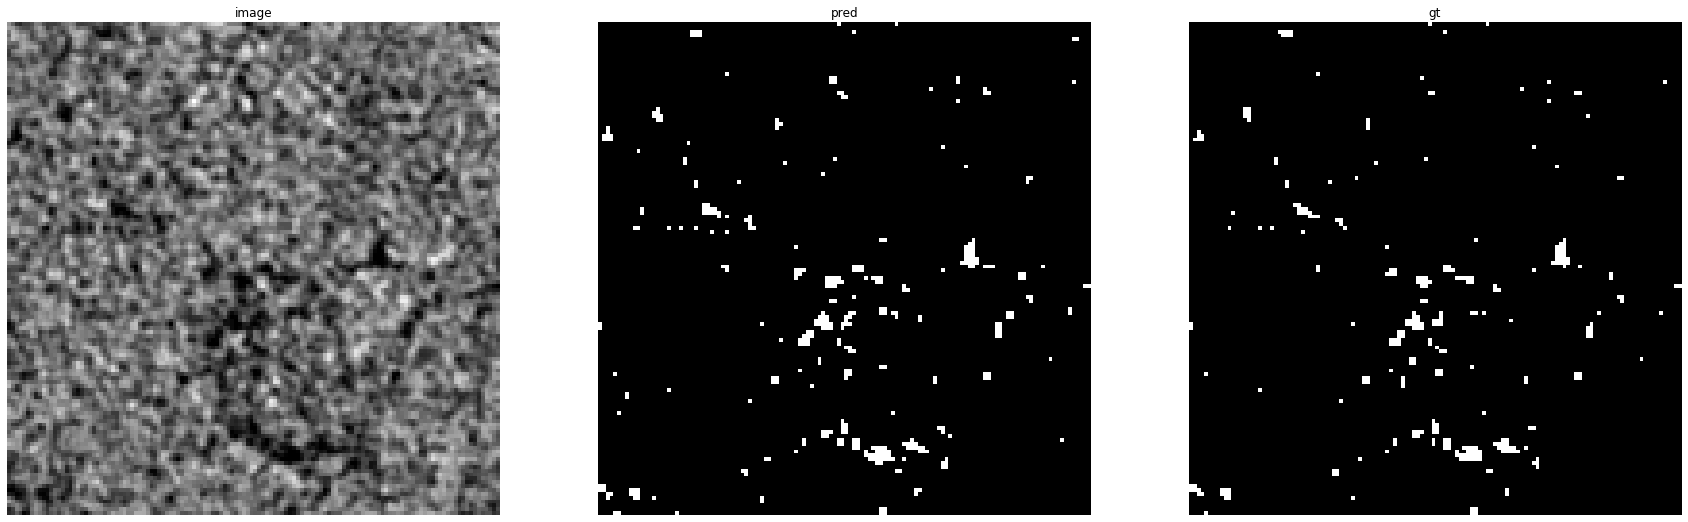

accuracy    : 0.99395751953125
precision   : 0.7877984084880637
recall      : 0.939873417721519
f1          : 0.8571428571428571
pr_auc      : 0.9604333092943228
iou         : 0.75


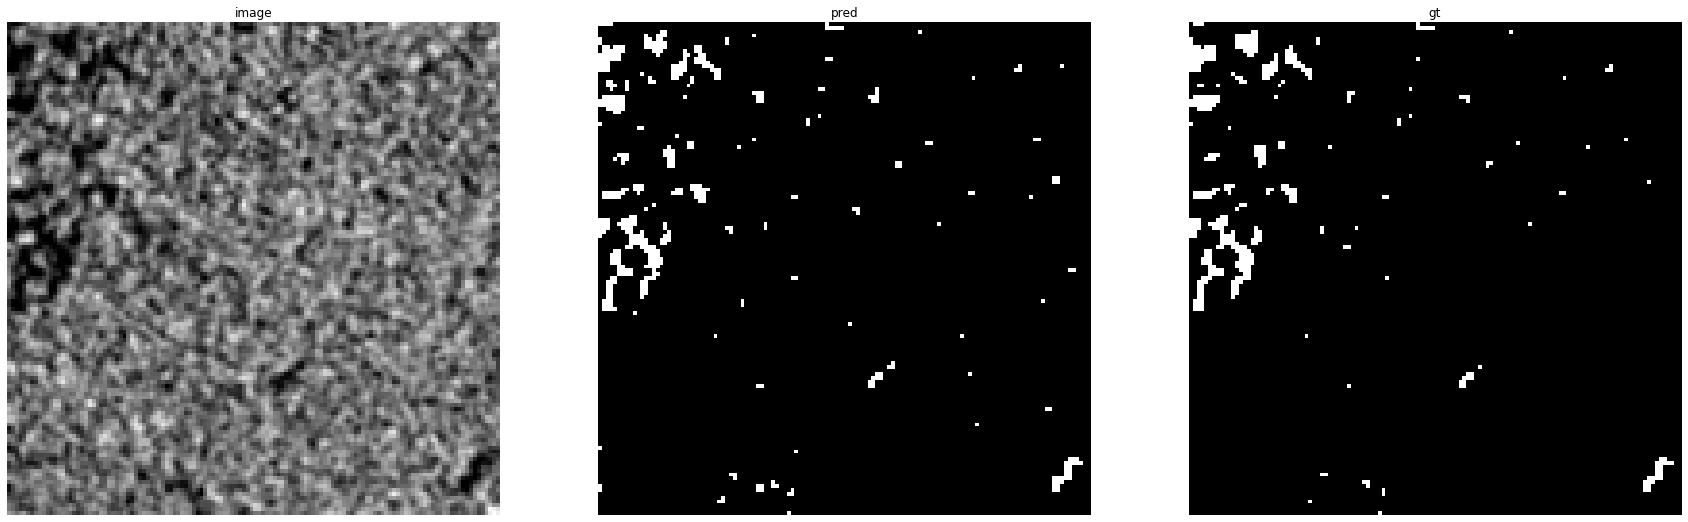

accuracy    : 0.9927978515625
precision   : 0.8273092369477911
recall      : 0.9279279279279279
f1          : 0.8747346072186836
pr_auc      : 0.9640465512047659
iou         : 0.7773584905660378


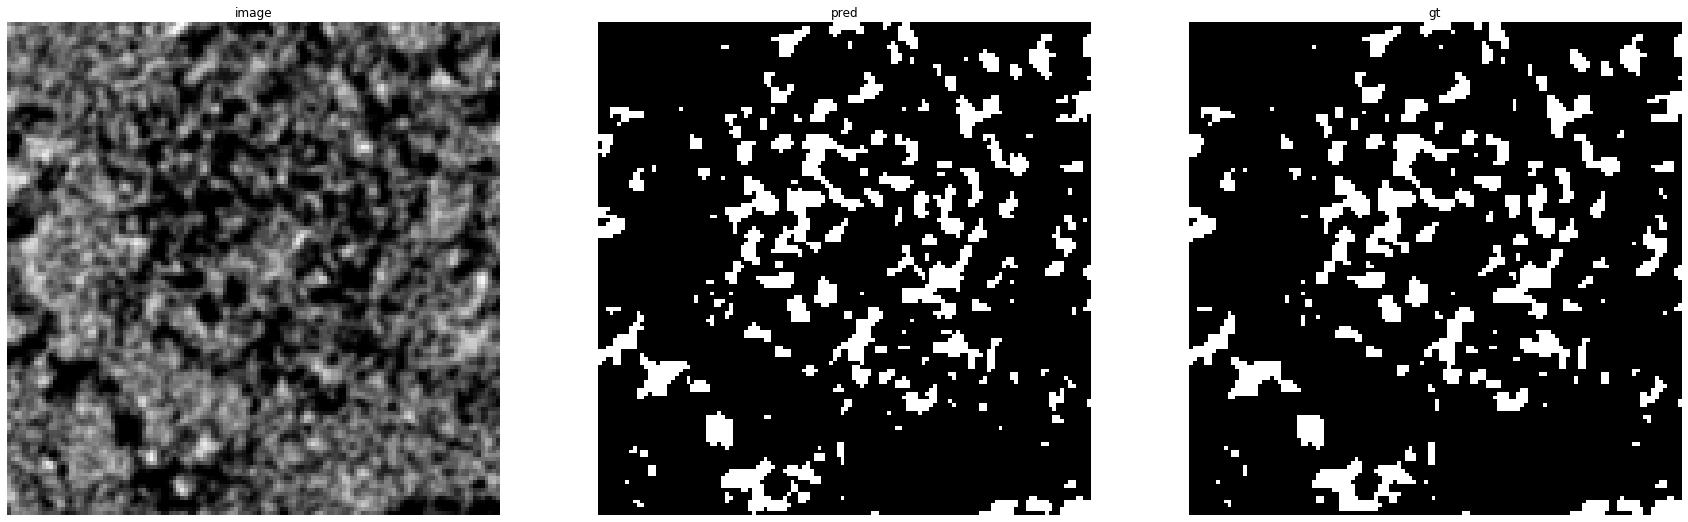

accuracy    : 0.97869873046875
precision   : 0.9261962692619627
recall      : 0.9318645450836394
f1          : 0.9290217612365265
pr_auc      : 0.9852289739674883
iou         : 0.8674515761488796


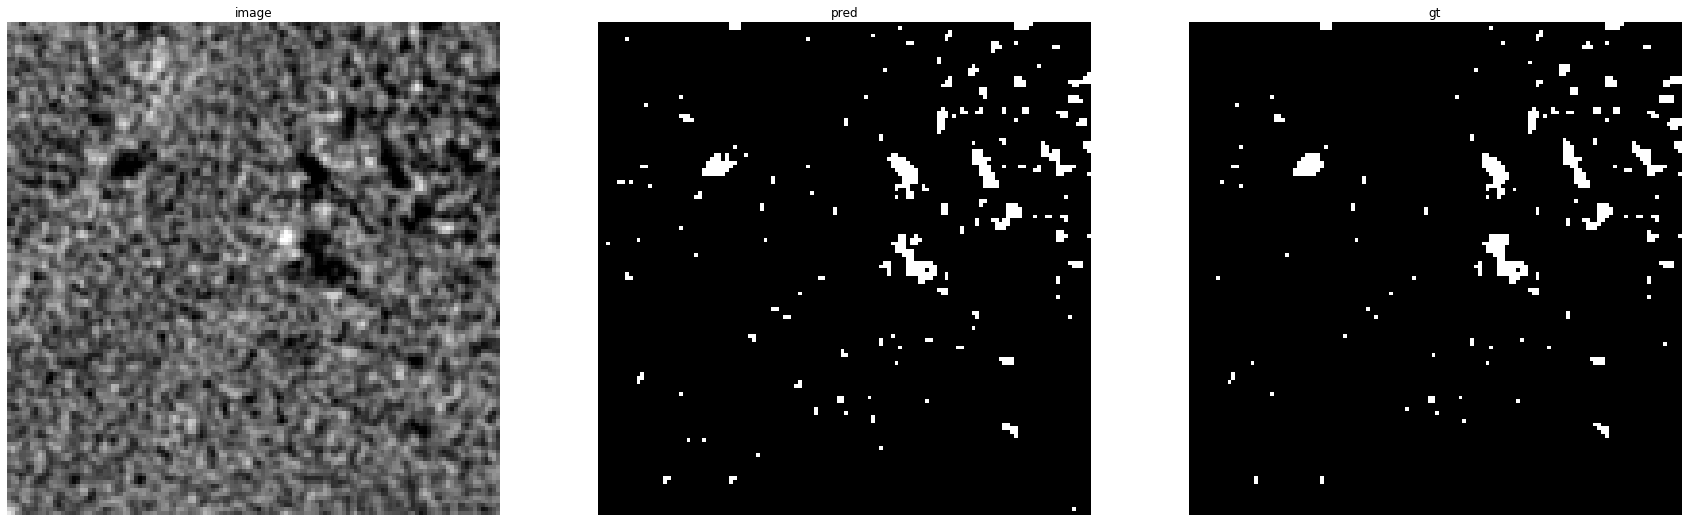

accuracy    : 0.99267578125
precision   : 0.8327137546468402
recall      : 0.9372384937238494
f1          : 0.8818897637795275
pr_auc      : 0.9685807796880144
iou         : 0.7887323943661971


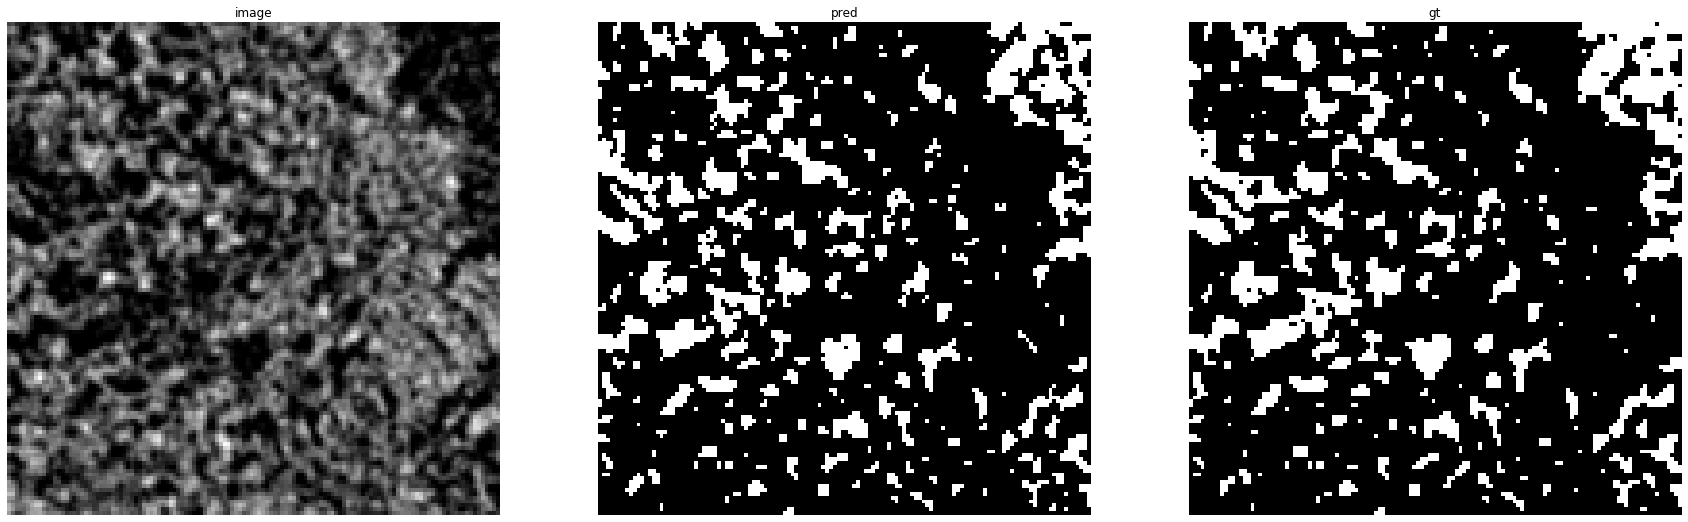

accuracy    : 0.9686279296875
precision   : 0.9421613394216134
recall      : 0.9052354489616847
f1          : 0.9233293556085919
pr_auc      : 0.9814766263427714
iou         : 0.857578276530895
SPE_carb10_58_box3


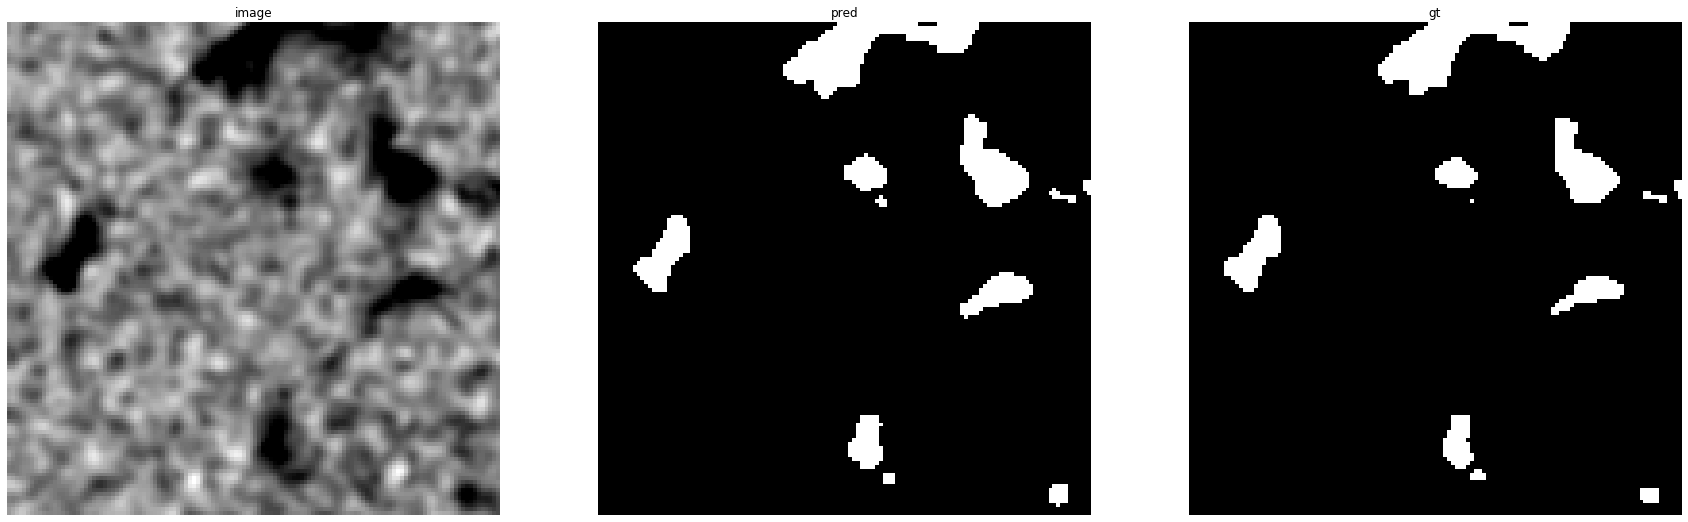

accuracy    : 0.99163818359375
precision   : 0.9042645778938208
recall      : 0.974671669793621
f1          : 0.9381489841986456
pr_auc      : 0.992968792315409
iou         : 0.8835034013605442


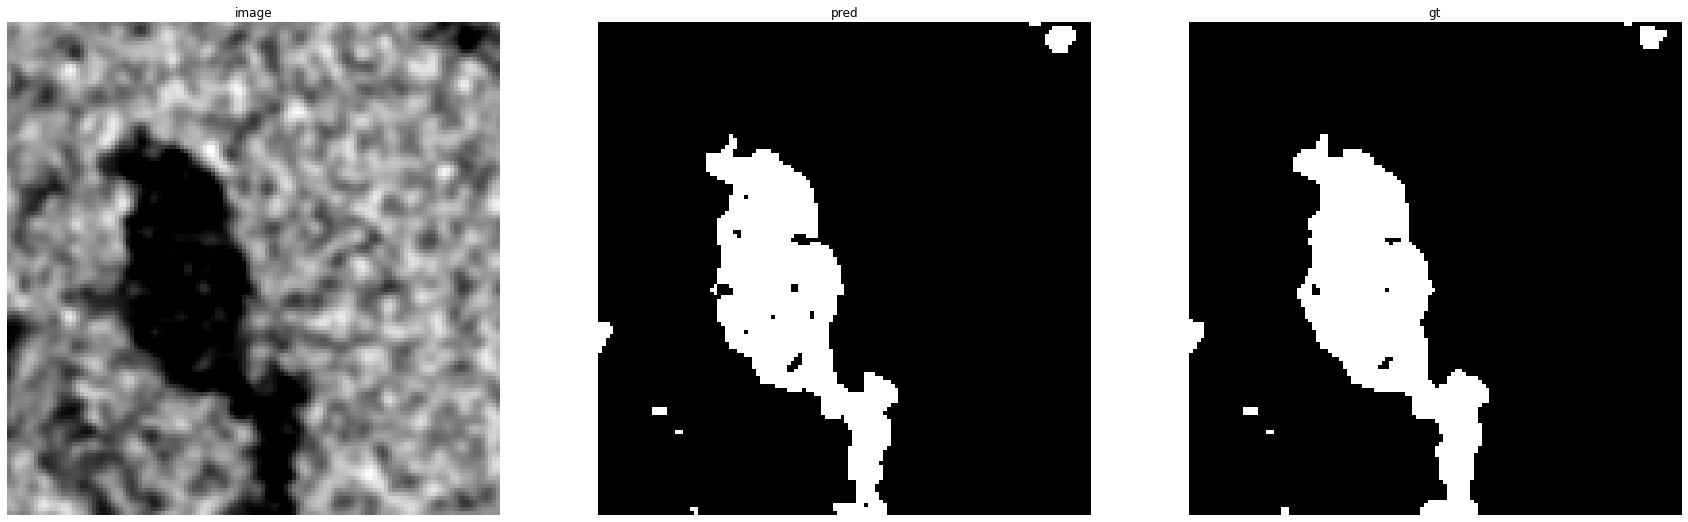

accuracy    : 0.990478515625
precision   : 0.9866600790513834
recall      : 0.9393226716839135
f1          : 0.9624096385542168
pr_auc      : 0.9968519581420118
iou         : 0.9275429633070135


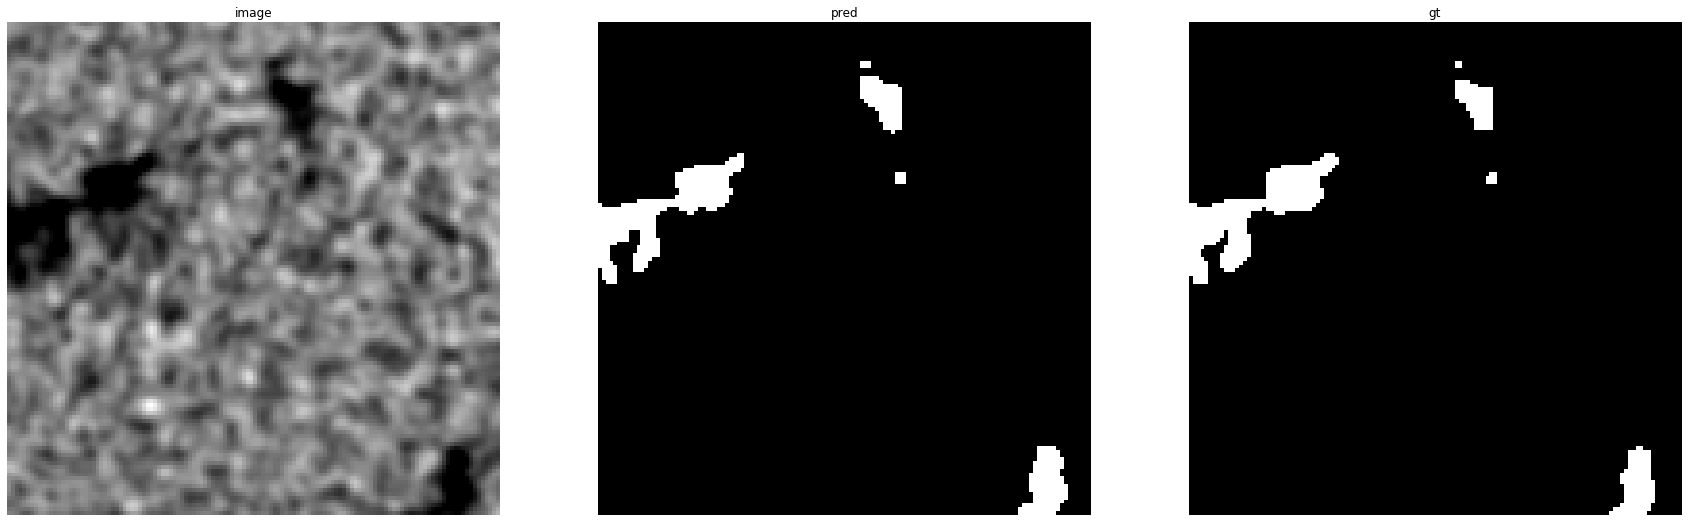

accuracy    : 0.9949951171875
precision   : 0.9416909620991254
recall      : 0.938953488372093
f1          : 0.9403202328966521
pr_auc      : 0.9897239469649262
iou         : 0.8873626373626373


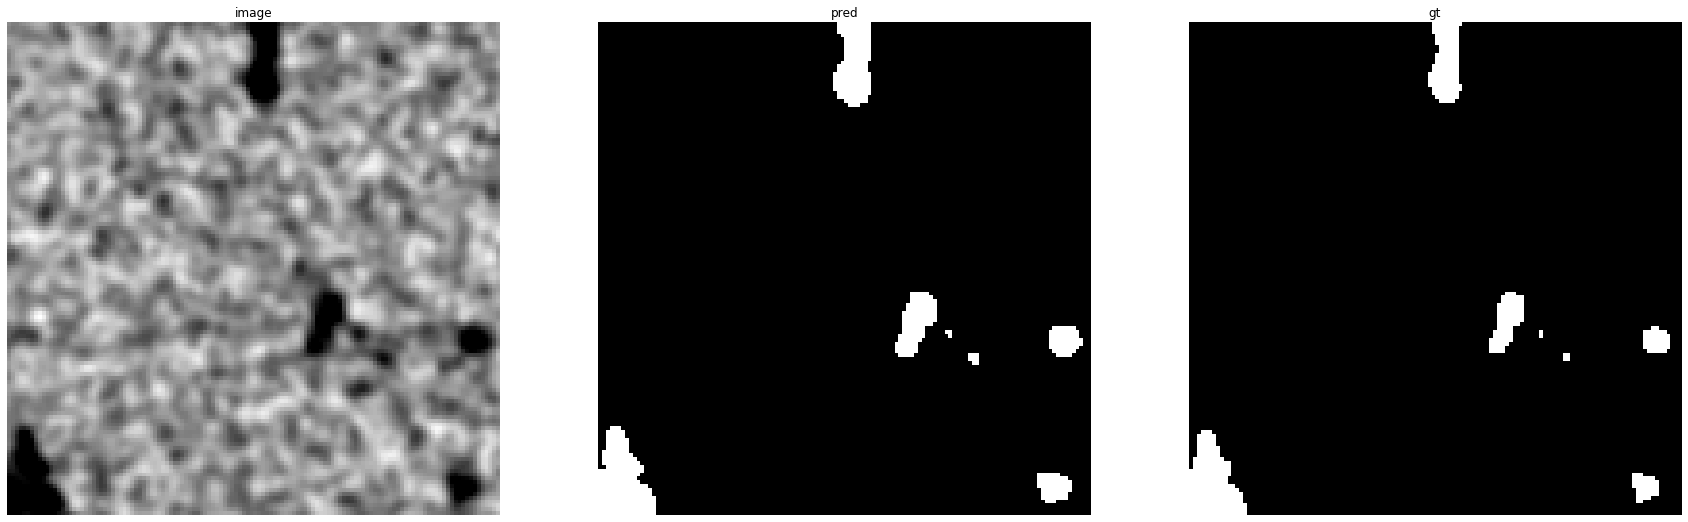

accuracy    : 0.99267578125
precision   : 0.8177641653905053
recall      : 0.9981308411214953
f1          : 0.898989898989899
pr_auc      : 0.9947514164371309
iou         : 0.8165137614678899


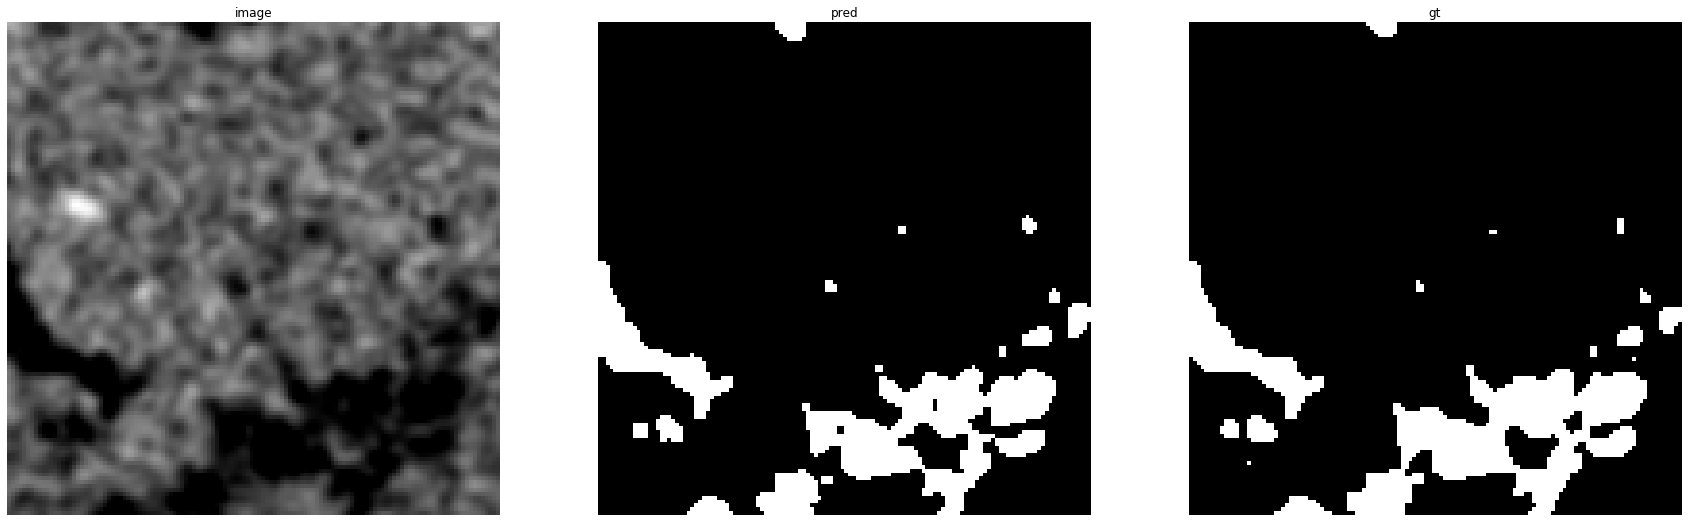

accuracy    : 0.987548828125
precision   : 0.9746300211416491
recall      : 0.922
f1          : 0.947584789311408
pr_auc      : 0.9917105844995188
iou         : 0.900390625


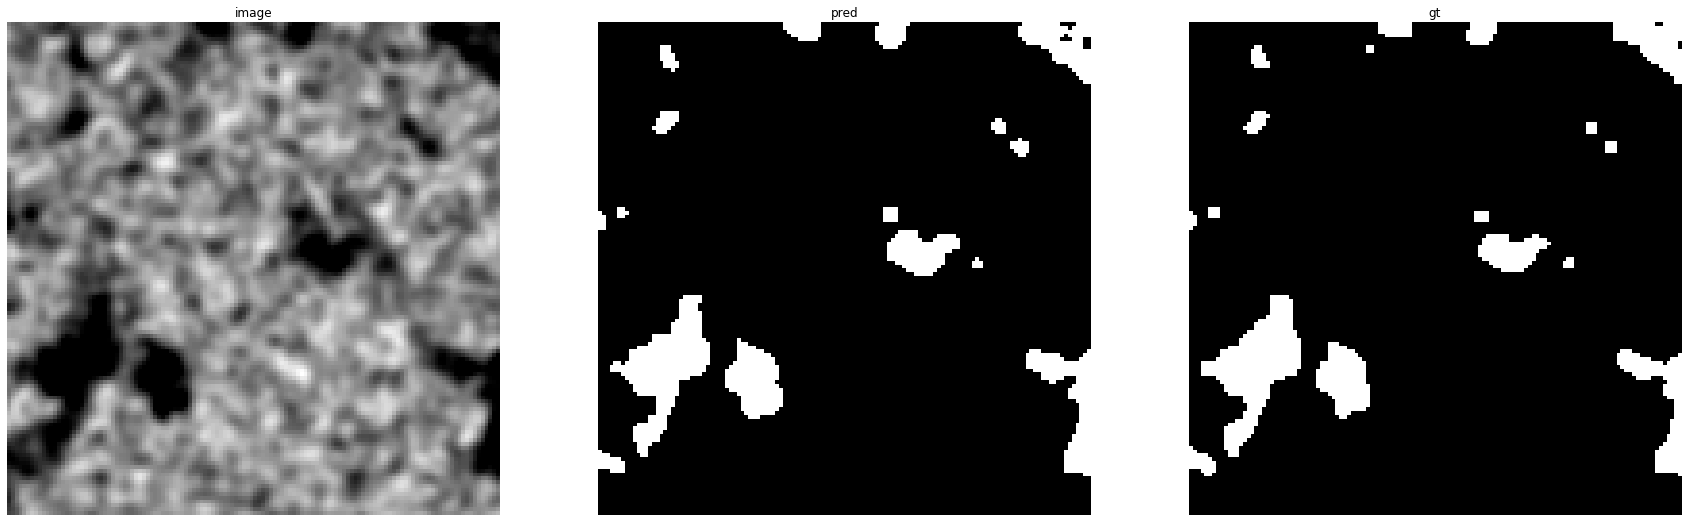

accuracy    : 0.98822021484375
precision   : 0.9089635854341737
recall      : 0.9537105069801617
f1          : 0.9307995697382574
pr_auc      : 0.9888757693802536
iou         : 0.8705566733735748


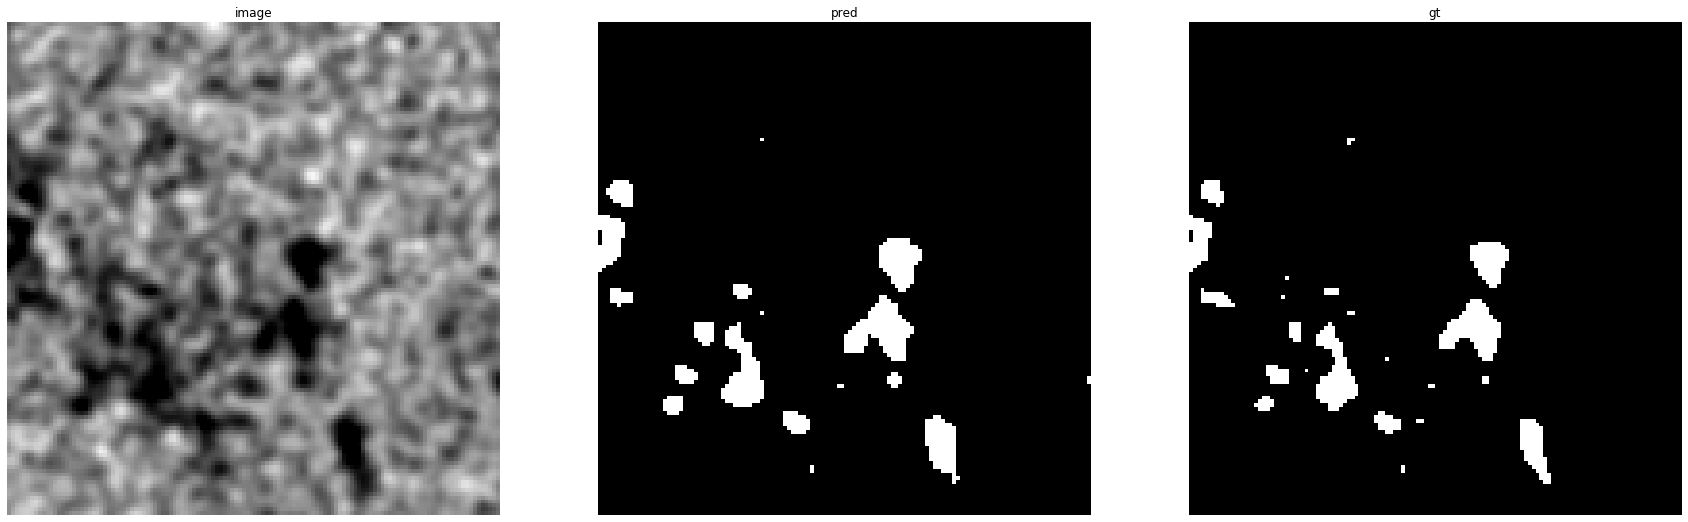

accuracy    : 0.98822021484375
precision   : 0.8017676767676768
recall      : 0.9463487332339792
f1          : 0.8680792891319208
pr_auc      : 0.972320296023455
iou         : 0.7669082125603864


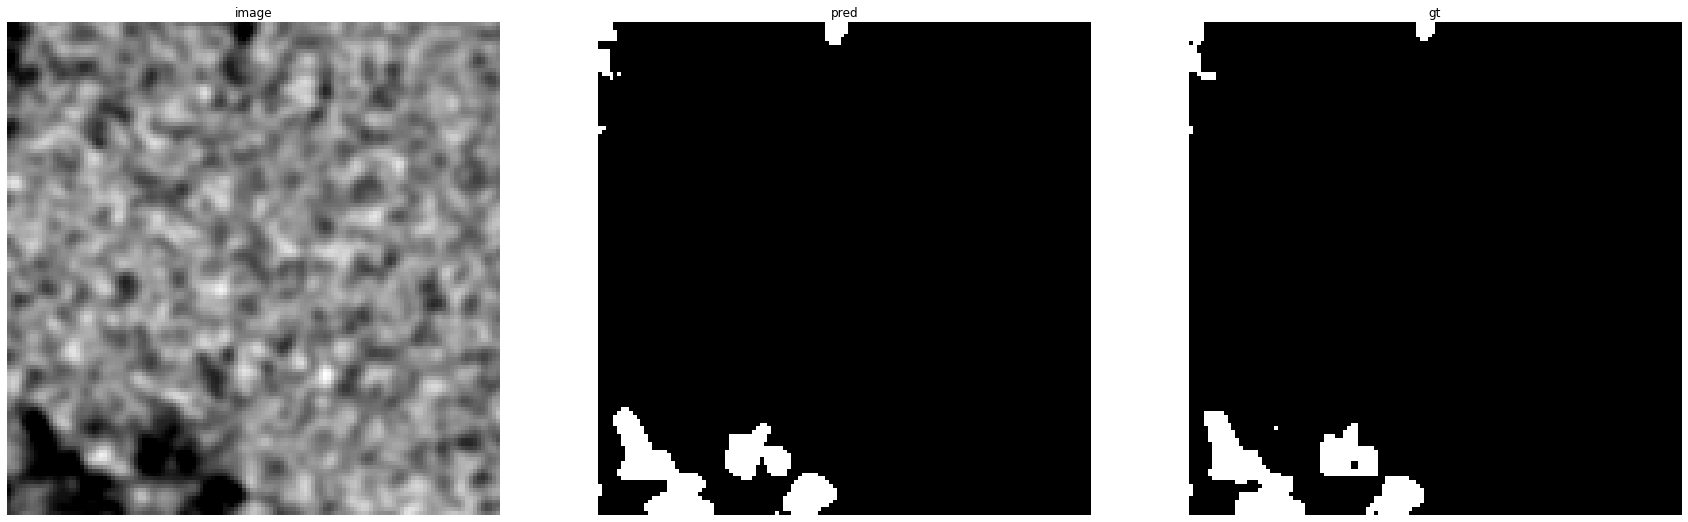

accuracy    : 0.99383544921875
precision   : 0.911144578313253
recall      : 0.9350850077279753
f1          : 0.9229595728451564
pr_auc      : 0.9846845205124894
iou         : 0.8569405099150141


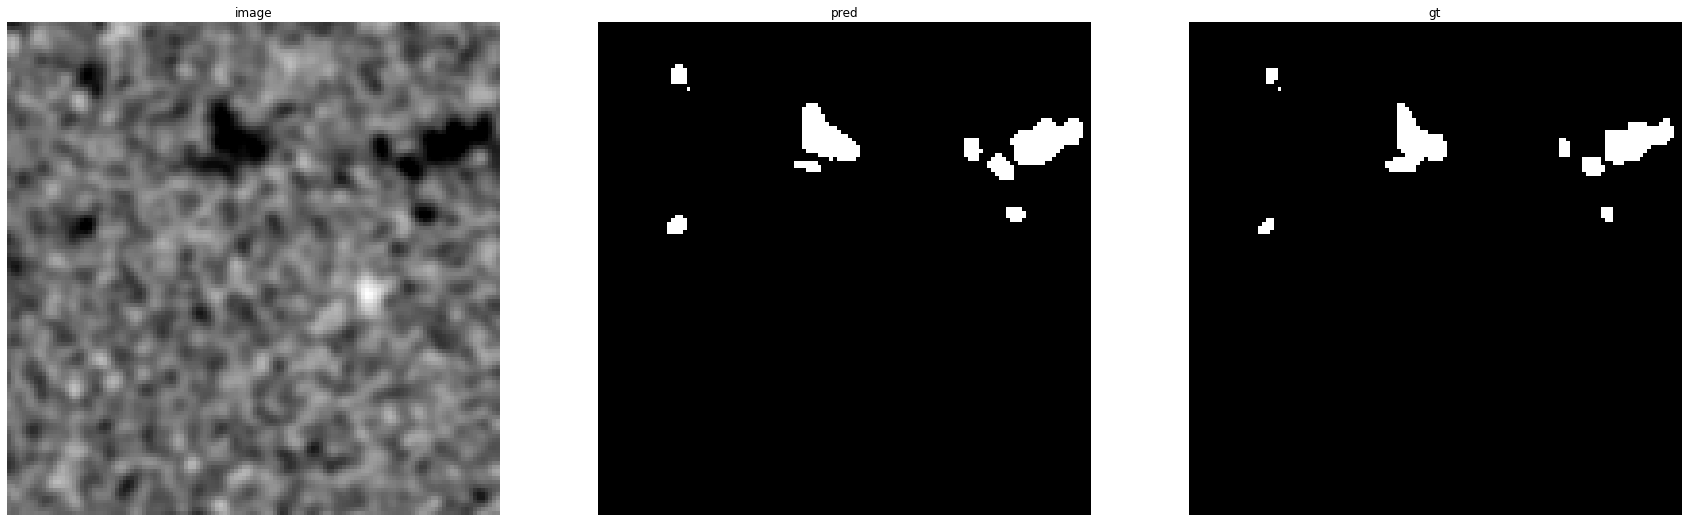

accuracy    : 0.99395751953125
precision   : 0.8071428571428572
recall      : 0.9495798319327731
f1          : 0.8725868725868726
pr_auc      : 0.9758185305739444
iou         : 0.773972602739726


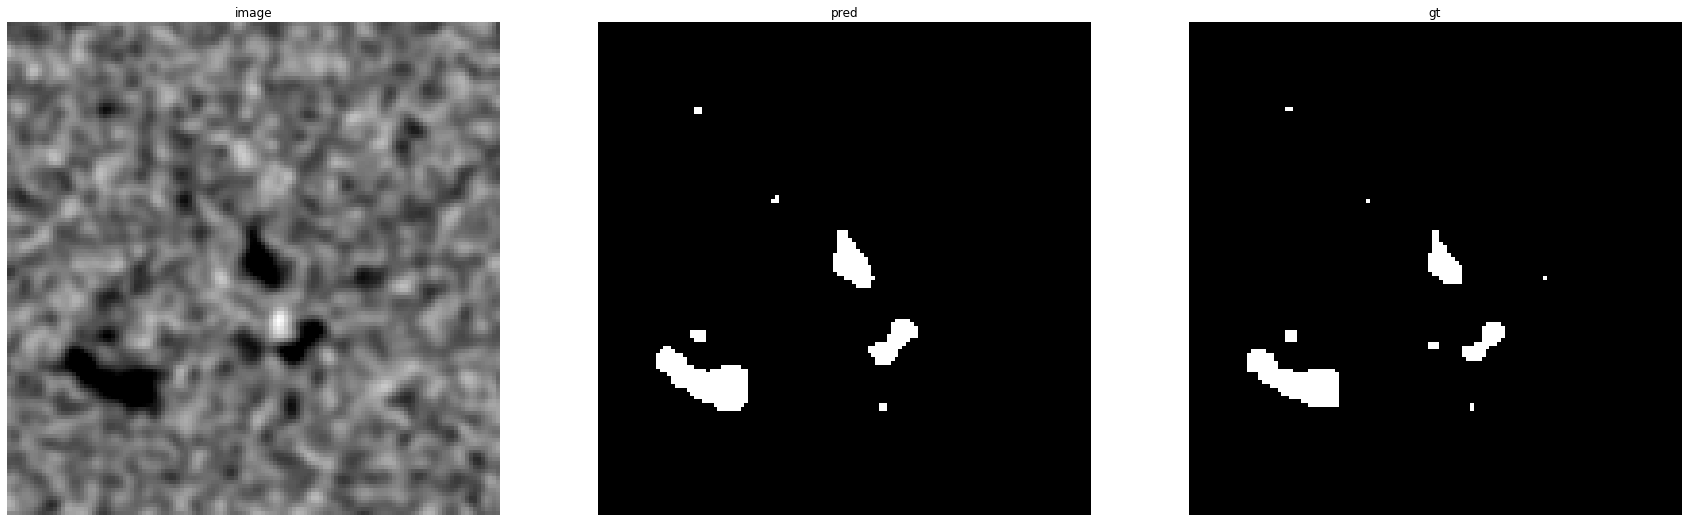

accuracy    : 0.99456787109375
precision   : 0.8100961538461539
recall      : 0.9711815561959655
f1          : 0.8833551769331587
pr_auc      : 0.9859717705001305
iou         : 0.7910798122065728
SoilAh-1


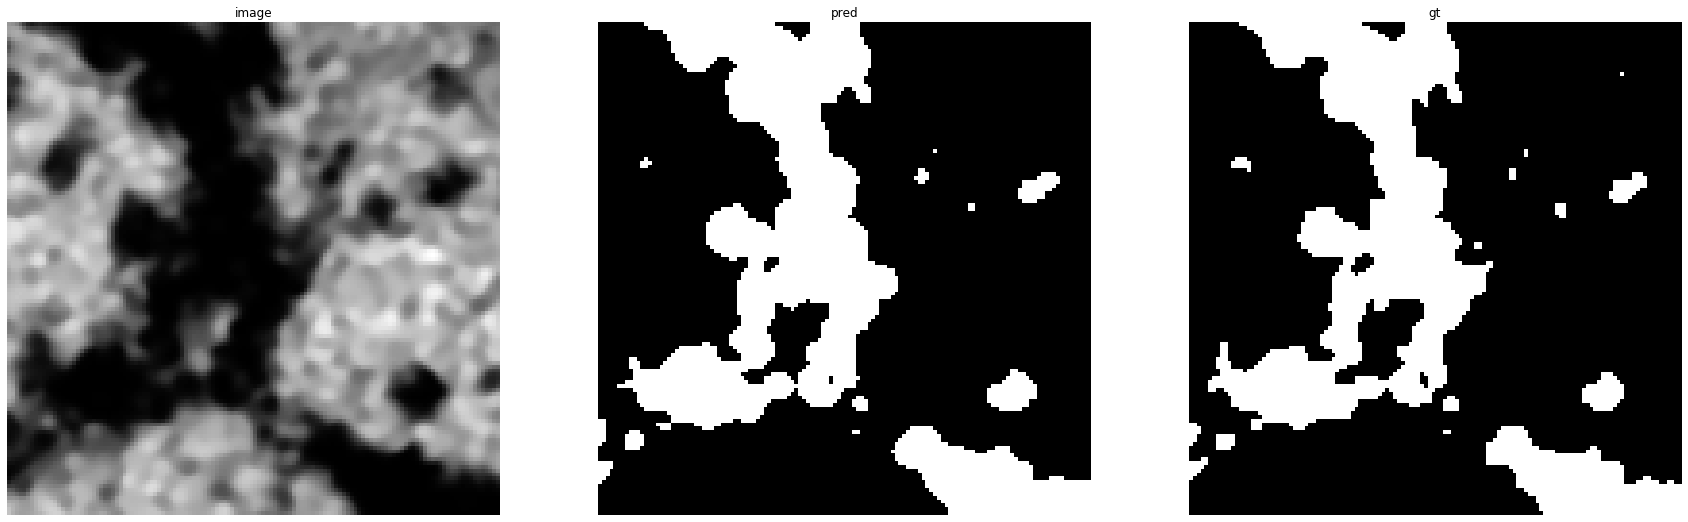

accuracy    : 0.97650146484375
precision   : 0.9263547938860583
recall      : 0.9835259404966806
f1          : 0.9540846750149077
pr_auc      : 0.9963293059084722
iou         : 0.9122006841505131


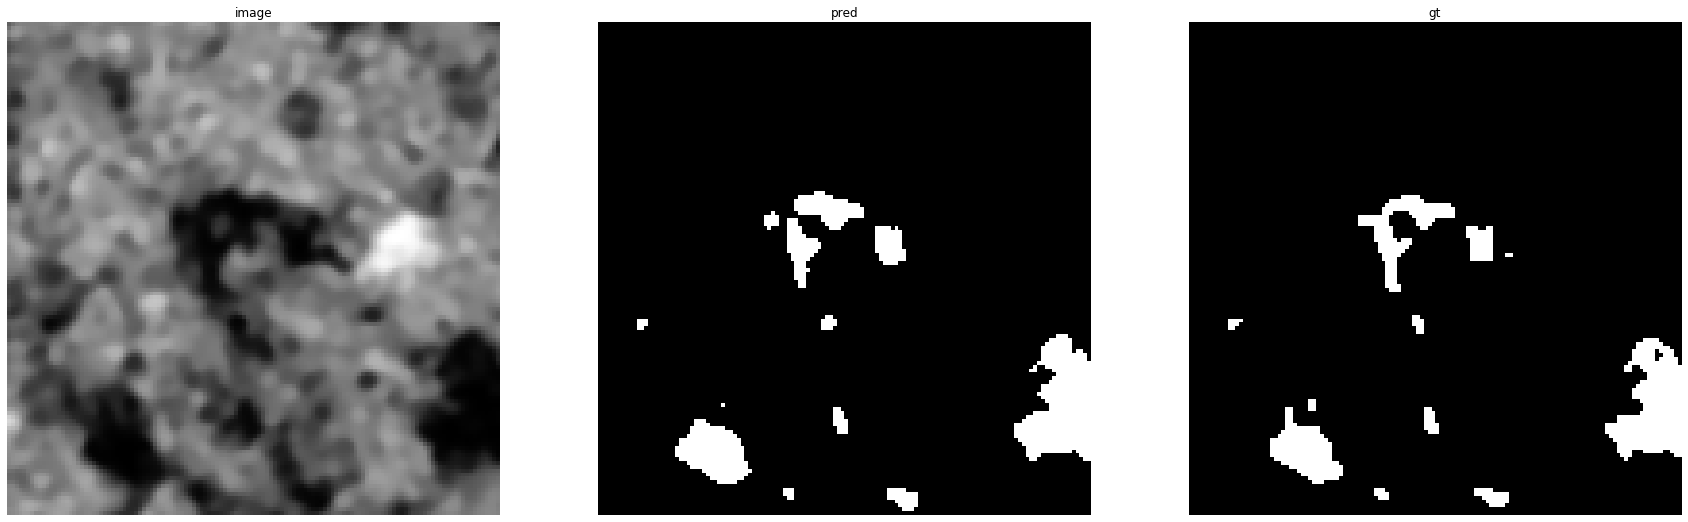

accuracy    : 0.9896240234375
precision   : 0.8840725806451613
recall      : 0.9409871244635193
f1          : 0.9116424116424116
pr_auc      : 0.985076037173183
iou         : 0.8376313276026743


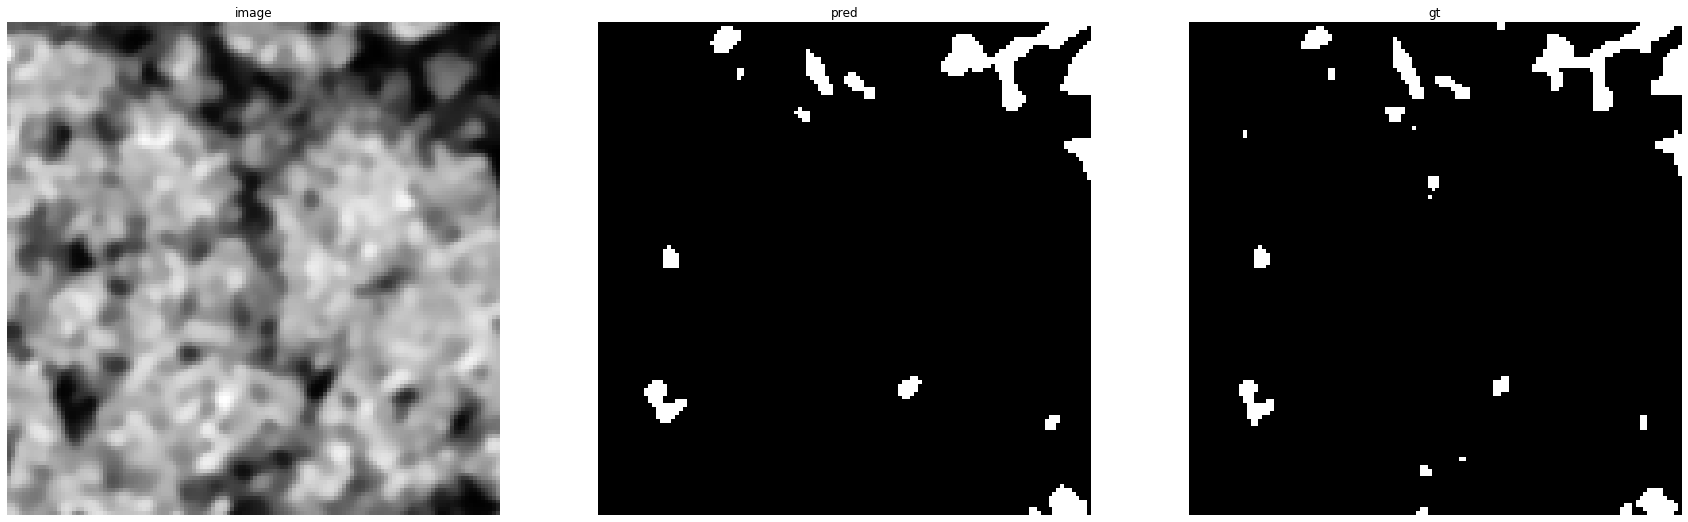

accuracy    : 0.98876953125
precision   : 0.8731563421828908
recall      : 0.8579710144927536
f1          : 0.8654970760233918
pr_auc      : 0.9549106043702883
iou         : 0.7628865979381443


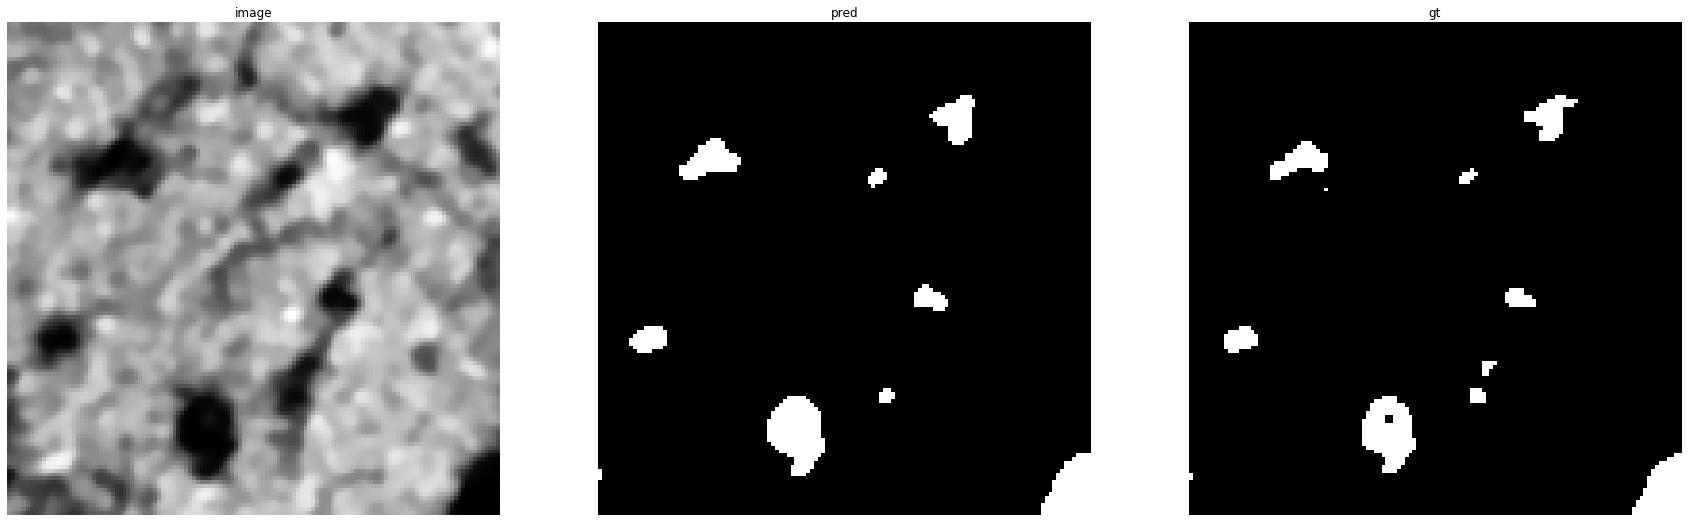

accuracy    : 0.99298095703125
precision   : 0.8654124457308249
recall      : 0.964516129032258
f1          : 0.9122807017543859
pr_auc      : 0.9866539831455242
iou         : 0.8387096774193549


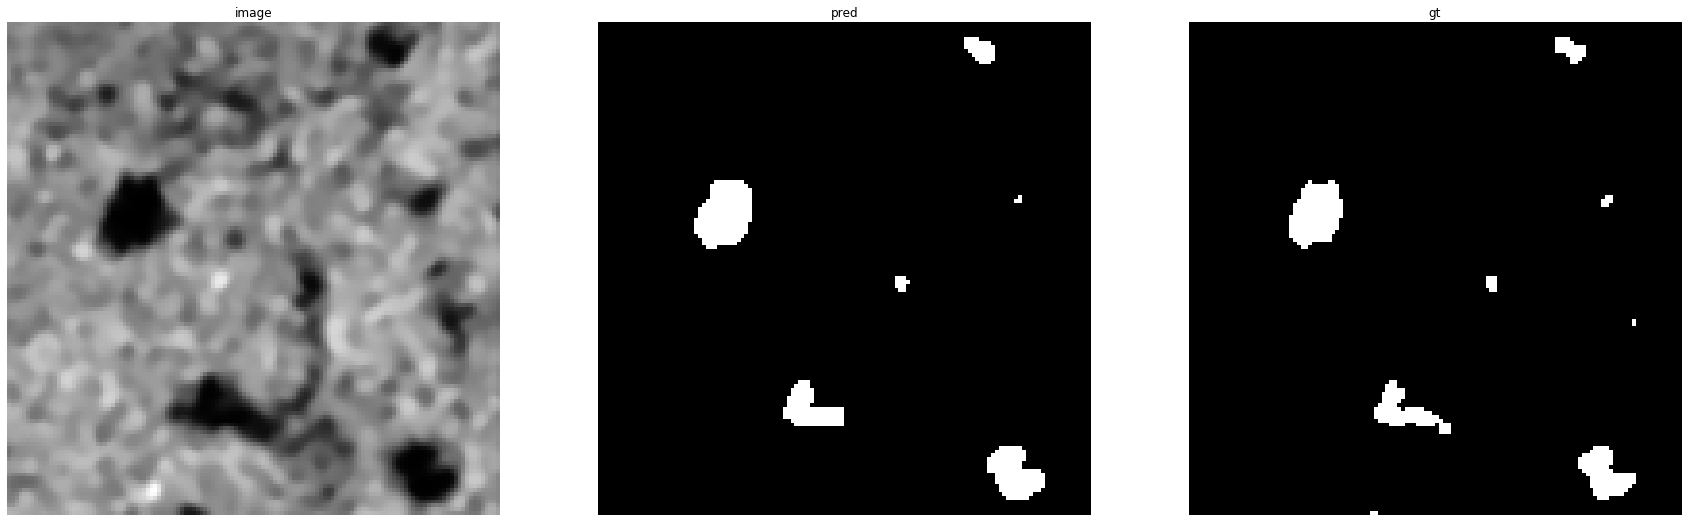

accuracy    : 0.9945068359375
precision   : 0.8689788053949904
recall      : 0.9534883720930233
f1          : 0.9092741935483871
pr_auc      : 0.9829029015323224
iou         : 0.833641404805915


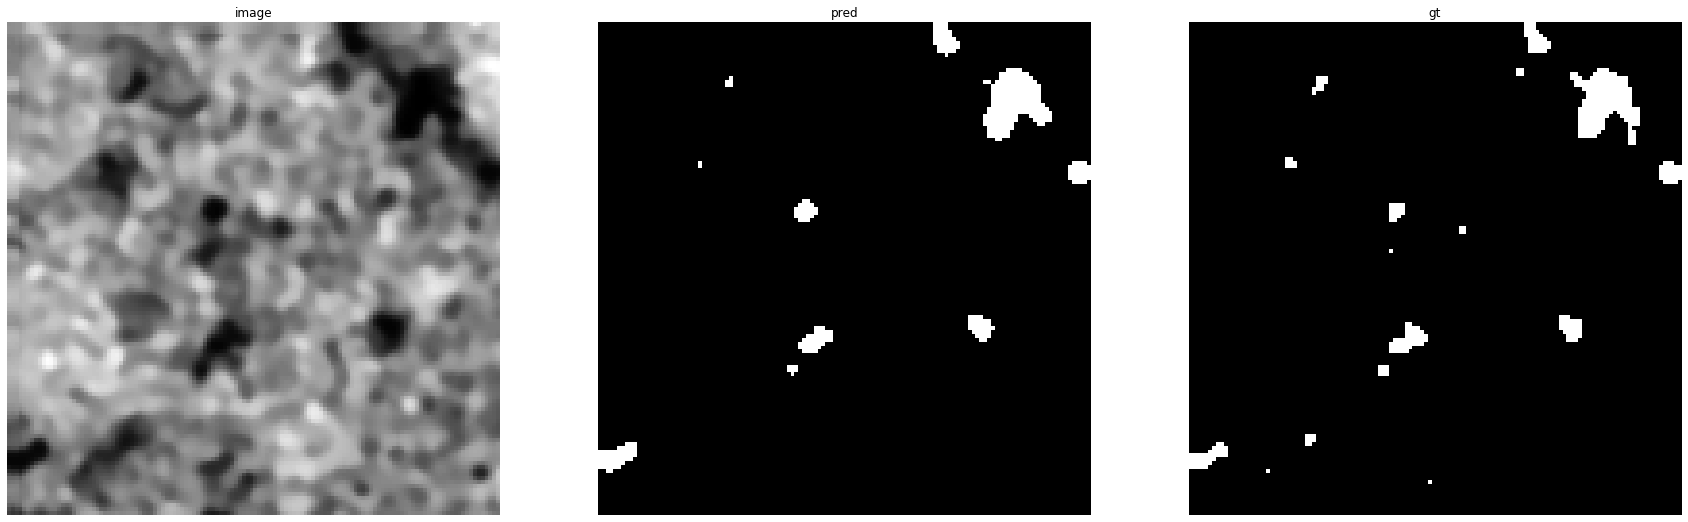

accuracy    : 0.99310302734375
precision   : 0.8859060402684564
recall      : 0.8646288209606987
f1          : 0.8751381215469614
pr_auc      : 0.9545114463434624
iou         : 0.7779960707269156


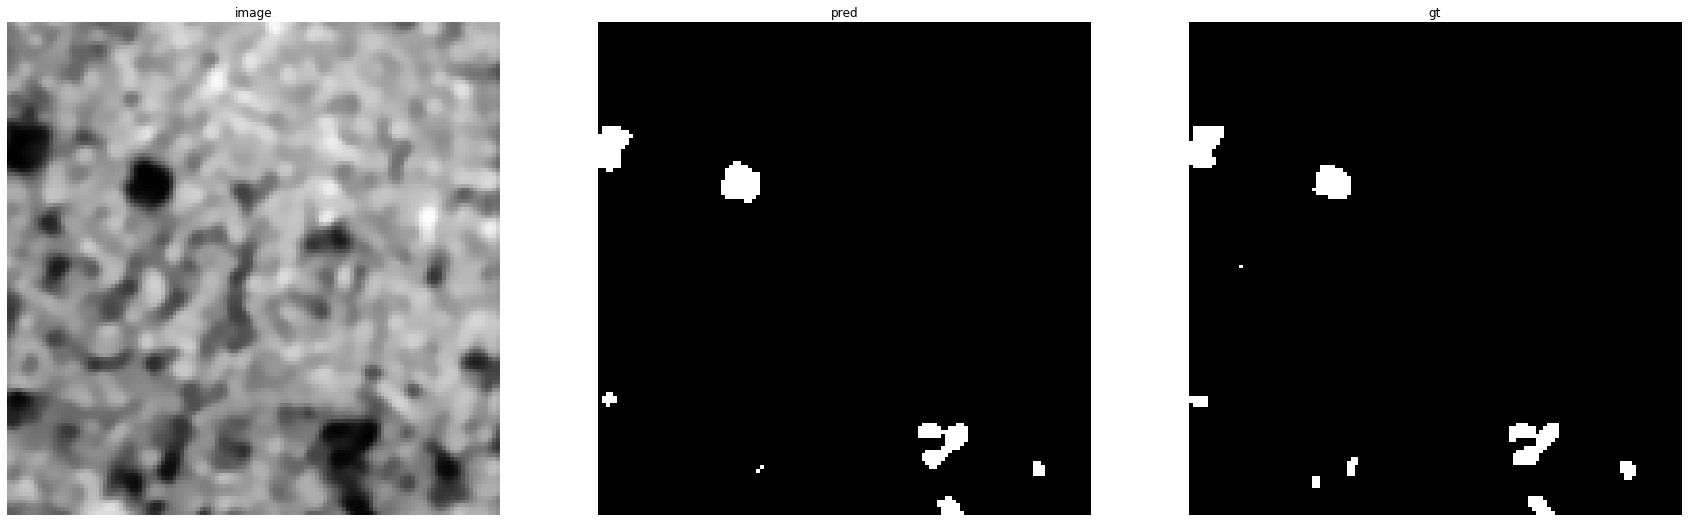

accuracy    : 0.9954833984375
precision   : 0.896551724137931
recall      : 0.8552631578947368
f1          : 0.8754208754208755
pr_auc      : 0.9679470517633103
iou         : 0.7784431137724551


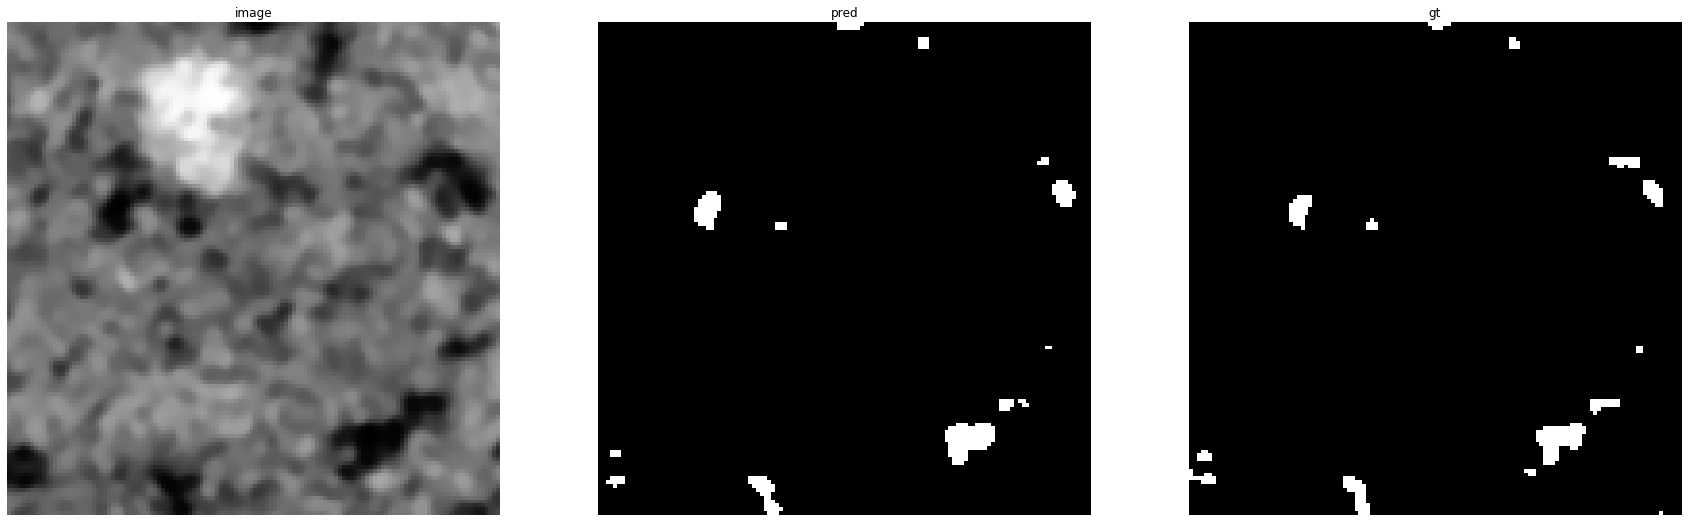

accuracy    : 0.9945068359375
precision   : 0.8421052631578947
recall      : 0.8421052631578947
f1          : 0.8421052631578947
pr_auc      : 0.9322847337540184
iou         : 0.7272727272727273


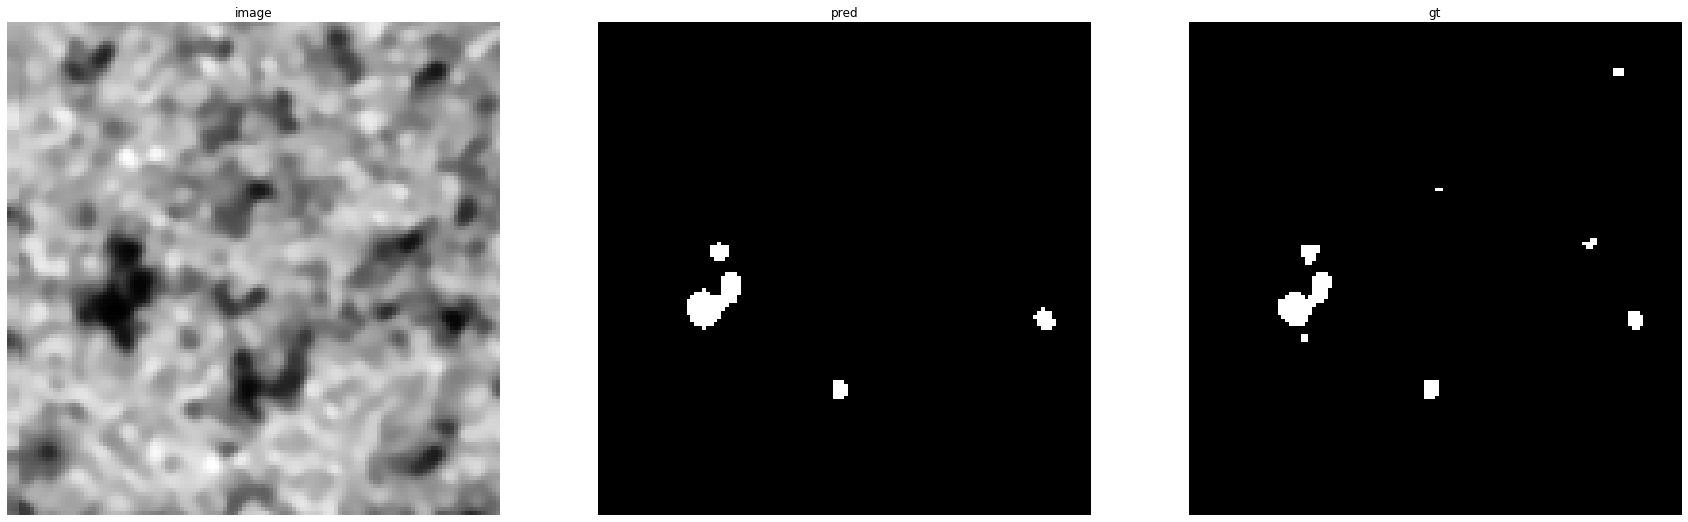

accuracy    : 0.997314453125
precision   : 0.8757396449704142
recall      : 0.8654970760233918
f1          : 0.8705882352941177
pr_auc      : 0.9476135494594025
iou         : 0.7708333333333334


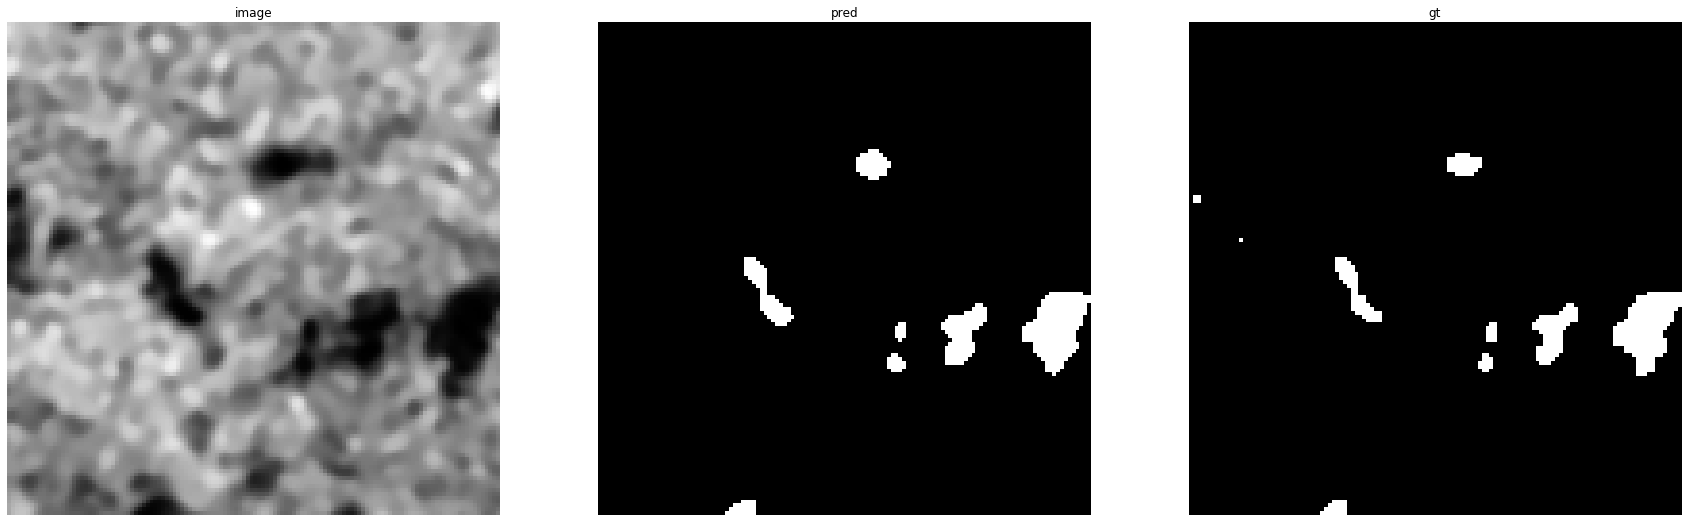

accuracy    : 0.99560546875
precision   : 0.8985239852398524
recall      : 0.9662698412698413
f1          : 0.9311663479923518
pr_auc      : 0.9856532309841161
iou         : 0.8711985688729875
SoilB-2


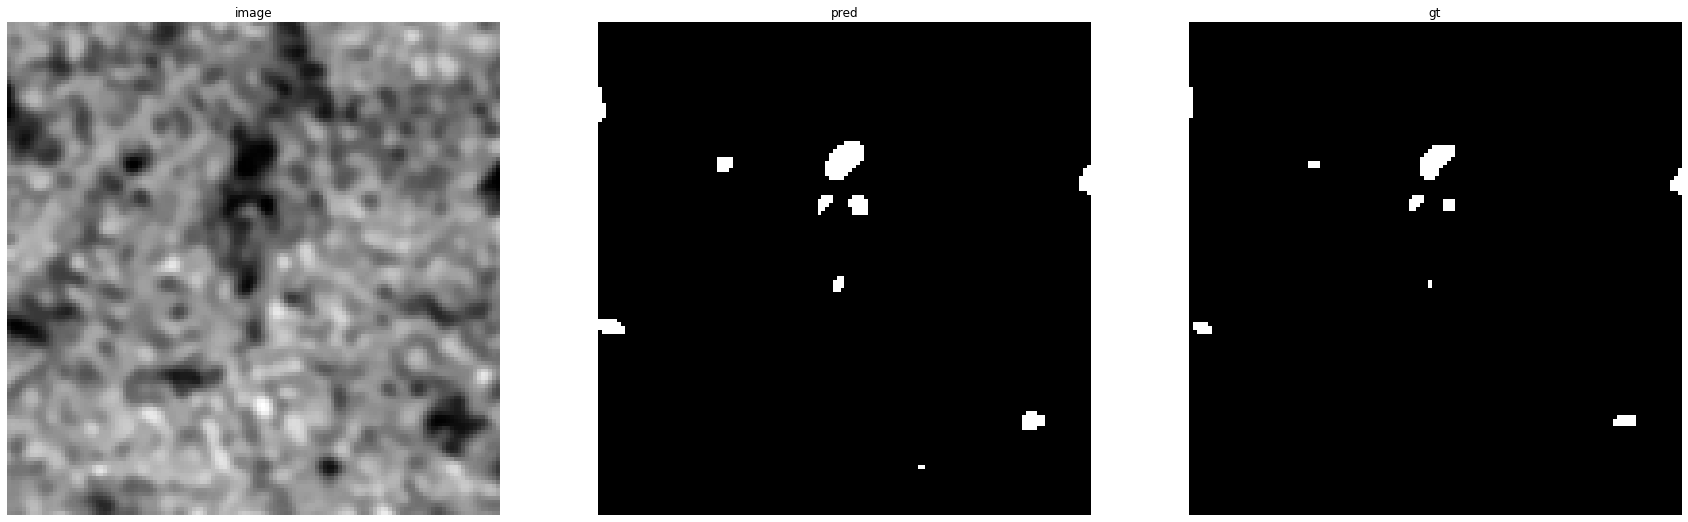

accuracy    : 0.995361328125
precision   : 0.6415094339622641
recall      : 1.0
f1          : 0.7816091954022989
pr_auc      : 0.9650388751166677
iou         : 0.6415094339622641


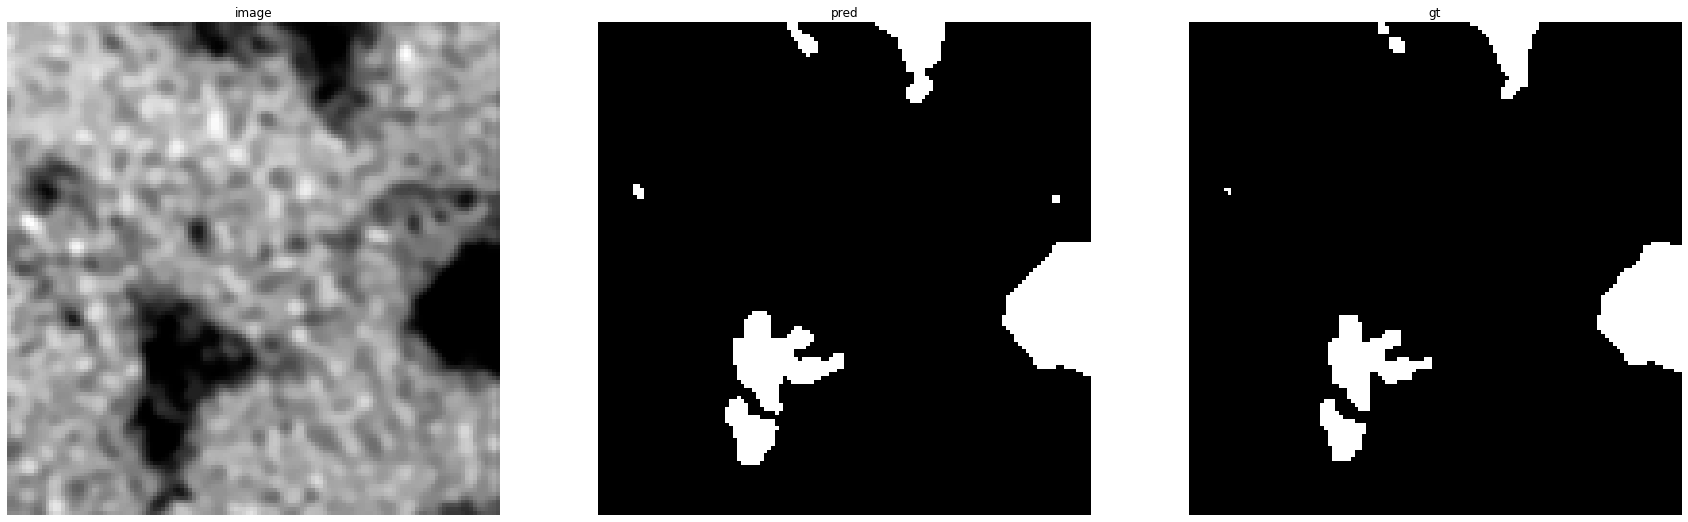

accuracy    : 0.9881591796875
precision   : 0.8652694610778443
recall      : 0.9880341880341881
f1          : 0.922585794094174
pr_auc      : 0.9951379059720982
iou         : 0.8562962962962963


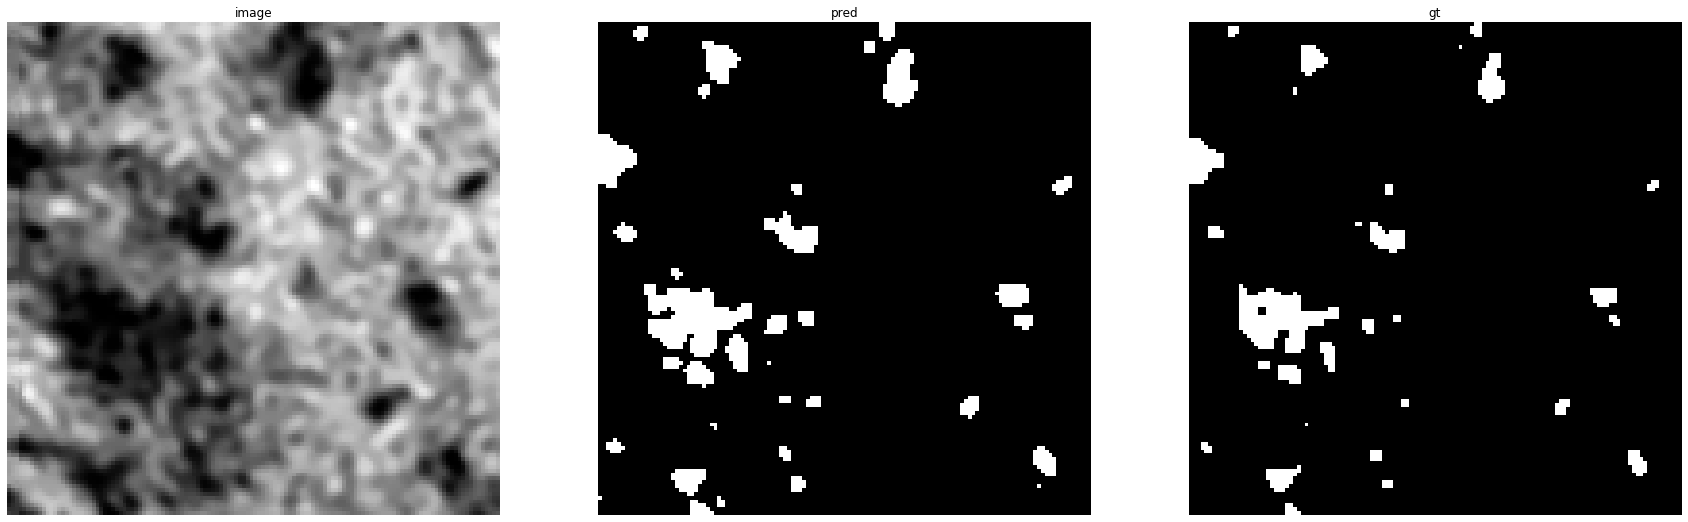

accuracy    : 0.97576904296875
precision   : 0.6550179211469535
recall      : 0.9838492597577388
f1          : 0.7864443249058634
pr_auc      : 0.9715957870334427
iou         : 0.6480496453900709


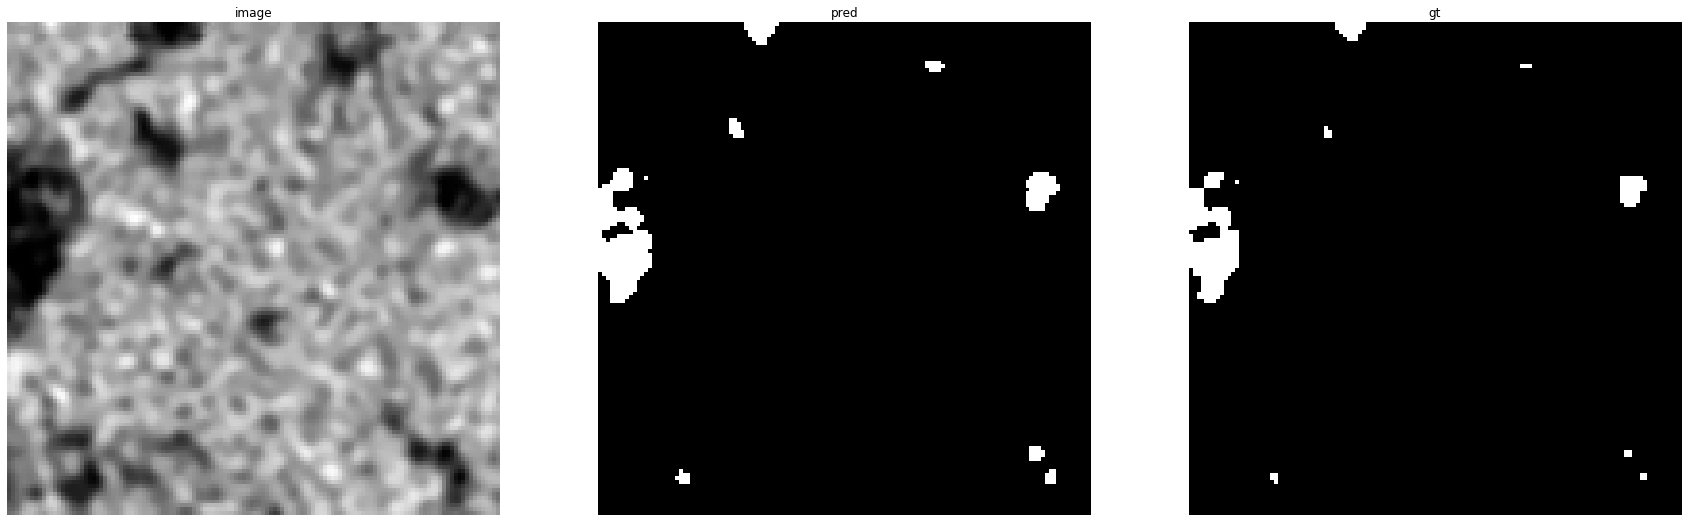

accuracy    : 0.992919921875
precision   : 0.7628205128205128
recall      : 0.9861878453038674
f1          : 0.8602409638554216
pr_auc      : 0.9834657901338308
iou         : 0.7547568710359408


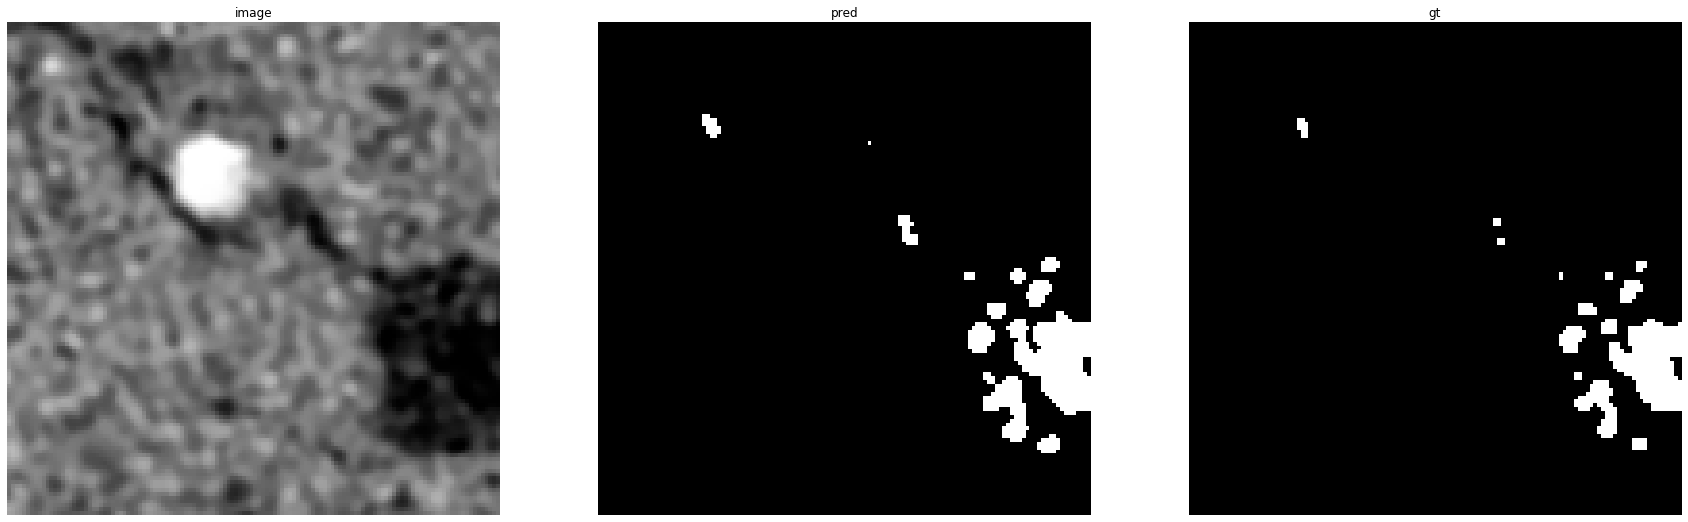

accuracy    : 0.99066162109375
precision   : 0.775330396475771
recall      : 1.0
f1          : 0.8734491315136477
pr_auc      : 0.9922250689908227
iou         : 0.775330396475771


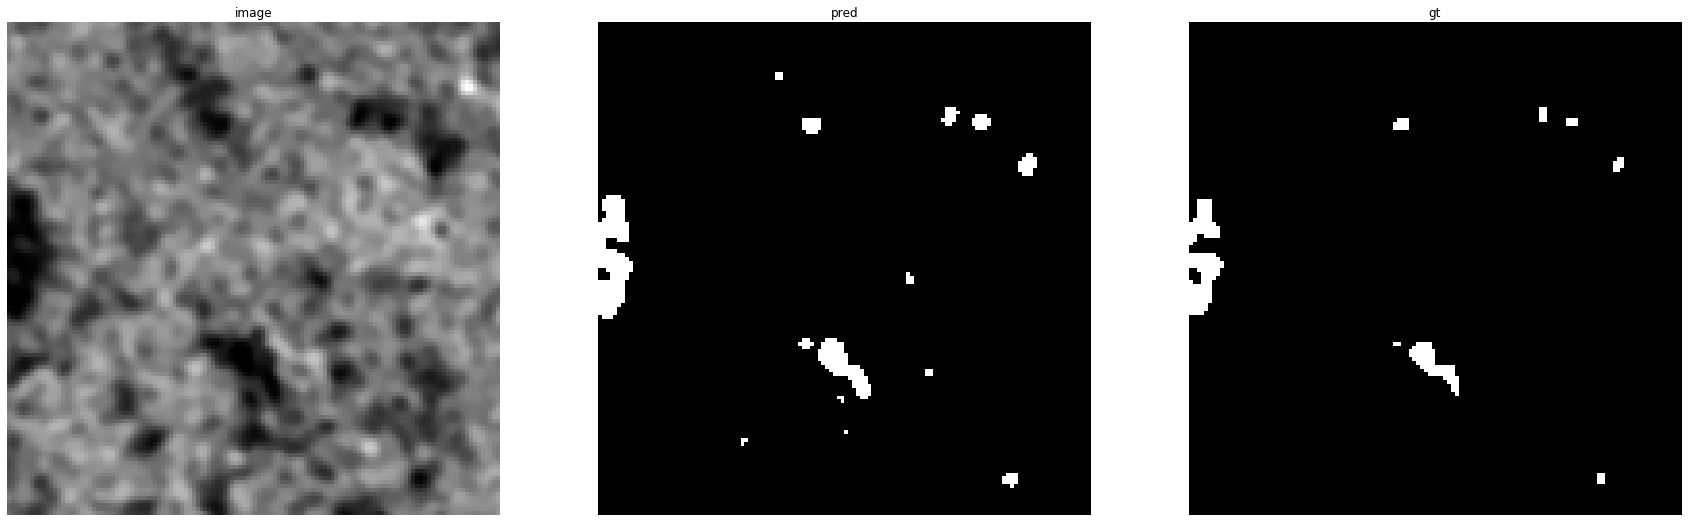

accuracy    : 0.99151611328125
precision   : 0.6575682382133995
recall      : 0.9962406015037594
f1          : 0.7922272047832586
pr_auc      : 0.9801994132054942
iou         : 0.655940594059406


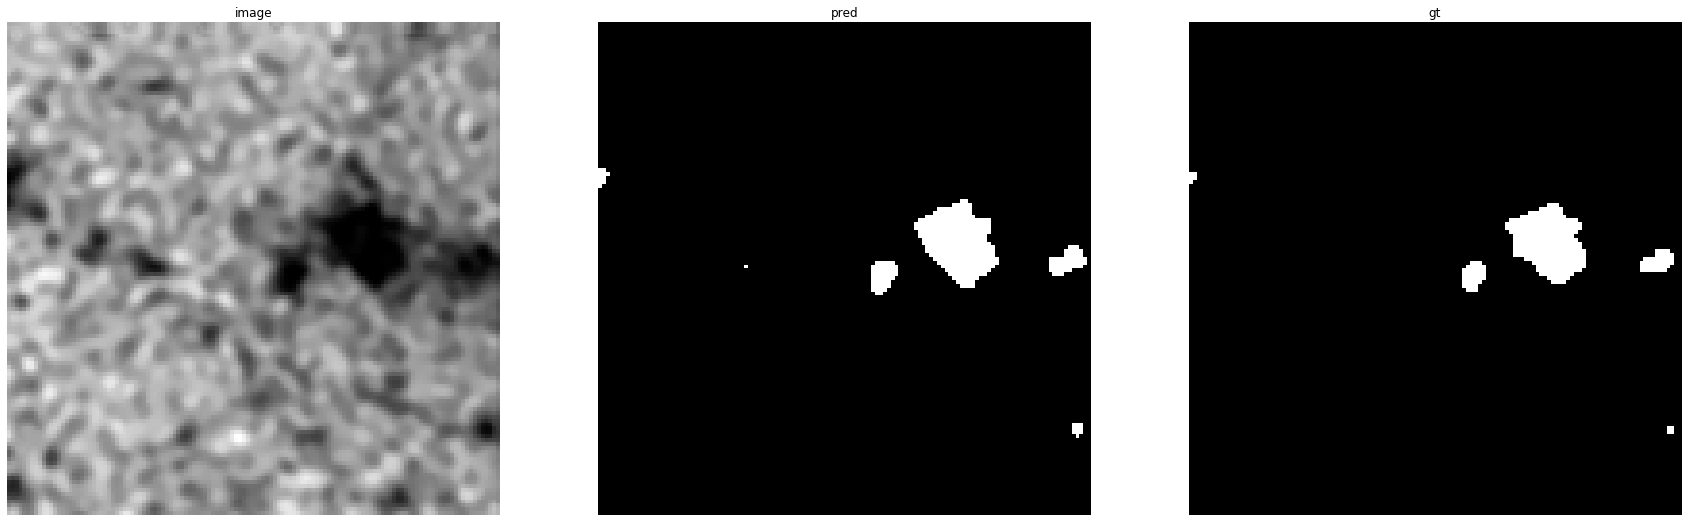

accuracy    : 0.99615478515625
precision   : 0.8644859813084113
recall      : 0.9866666666666667
f1          : 0.9215442092154421
pr_auc      : 0.9923475395912658
iou         : 0.8545034642032333


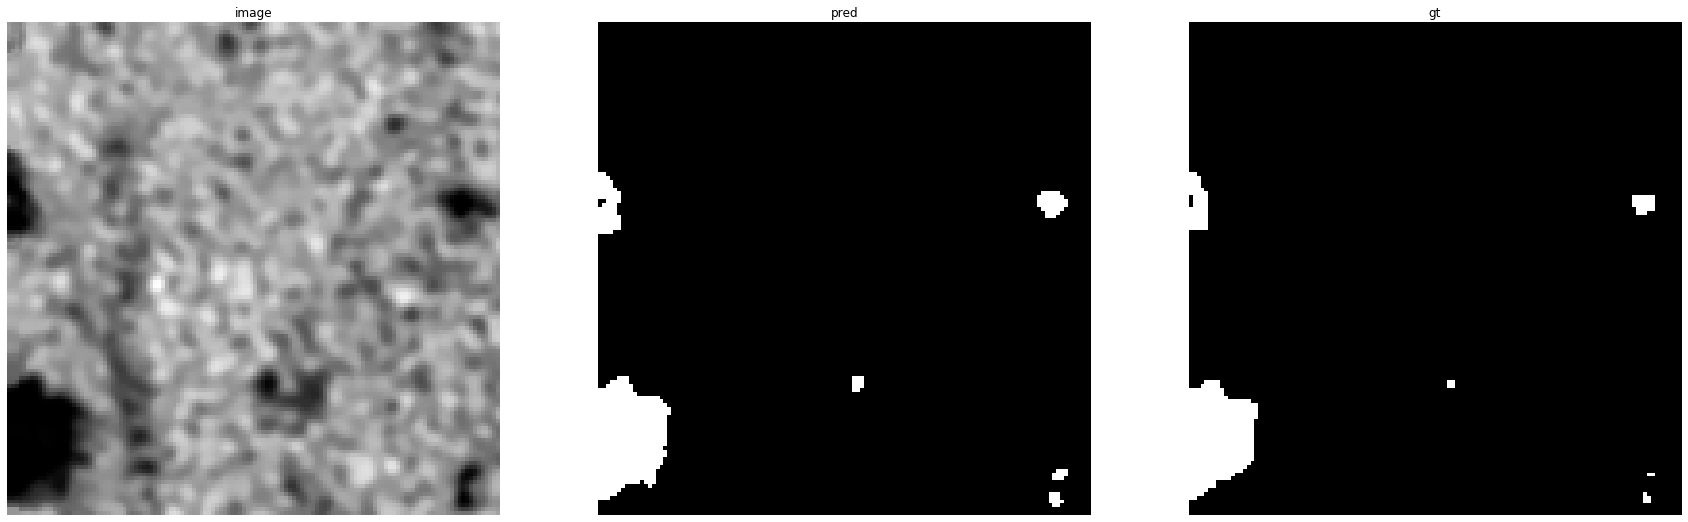

accuracy    : 0.99395751953125
precision   : 0.8369384359400999
recall      : 0.998015873015873
f1          : 0.9104072398190045
pr_auc      : 0.9977602002228616
iou         : 0.8355481727574751


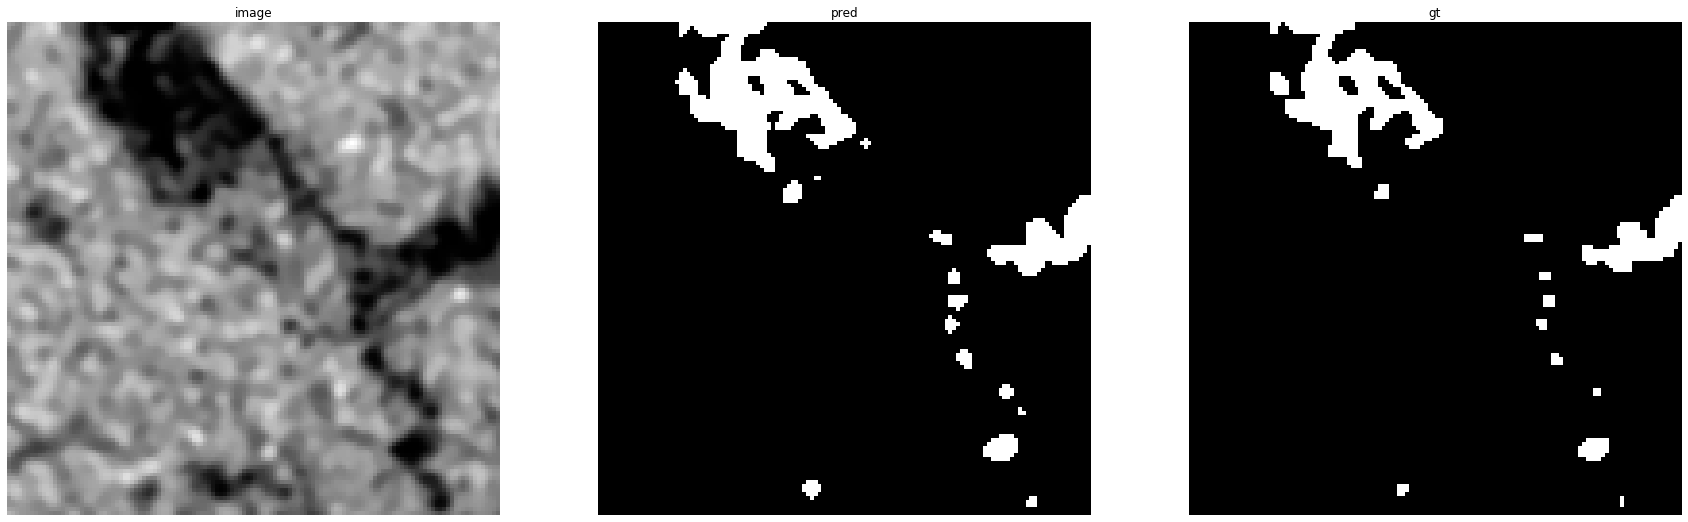

accuracy    : 0.986572265625
precision   : 0.822866344605475
recall      : 1.0
f1          : 0.9028268551236749
pr_auc      : 0.995841311106491
iou         : 0.822866344605475


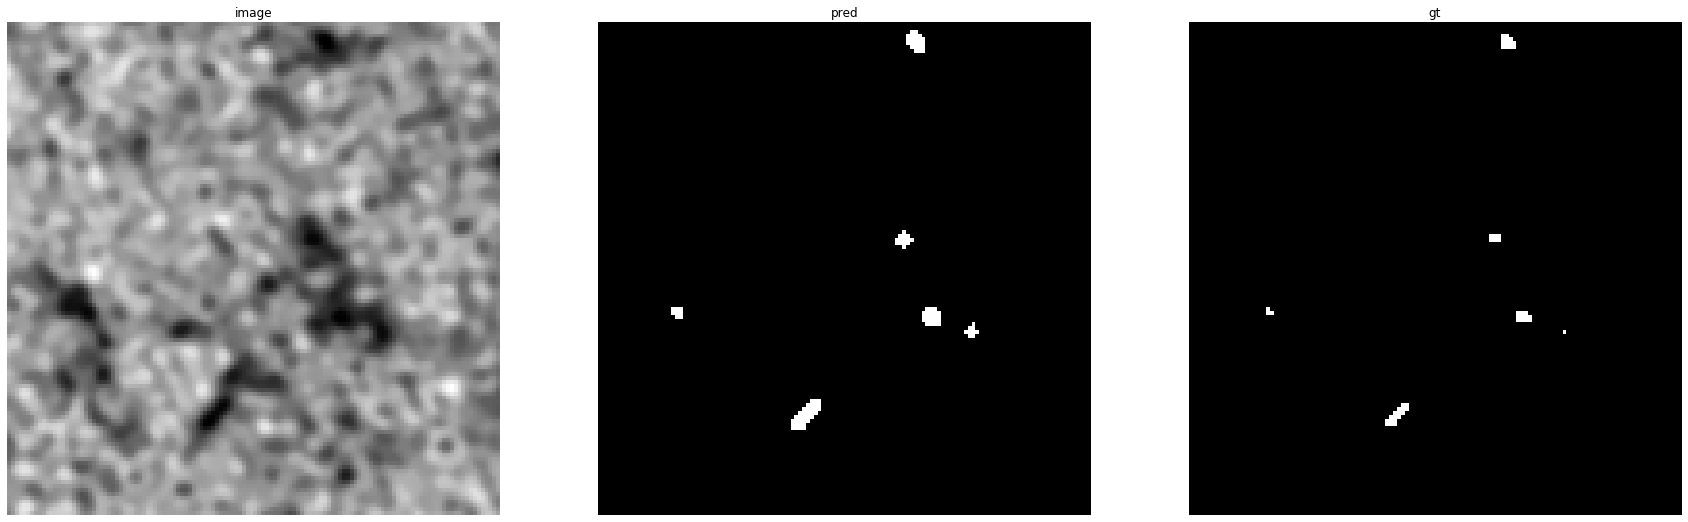

accuracy    : 0.996337890625
precision   : 0.4594594594594595
recall      : 1.0
f1          : 0.6296296296296297
pr_auc      : 0.9760261540647659
iou         : 0.4594594594594595
TeTree_subset1


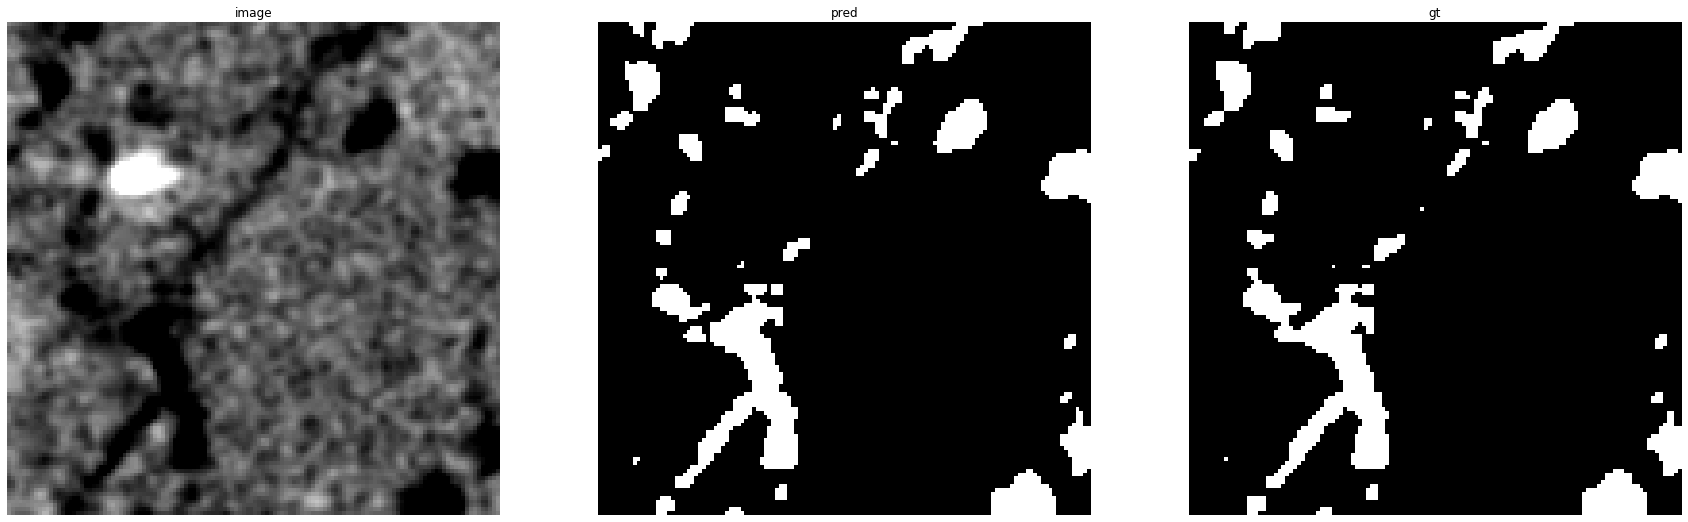

accuracy    : 0.99066162109375
precision   : 0.9784702549575071
recall      : 0.9375678610206297
f1          : 0.9575824785140005
pr_auc      : 0.9932832151285833
iou         : 0.9186170212765957


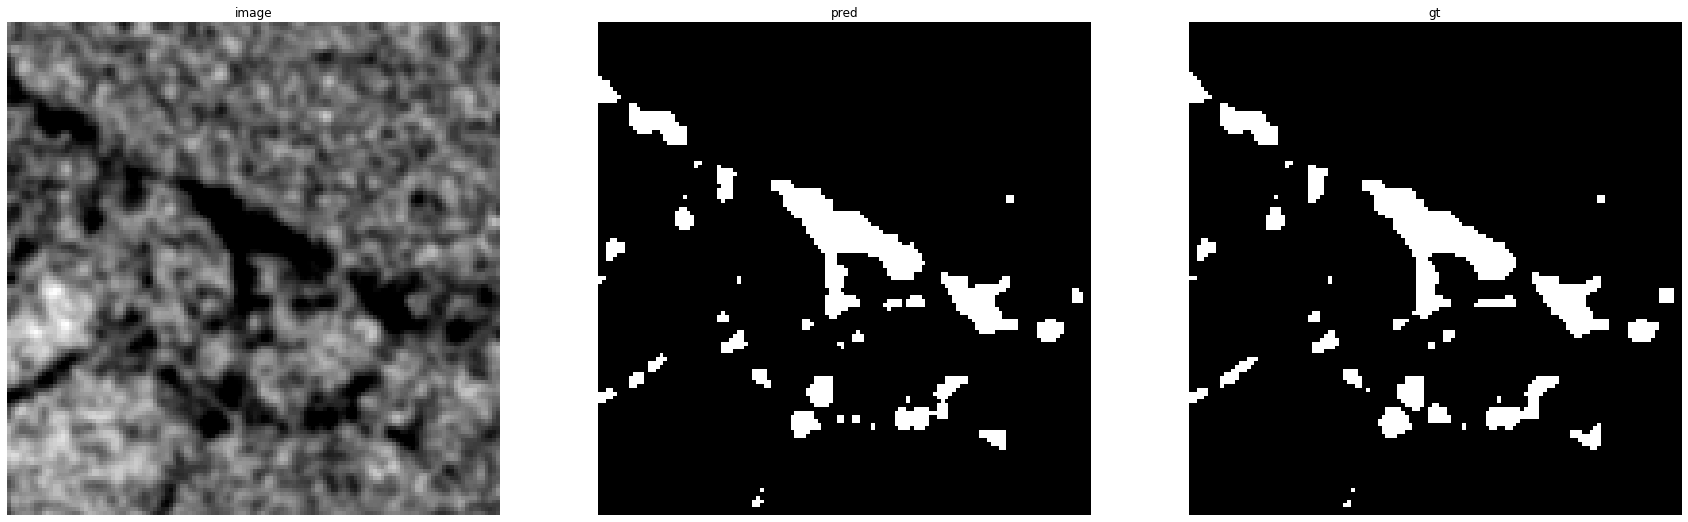

accuracy    : 0.99163818359375
precision   : 0.9823434991974318
recall      : 0.9141150112023898
f1          : 0.9470019342359768
pr_auc      : 0.9922435146482924
iou         : 0.899338721528288


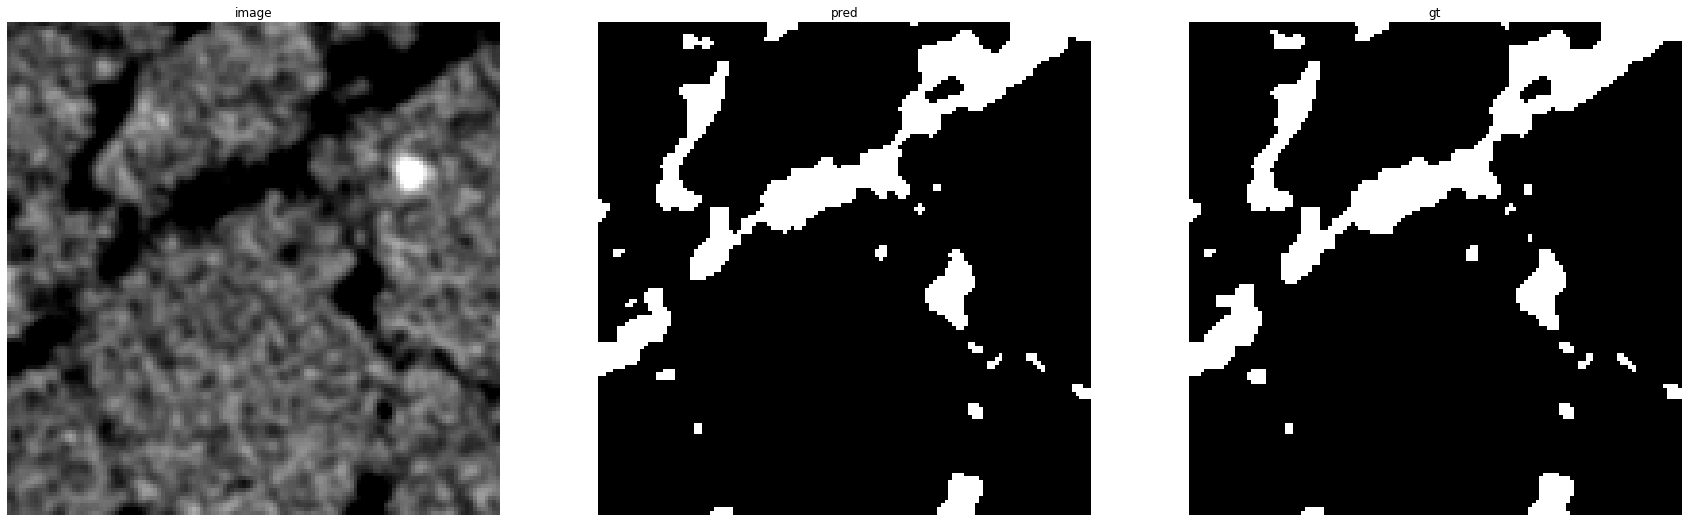

accuracy    : 0.98895263671875
precision   : 0.9957786116322702
recall      : 0.9250544662309368
f1          : 0.9591145245086967
pr_auc      : 0.9974149097021019
iou         : 0.9214409722222222


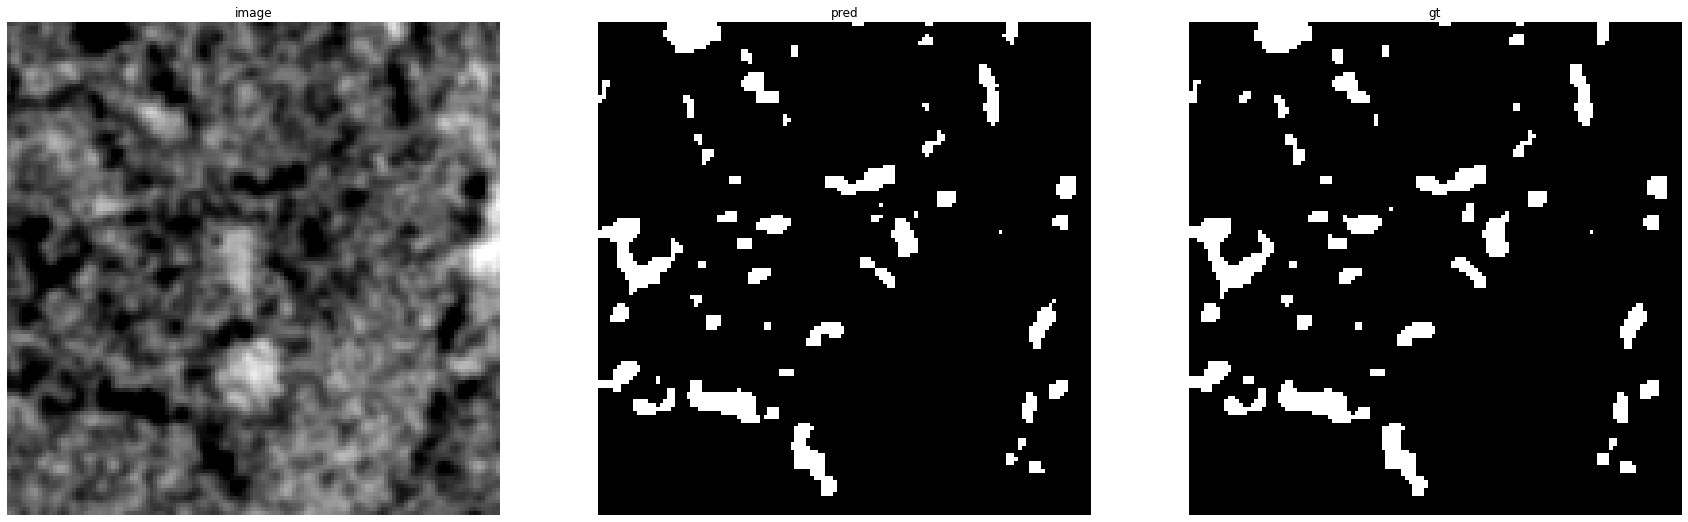

accuracy    : 0.98974609375
precision   : 0.9815852682145717
recall      : 0.8942377826404084
f1          : 0.9358778625954198
pr_auc      : 0.9899868990477887
iou         : 0.8794835007173601


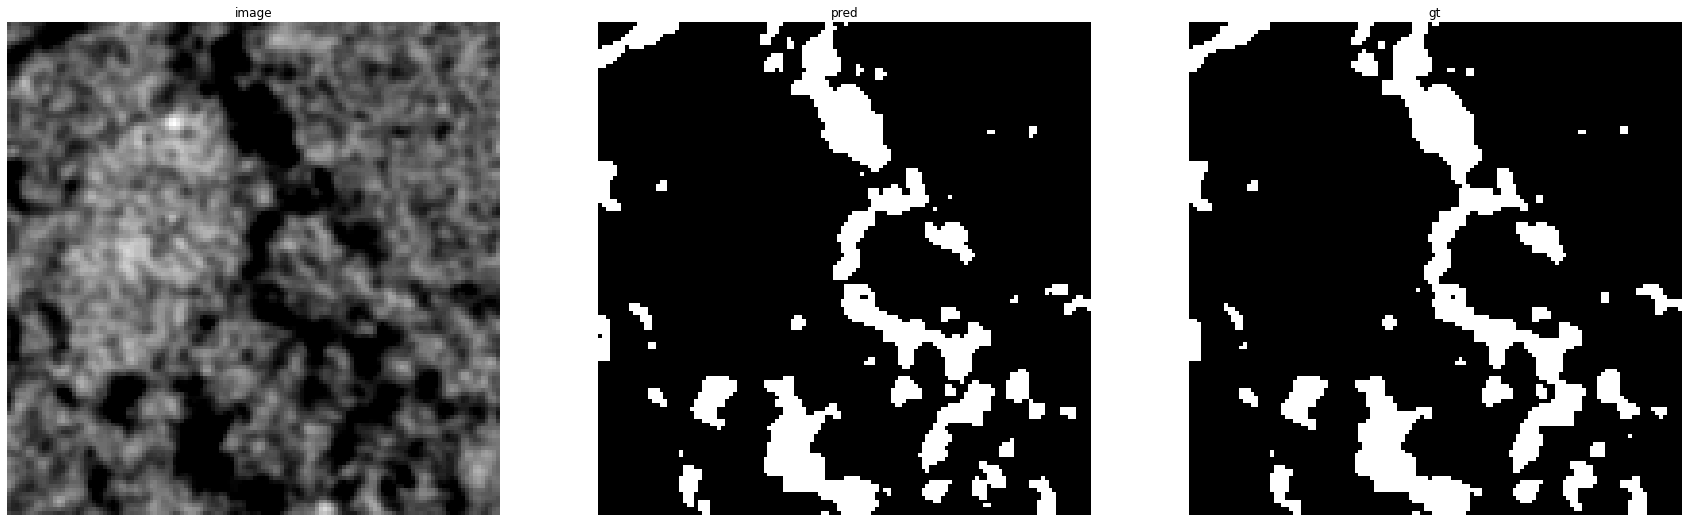

accuracy    : 0.9849853515625
precision   : 0.980327868852459
recall      : 0.9235521235521236
f1          : 0.9510934393638171
pr_auc      : 0.99429883612111
iou         : 0.9067475360121304


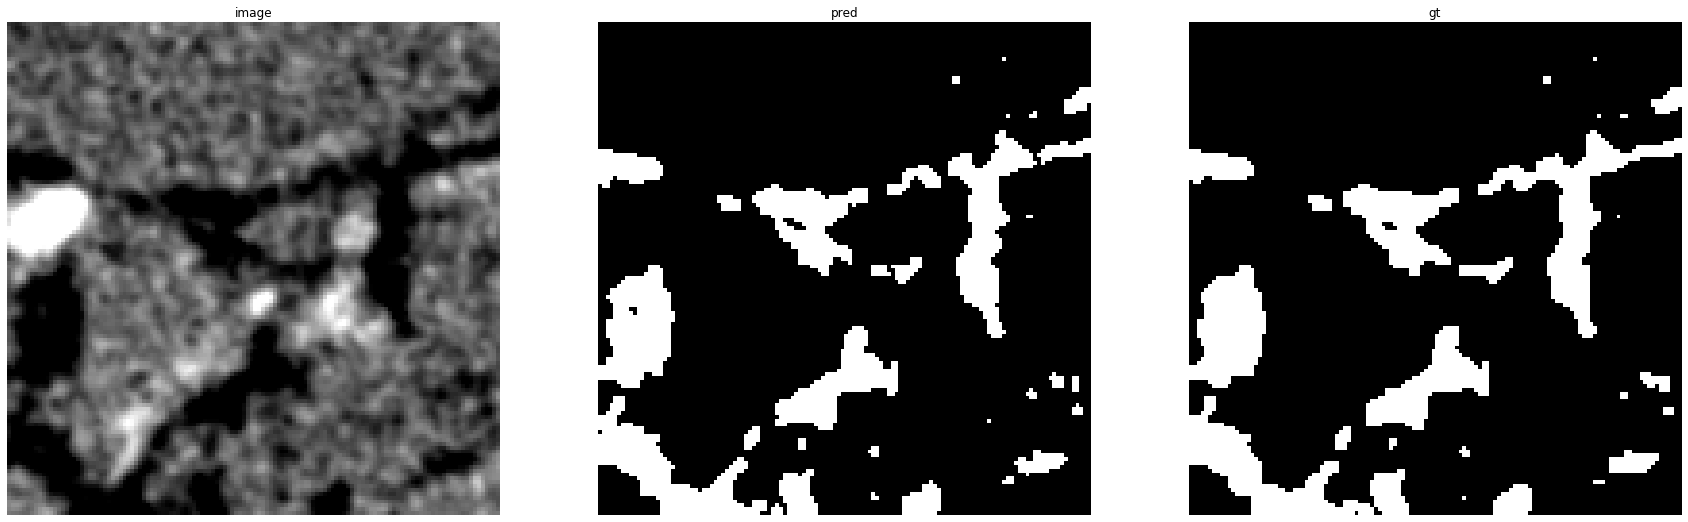

accuracy    : 0.9886474609375
precision   : 0.976805087916199
recall      : 0.9546617915904936
f1          : 0.9656065088757395
pr_auc      : 0.9968053188583164
iou         : 0.9335001787629603


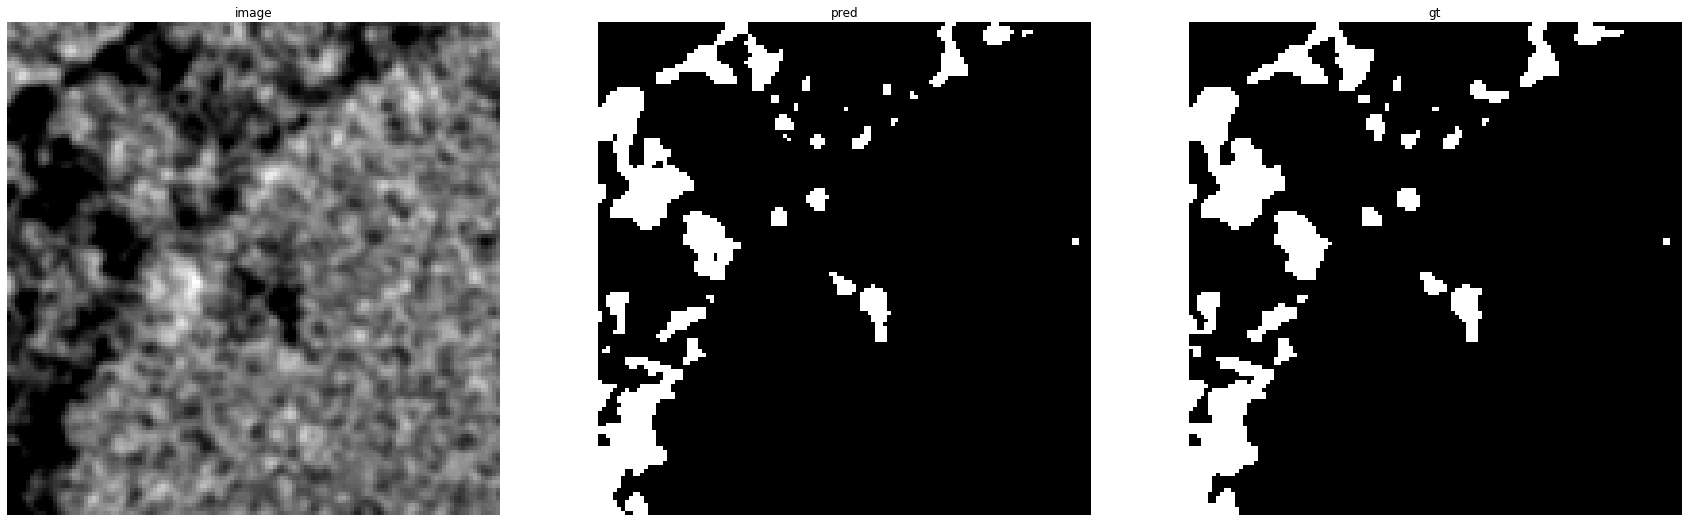

accuracy    : 0.98529052734375
precision   : 0.9912739965095986
recall      : 0.8829015544041451
f1          : 0.9339545080844066
pr_auc      : 0.9915074101186488
iou         : 0.8760925449871465


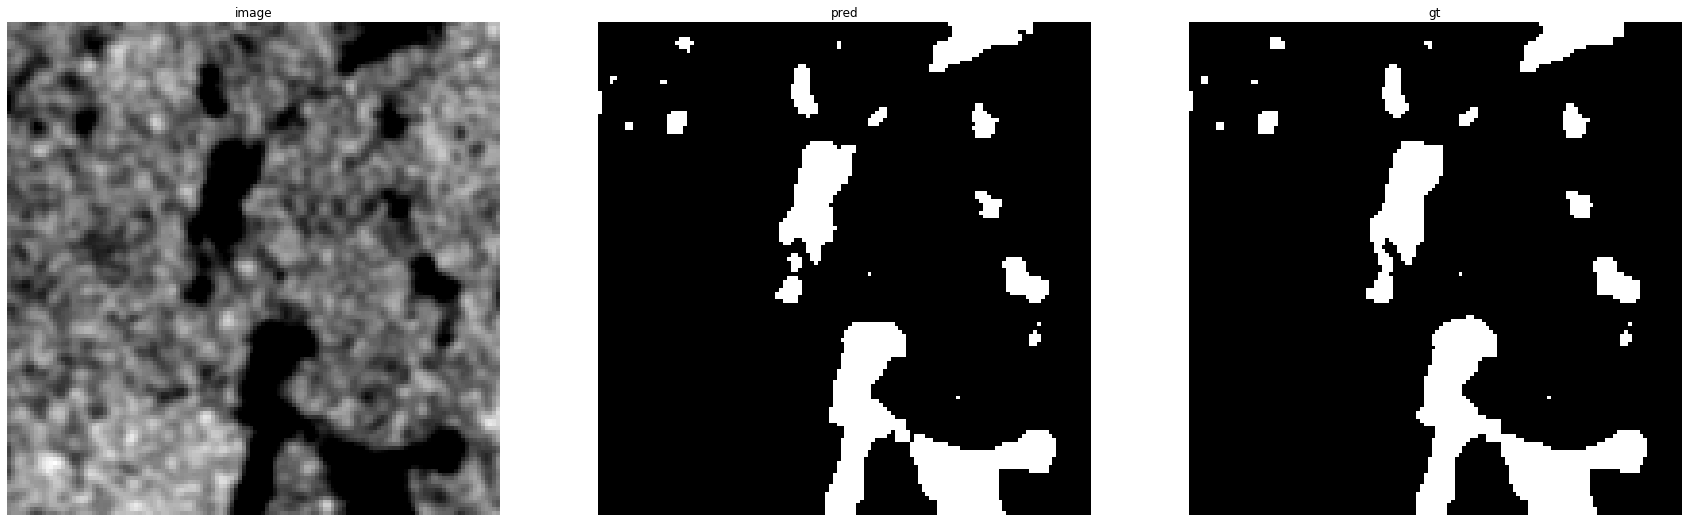

accuracy    : 0.99371337890625
precision   : 0.9933842239185751
recall      : 0.9559255631733594
f1          : 0.9742949837783879
pr_auc      : 0.9979554092727564
iou         : 0.9498783454987835


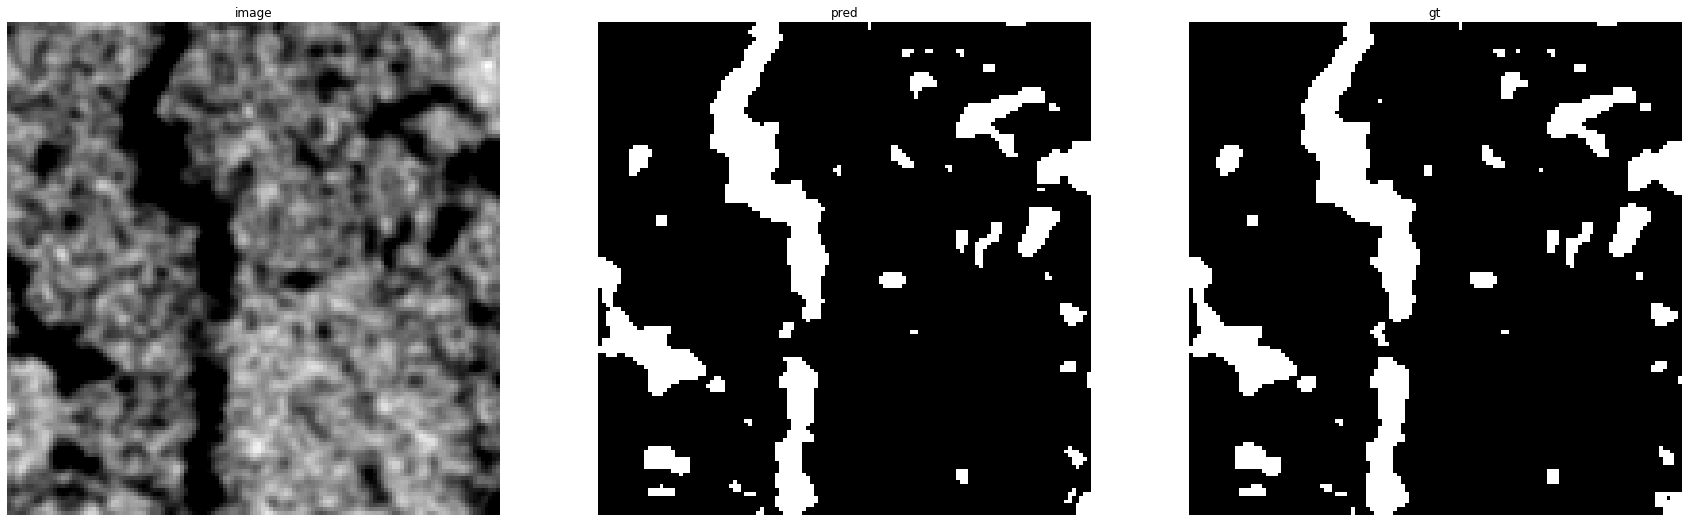

accuracy    : 0.98992919921875
precision   : 0.9881578947368421
recall      : 0.9422835633626098
f1          : 0.9646756583172769
pr_auc      : 0.9958903623901901
iou         : 0.9317617866004962


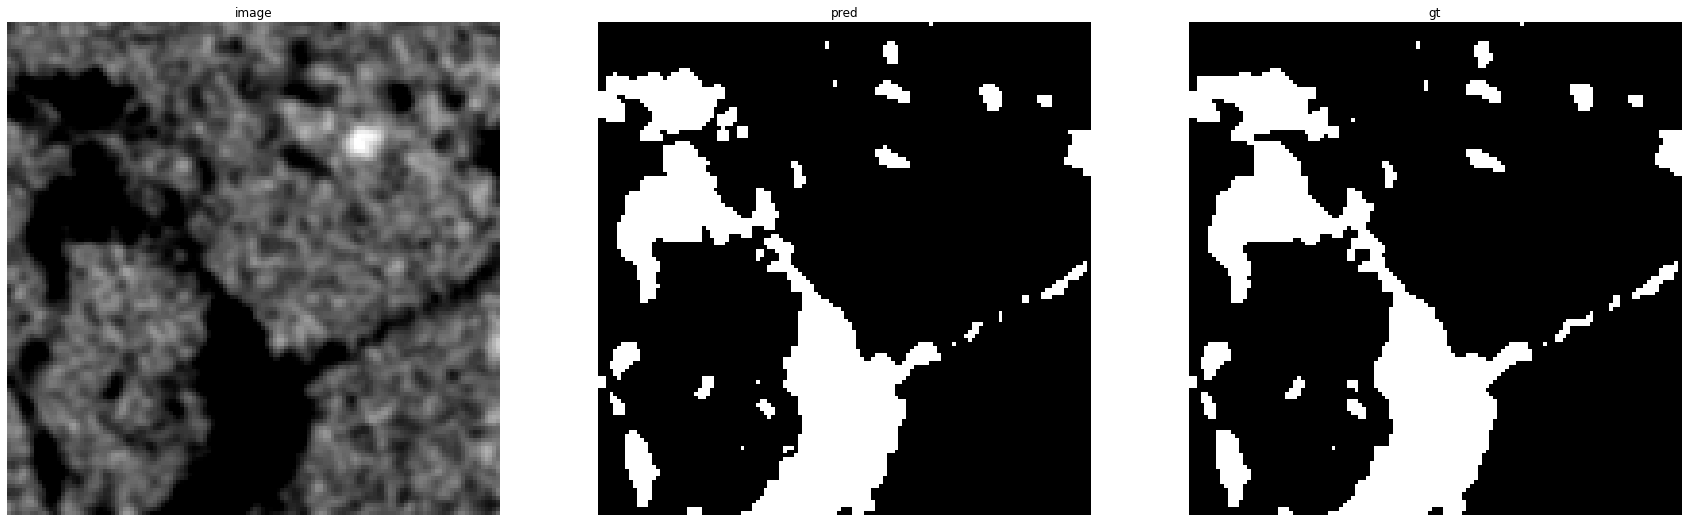

accuracy    : 0.986572265625
precision   : 0.9951314508276533
recall      : 0.9373280342402935
f1          : 0.9653652392947103
pr_auc      : 0.997613829599533
iou         : 0.9330493000608643
TiTree_subset2


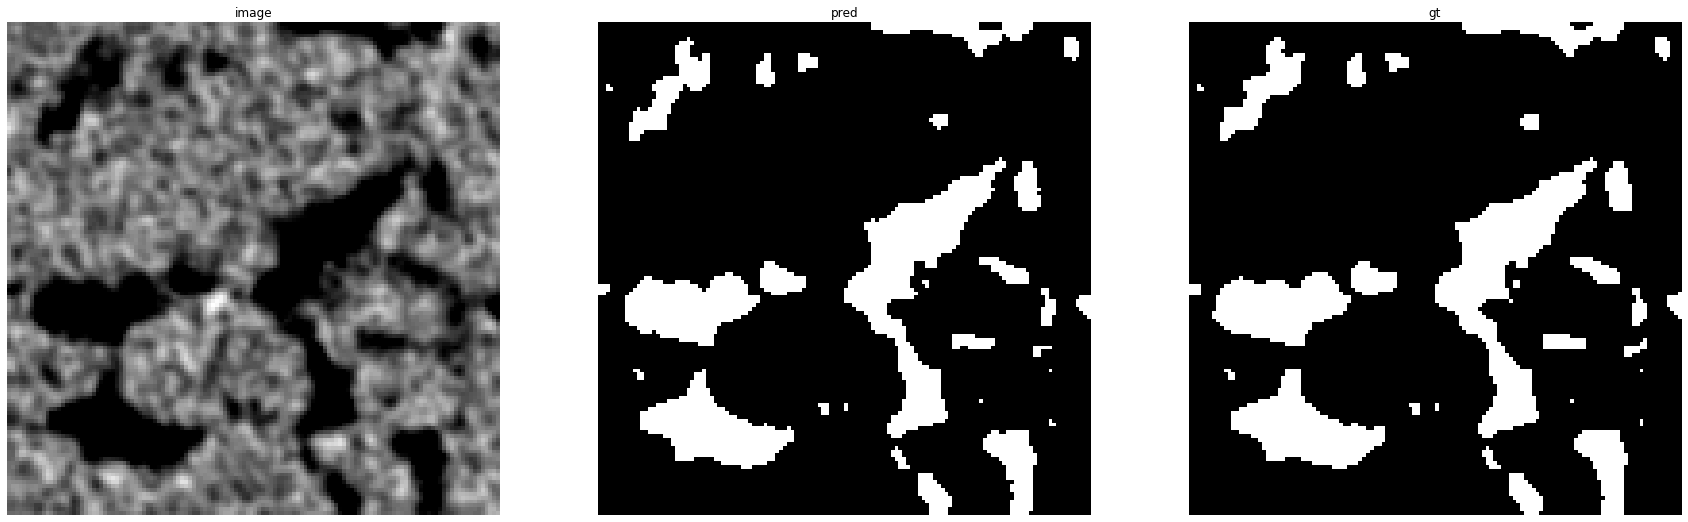

accuracy    : 0.98974609375
precision   : 0.9950213371266002
recall      : 0.9478319783197832
f1          : 0.970853573907009
pr_auc      : 0.9982431674951179
iou         : 0.9433580579905597


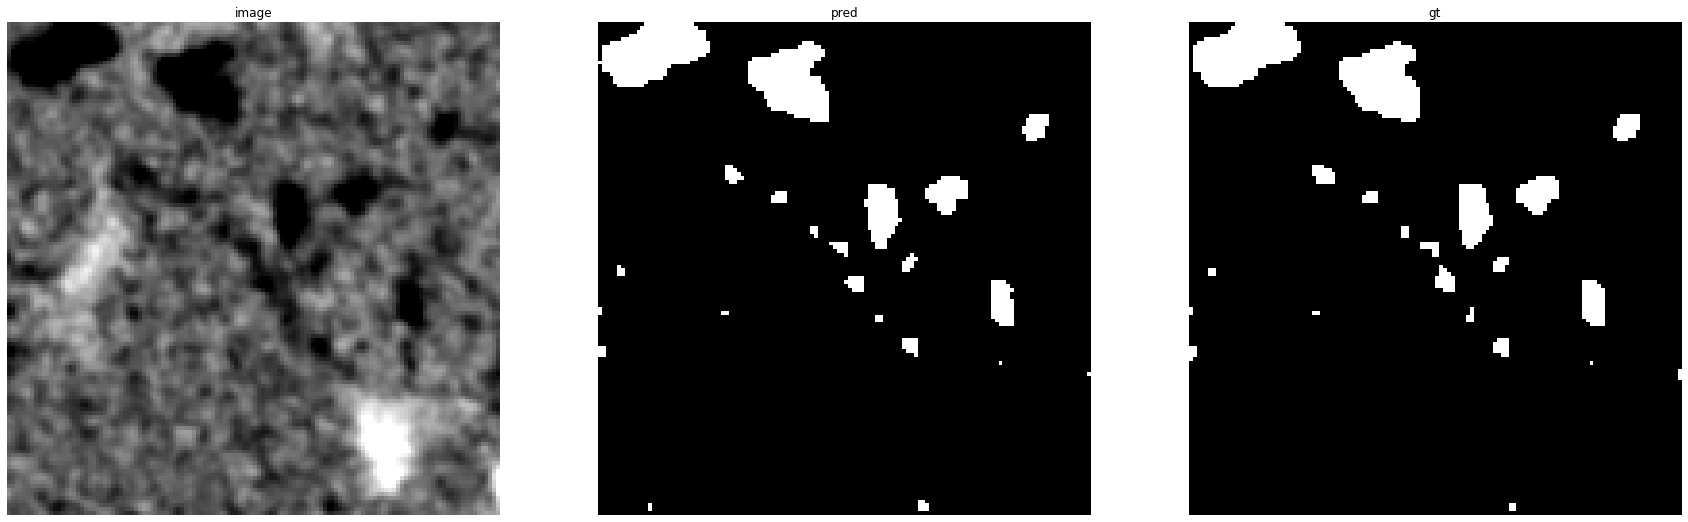

accuracy    : 0.9951171875
precision   : 0.9816425120772947
recall      : 0.9433611884865367
f1          : 0.9621212121212122
pr_auc      : 0.9967556016879277
iou         : 0.927007299270073


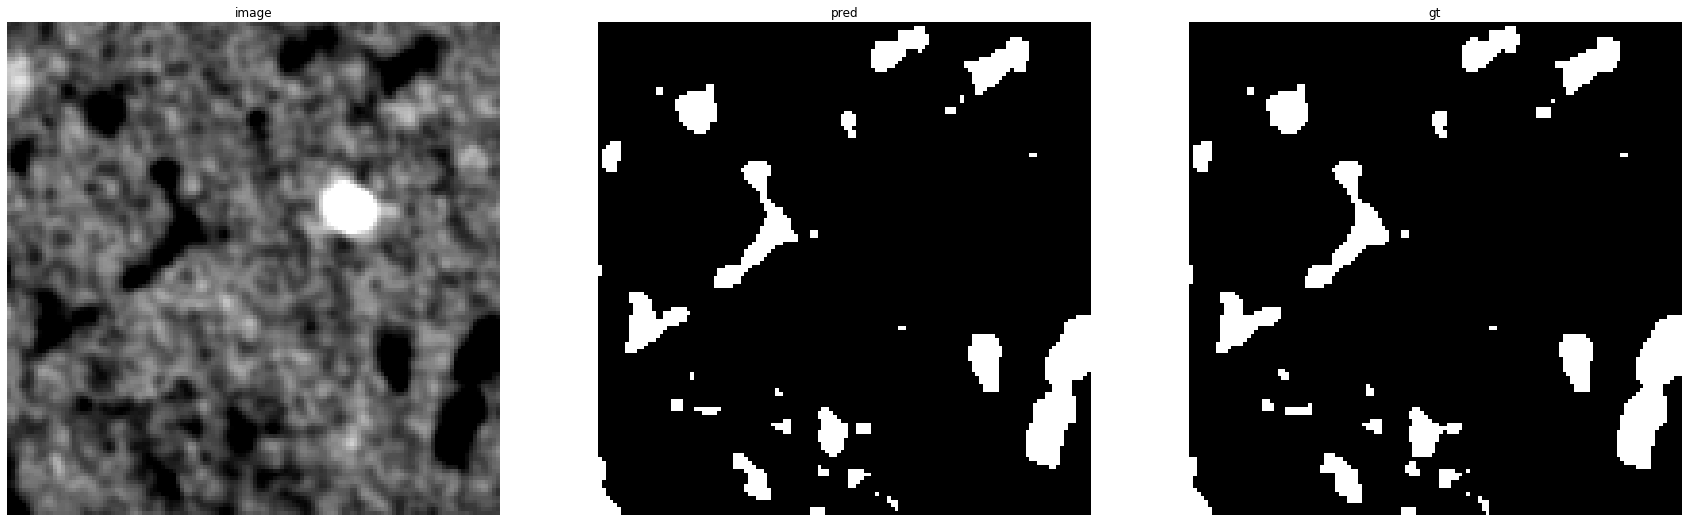

accuracy    : 0.9925537109375
precision   : 0.9931082012405238
recall      : 0.9278815196394076
f1          : 0.9593874833555259
pr_auc      : 0.9957890545404382
iou         : 0.9219449776071658


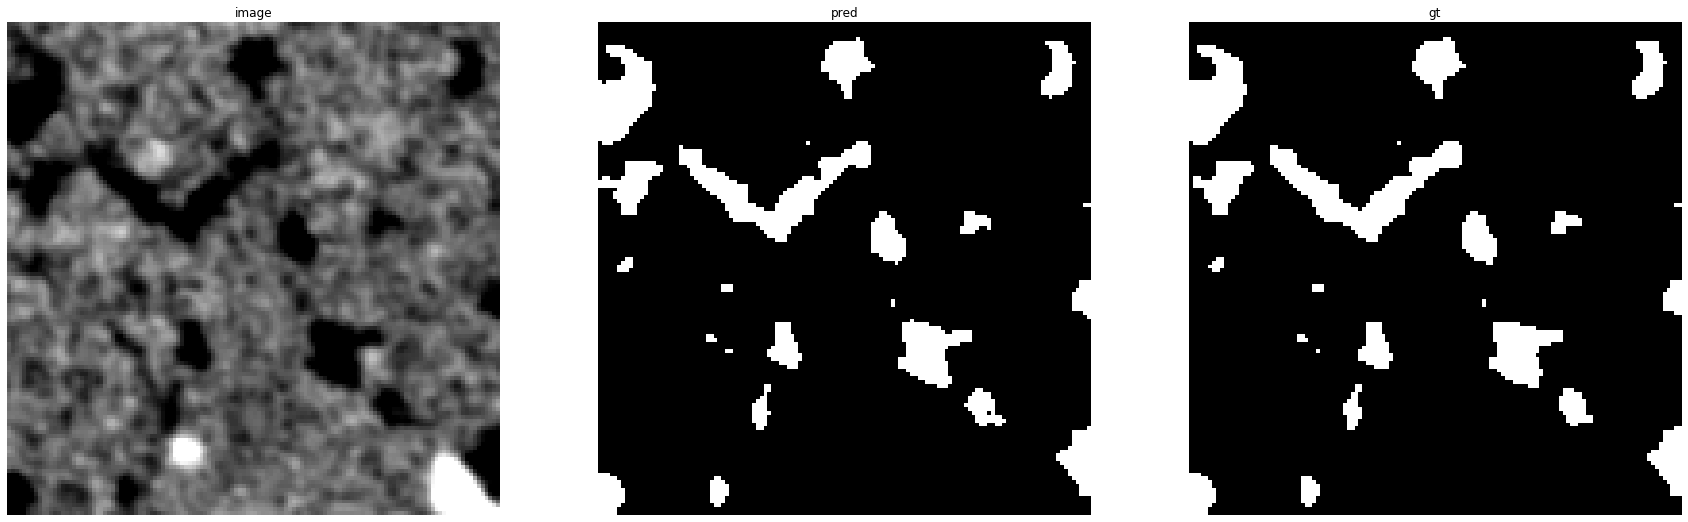

accuracy    : 0.99468994140625
precision   : 0.9886972040452112
recall      : 0.9606936416184971
f1          : 0.9744942832014072
pr_auc      : 0.9980226850827375
iou         : 0.9502572898799314


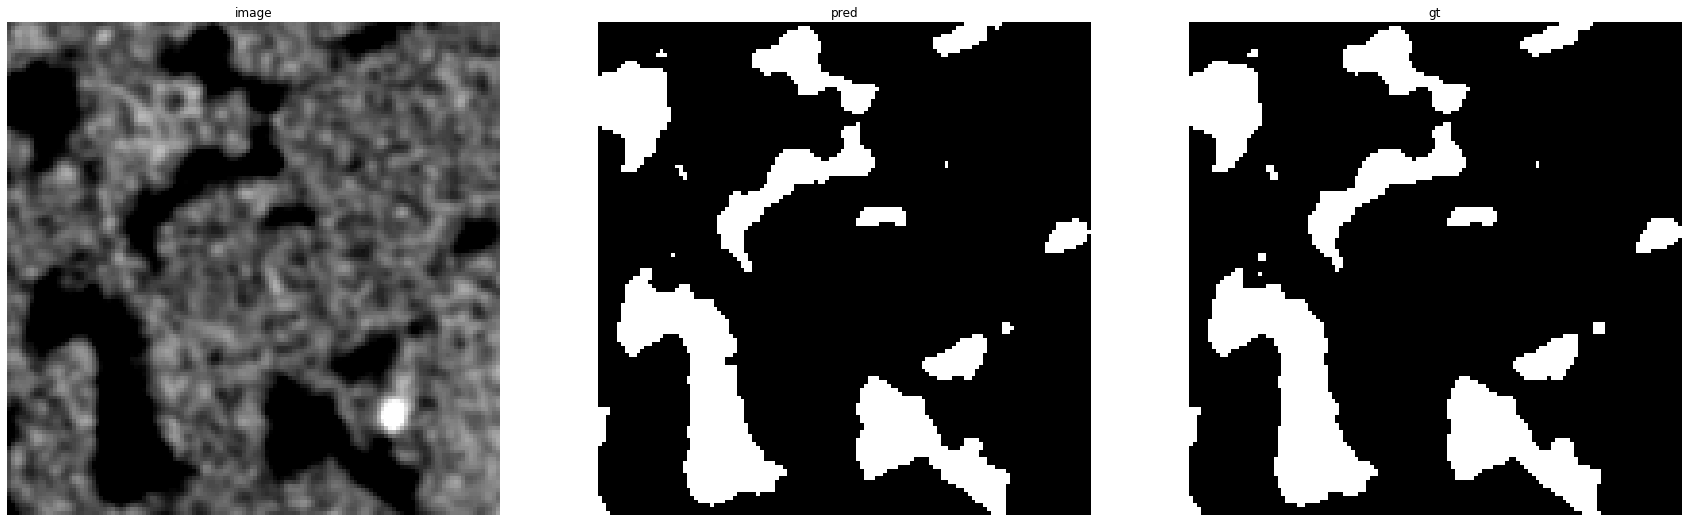

accuracy    : 0.99017333984375
precision   : 0.9961389961389961
recall      : 0.9540832049306626
f1          : 0.9746576420588697
pr_auc      : 0.9988753656730168
iou         : 0.9505680073687442


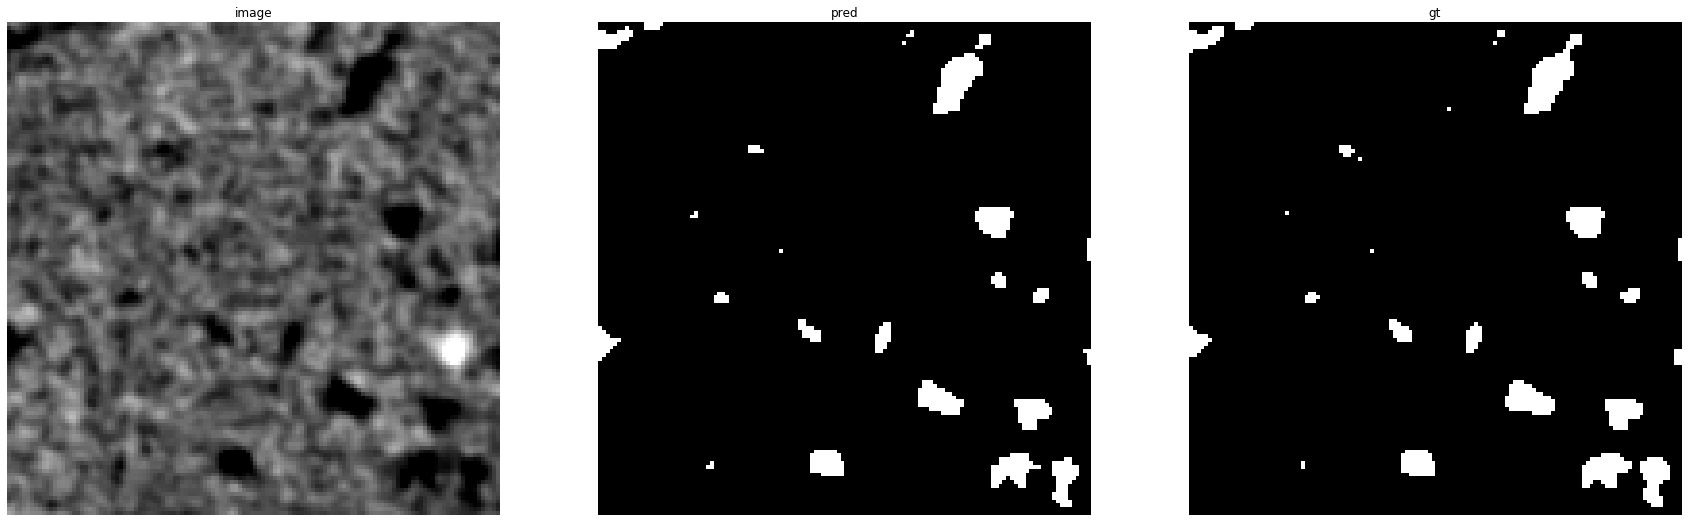

accuracy    : 0.9957275390625
precision   : 0.9912917271407837
recall      : 0.9143239625167336
f1          : 0.9512534818941505
pr_auc      : 0.9950258407939463
iou         : 0.9070385126162018


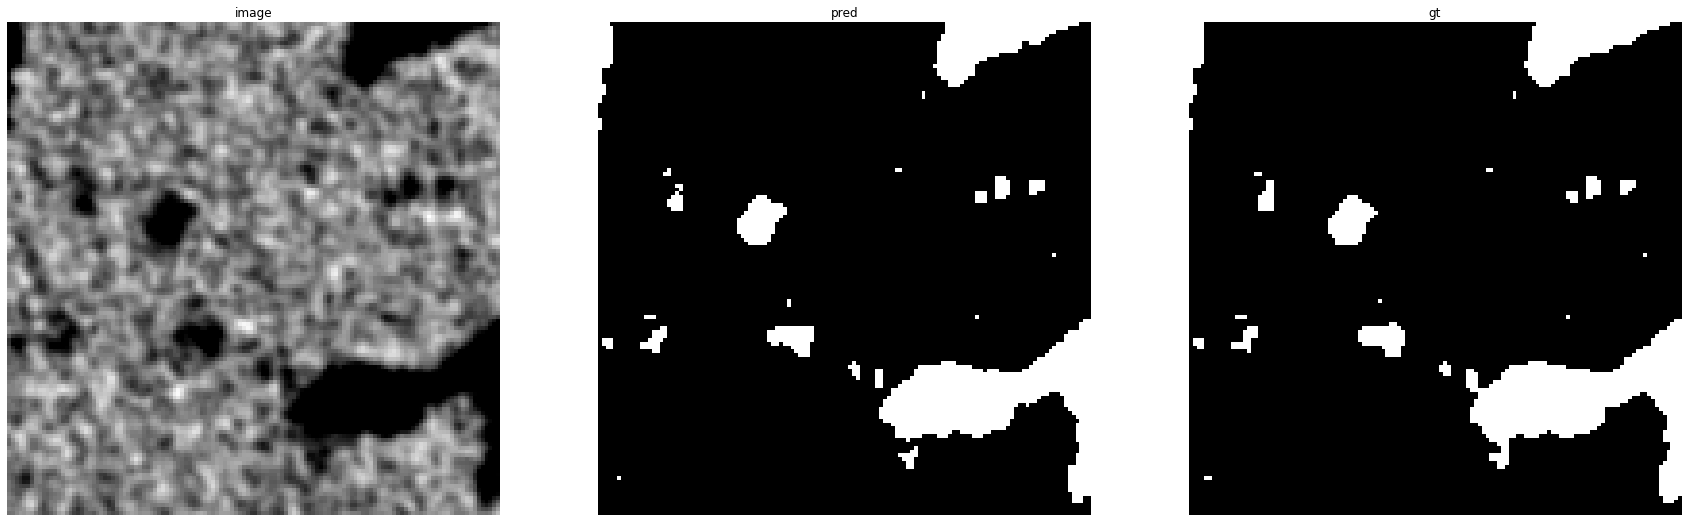

accuracy    : 0.994384765625
precision   : 0.9920586438607208
recall      : 0.9536112742219612
f1          : 0.9724550898203594
pr_auc      : 0.9972525742050342
iou         : 0.9463869463869464


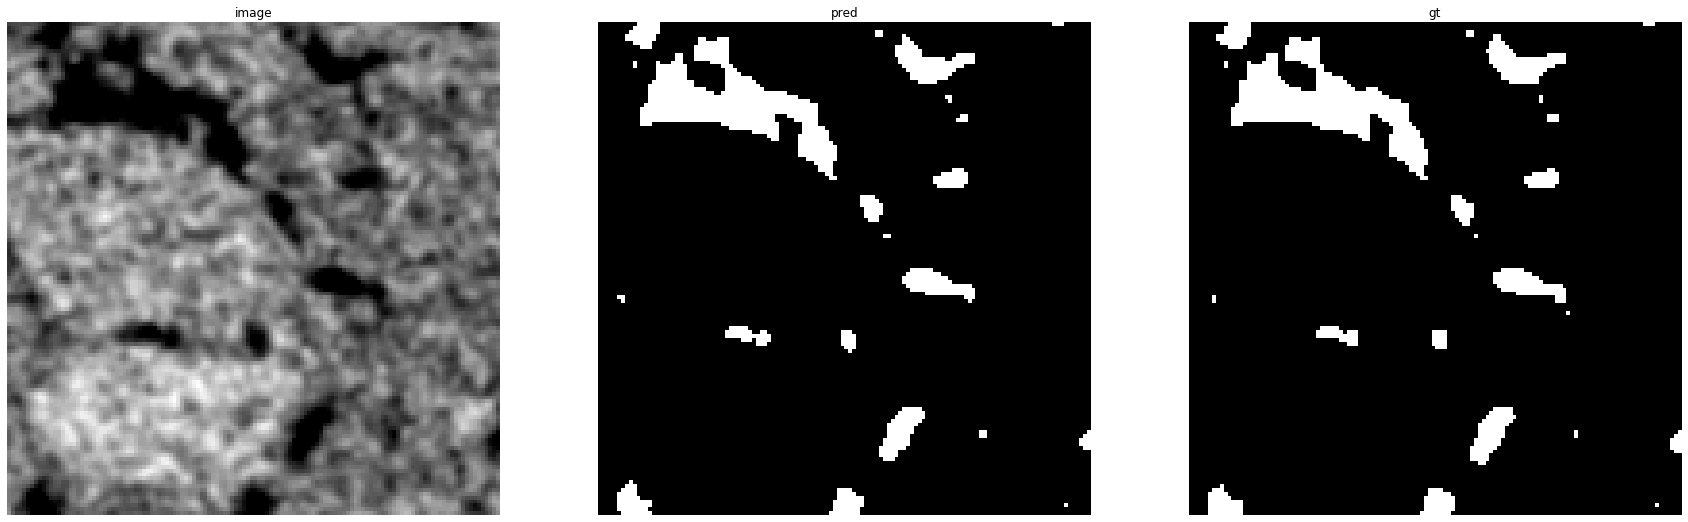

accuracy    : 0.994873046875
precision   : 0.9809825673534073
recall      : 0.9537750385208013
f1          : 0.9671875000000001
pr_auc      : 0.9965418937256305
iou         : 0.9364599092284418


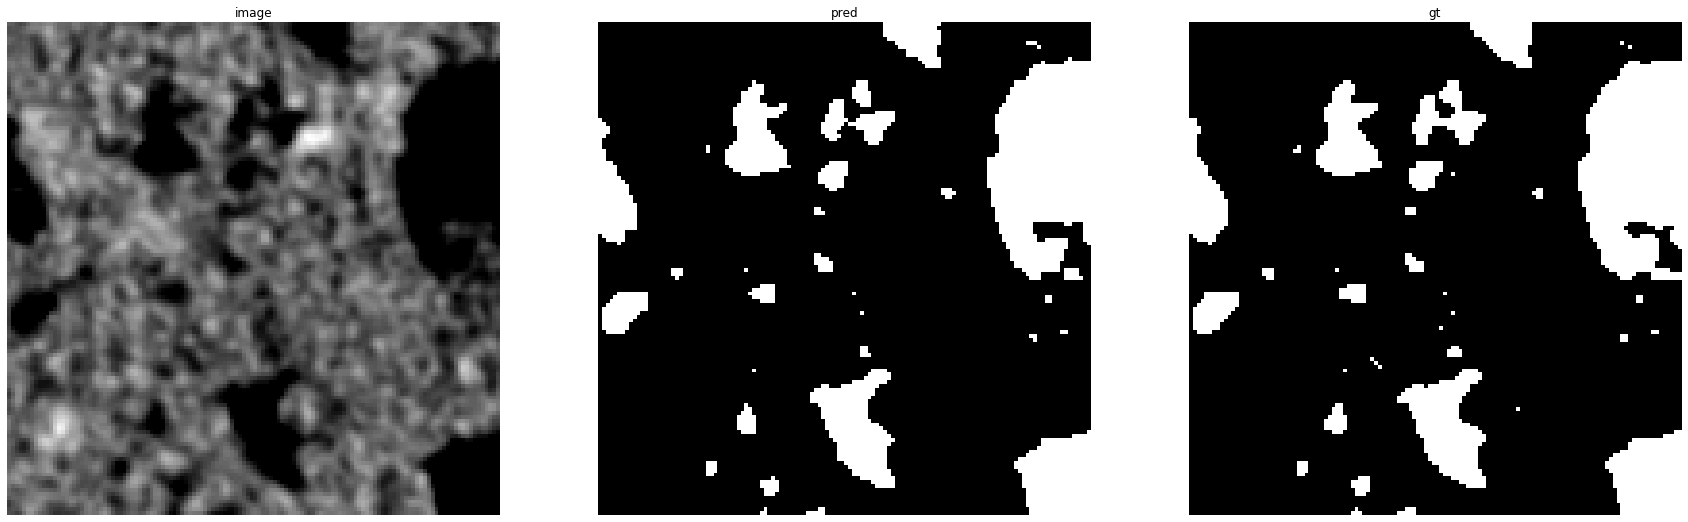

accuracy    : 0.990234375
precision   : 0.9934256055363322
recall      : 0.953187250996016
f1          : 0.9728905455777703
pr_auc      : 0.9981635529274819
iou         : 0.9472121412075223


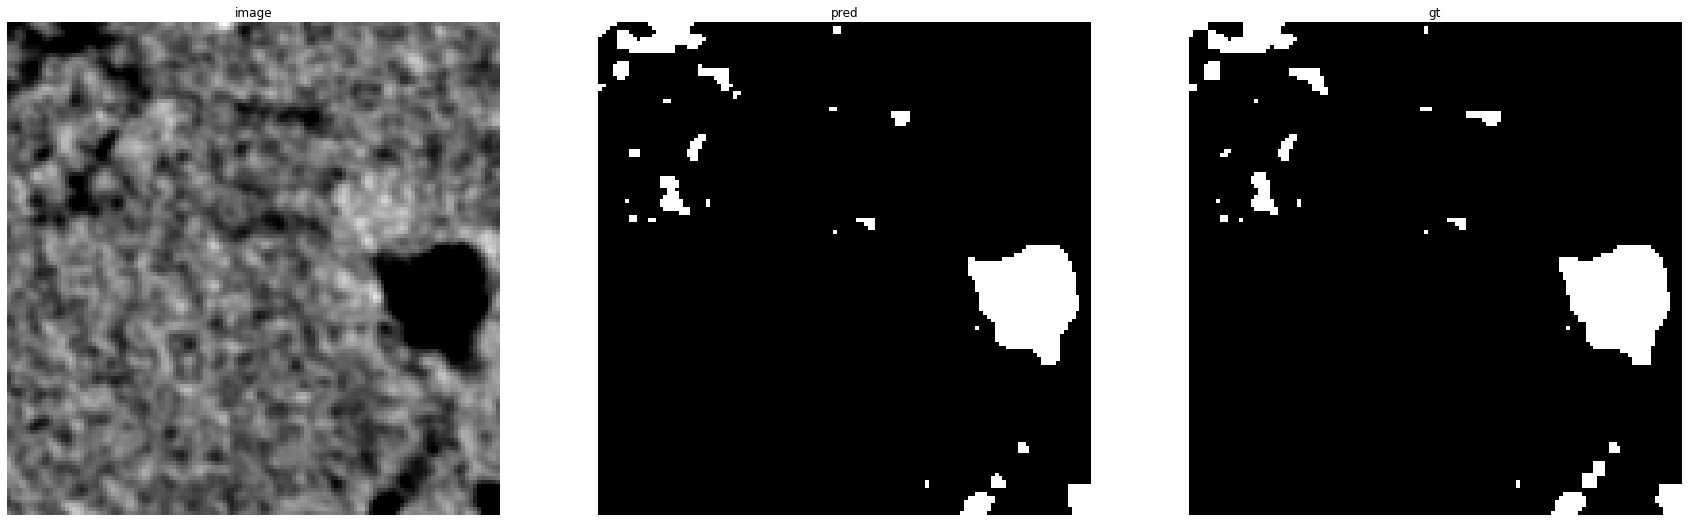

accuracy    : 0.99505615234375
precision   : 0.984267453294002
recall      : 0.9390243902439024
f1          : 0.9611137782045127
pr_auc      : 0.9945224336593103
iou         : 0.9251386321626618
Urna_22


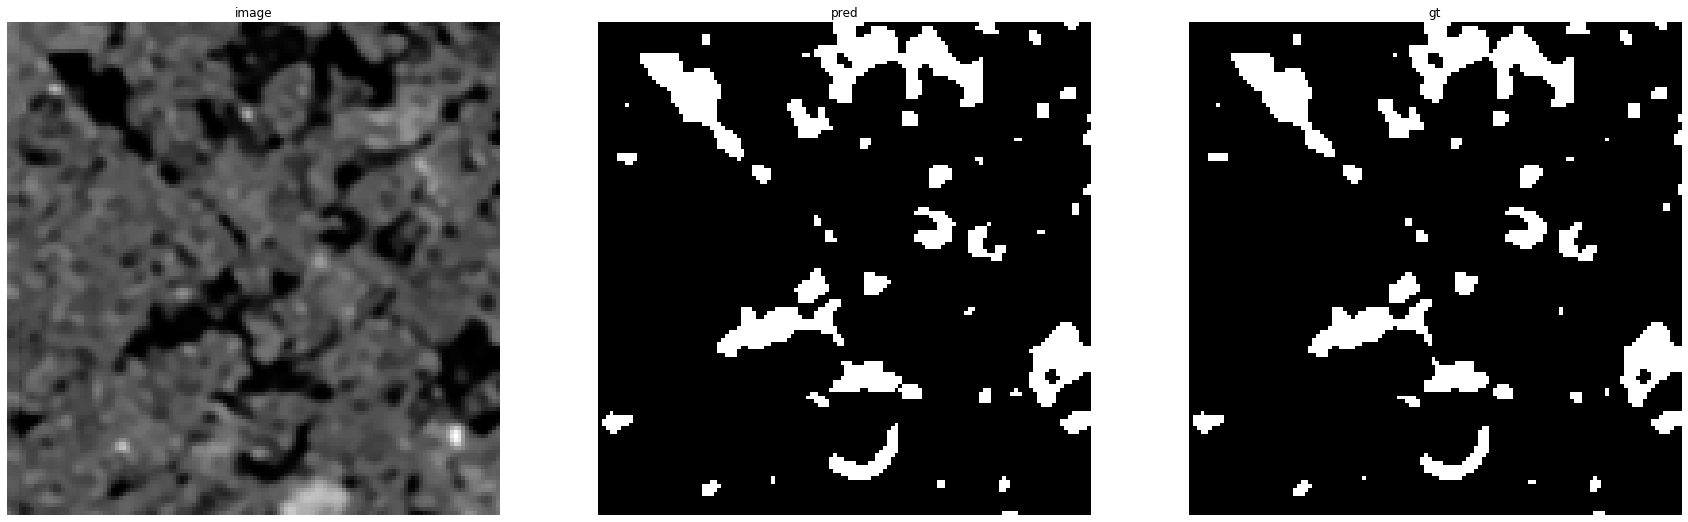

accuracy    : 0.9921875
precision   : 0.9479857215706272
recall      : 0.9862068965517241
f1          : 0.9667186687467497
pr_auc      : 0.9974805107072284
iou         : 0.9355812783090085


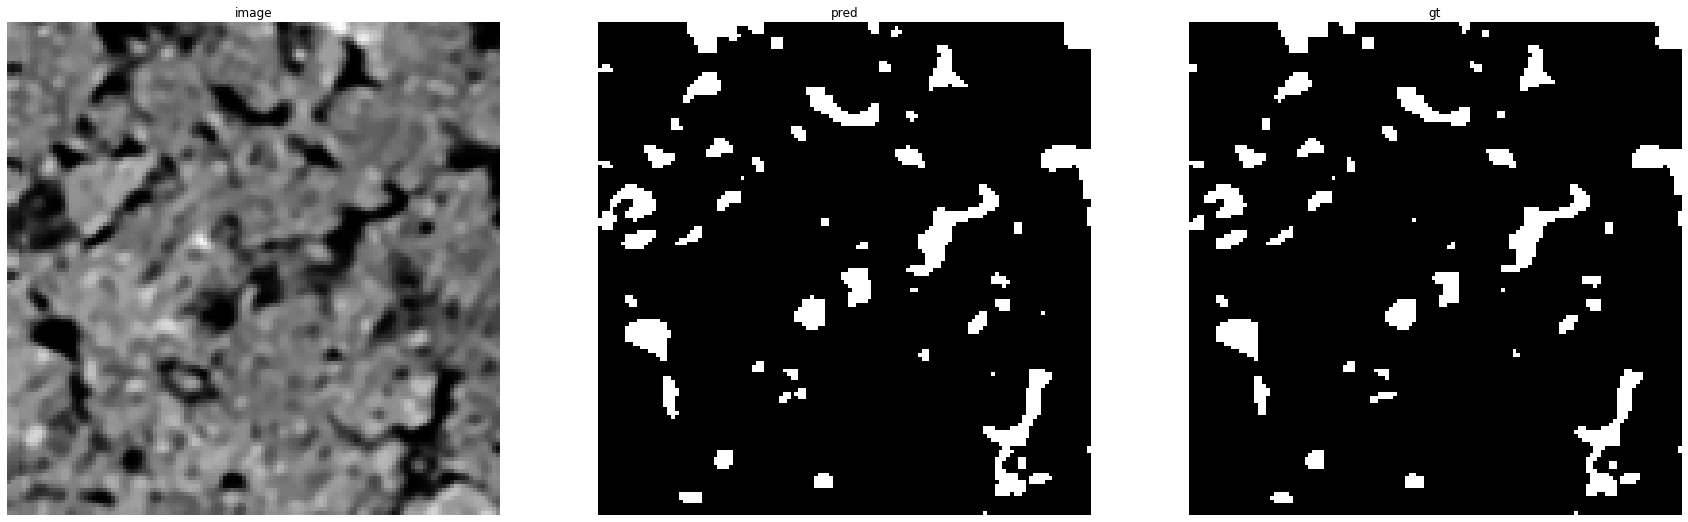

accuracy    : 0.9892578125
precision   : 0.8968307484828051
recall      : 0.9830007390983001
f1          : 0.9379407616361073
pr_auc      : 0.9940763402685615
iou         : 0.8831341301460823


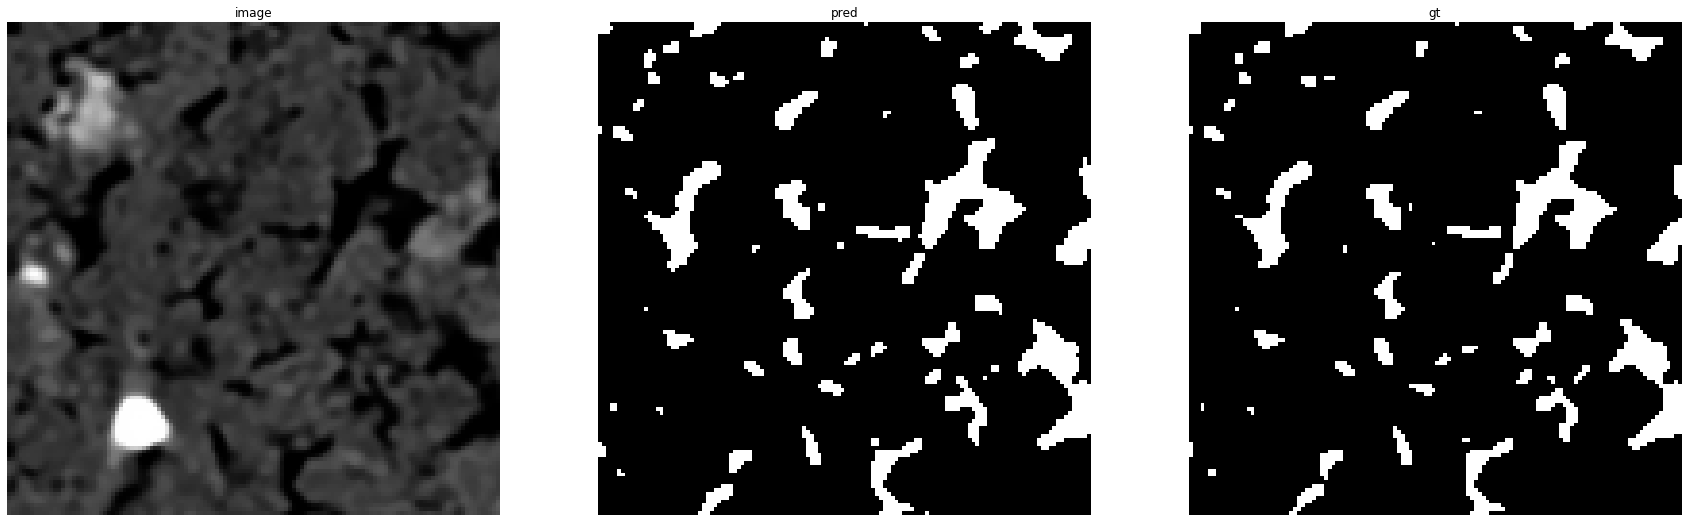

accuracy    : 0.9876708984375
precision   : 0.9051362683438156
recall      : 0.9879862700228833
f1          : 0.9447483588621445
pr_auc      : 0.995947584522223
iou         : 0.8952825298081908


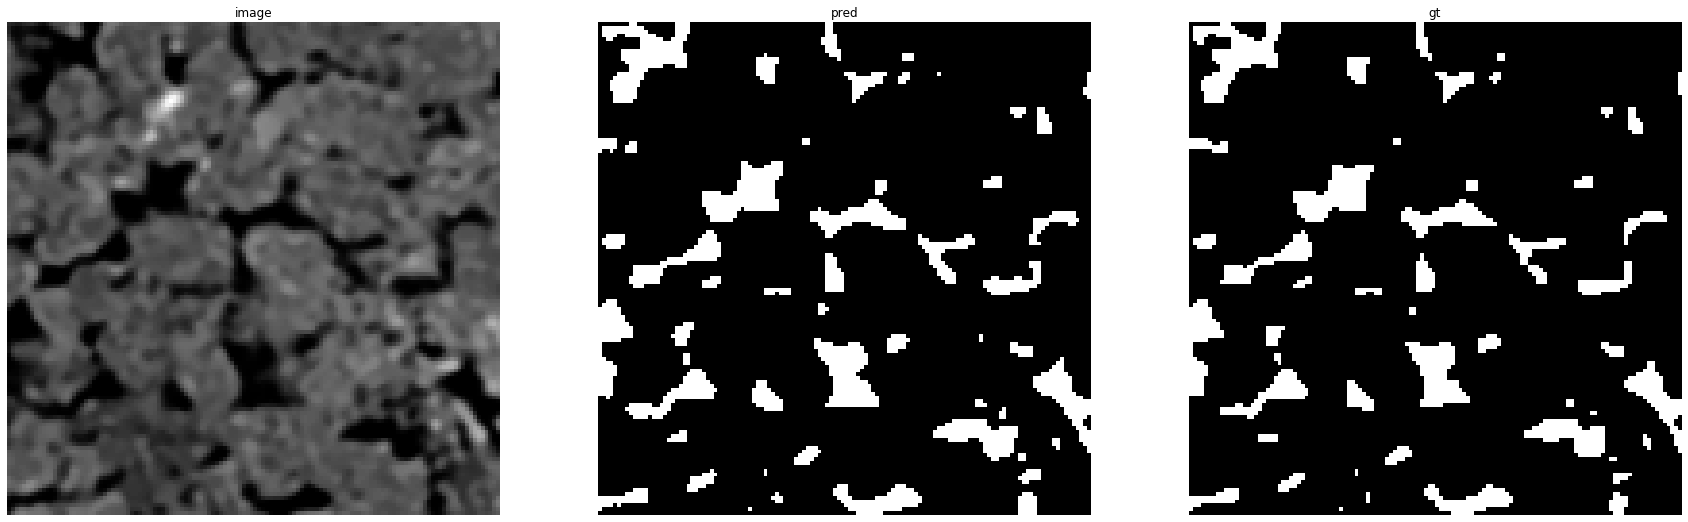

accuracy    : 0.98626708984375
precision   : 0.9043040293040293
recall      : 0.9919638372677047
f1          : 0.9461077844311379
pr_auc      : 0.9968838912835778
iou         : 0.8977272727272727


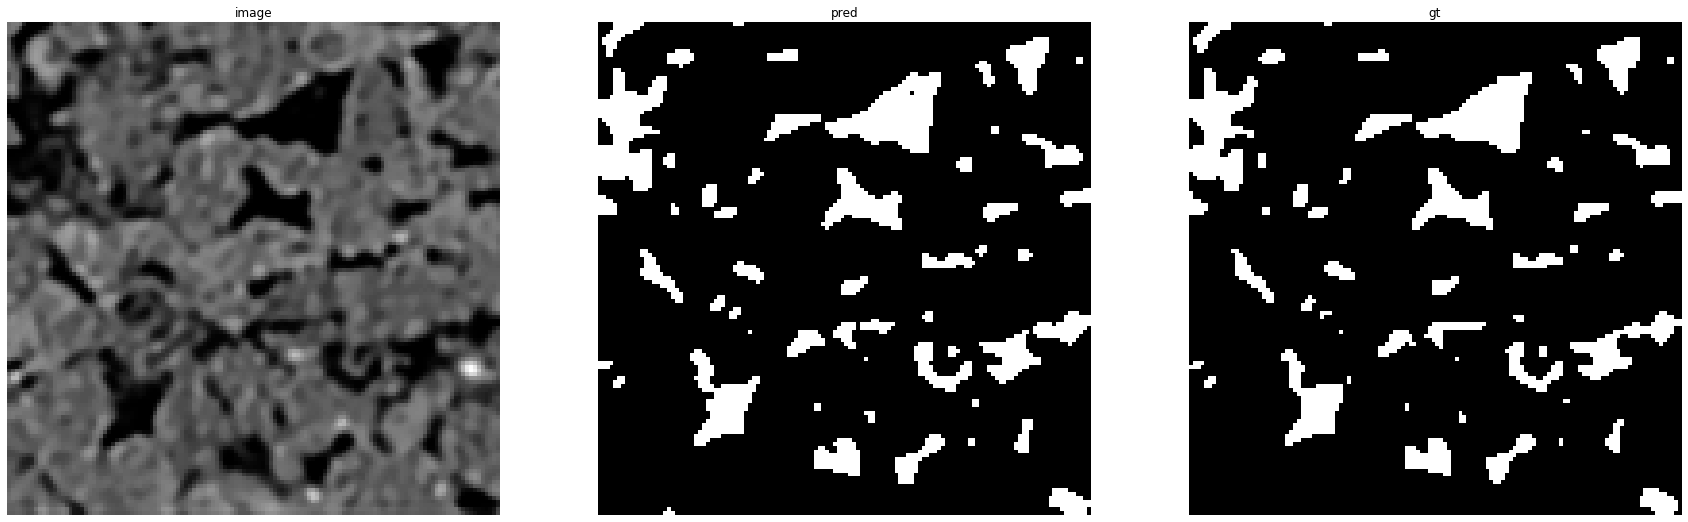

accuracy    : 0.987548828125
precision   : 0.9241767764298093
recall      : 0.986586493987049
f1          : 0.9543624161073825
pr_auc      : 0.9968176398525777
iou         : 0.9127086007702182


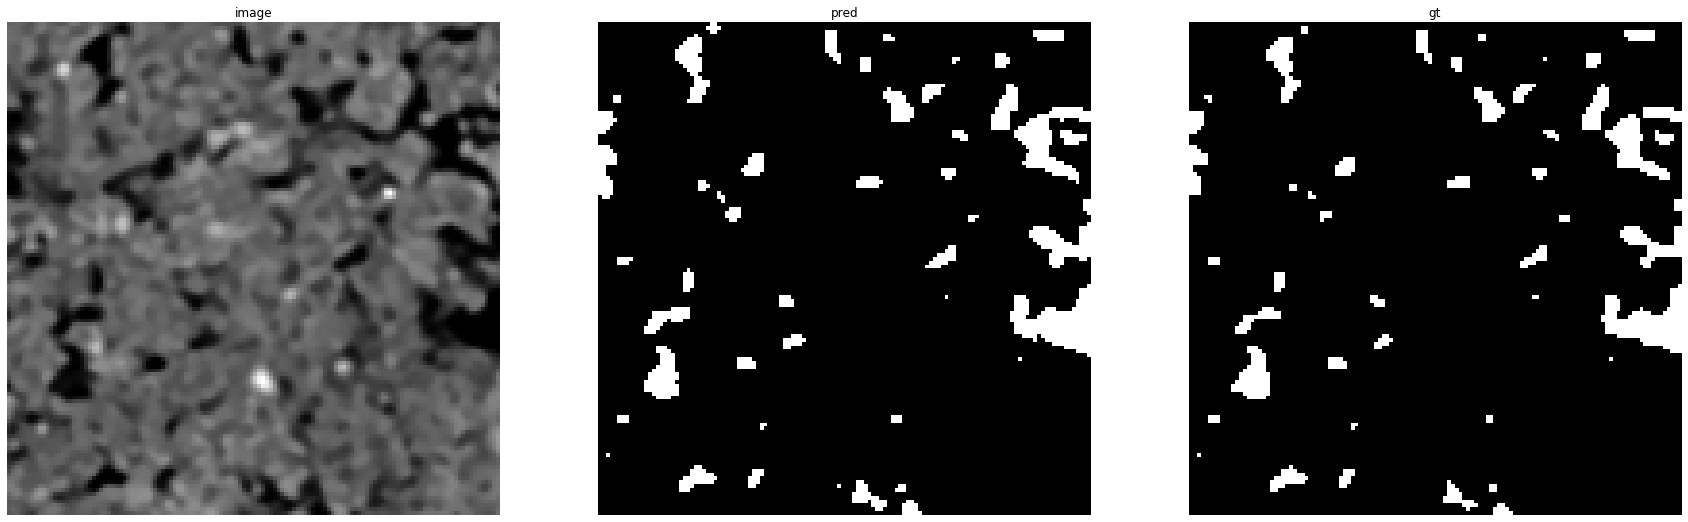

accuracy    : 0.9898681640625
precision   : 0.8801556420233463
recall      : 0.989501312335958
f1          : 0.9316309719934102
pr_auc      : 0.993092111279084
iou         : 0.8720123361603701


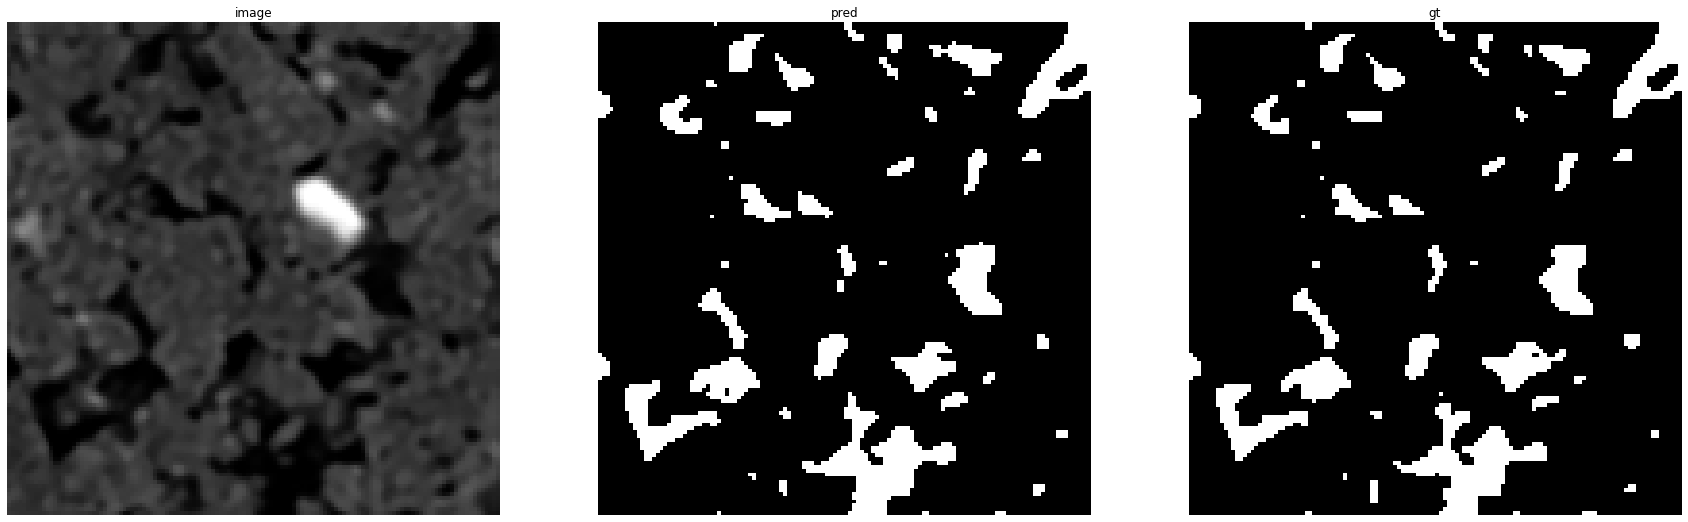

accuracy    : 0.98779296875
precision   : 0.9265426052889324
recall      : 0.9742533470648815
f1          : 0.9497991967871485
pr_auc      : 0.9947556404860801
iou         : 0.904397705544933


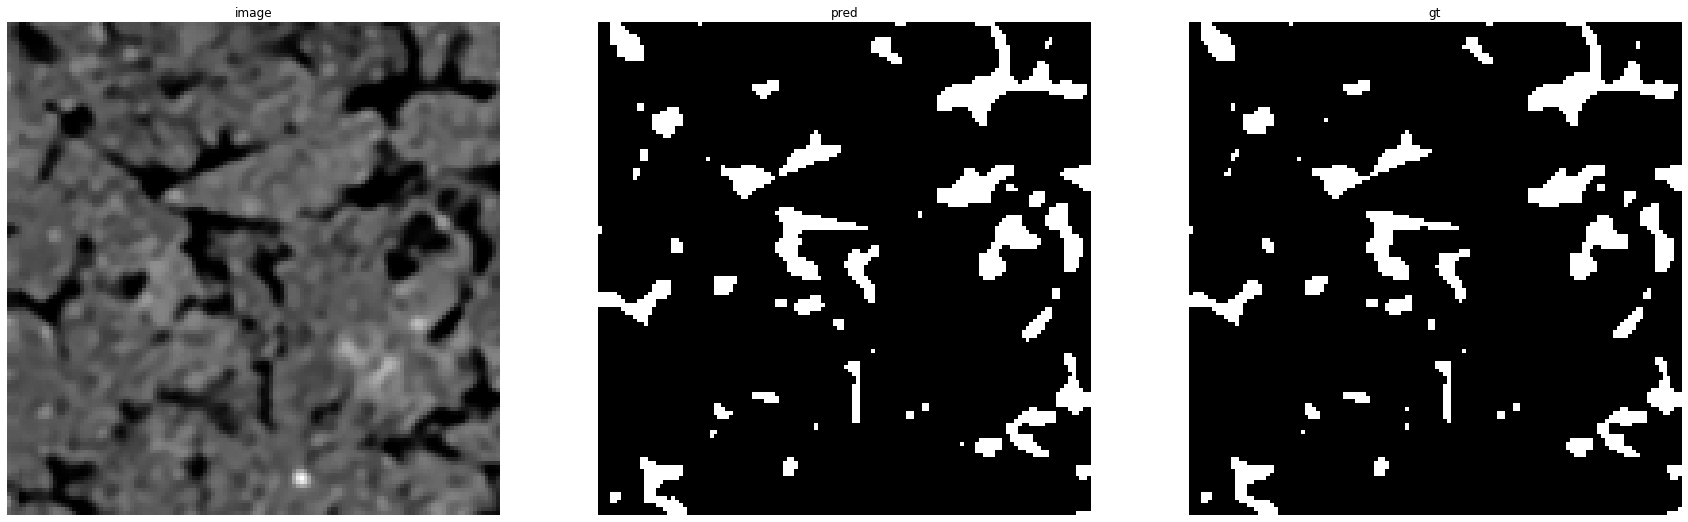

accuracy    : 0.99163818359375
precision   : 0.9312638580931264
recall      : 0.9923213230950975
f1          : 0.9608235630540464
pr_auc      : 0.9967851564591391
iou         : 0.9246009906439185


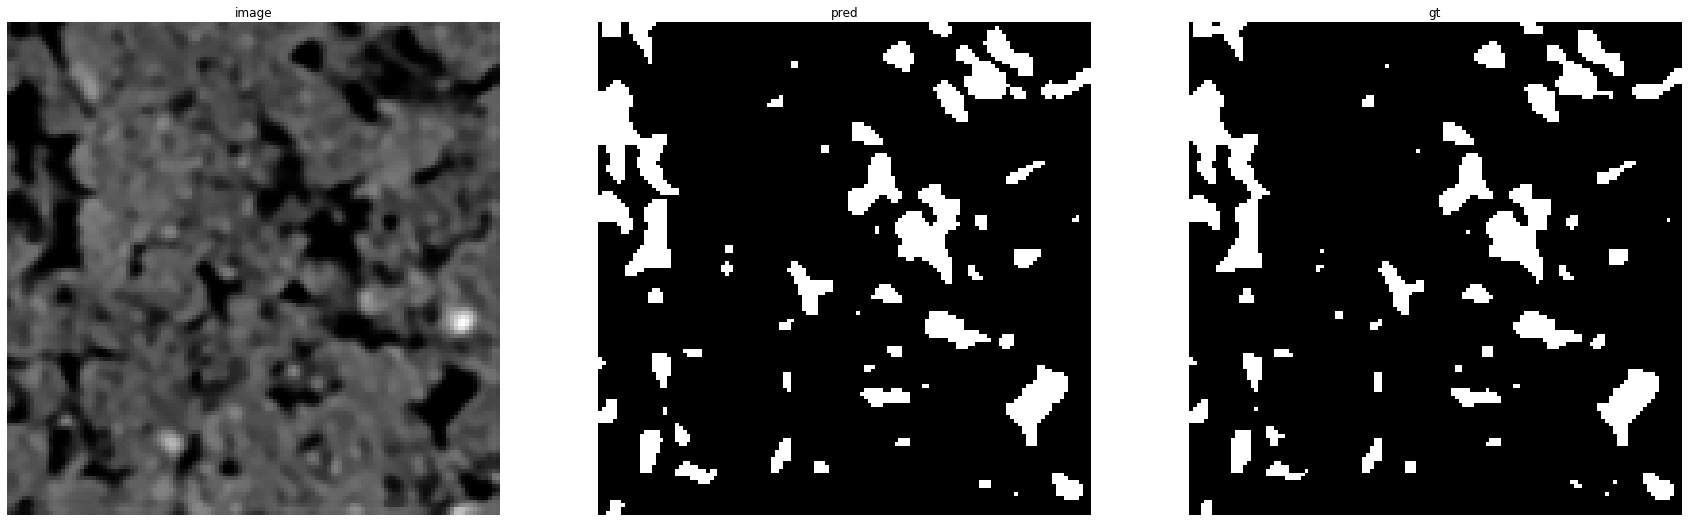

accuracy    : 0.98736572265625
precision   : 0.9209280303030303
recall      : 0.9798488664987406
f1          : 0.9494752257749572
pr_auc      : 0.9938979427347893
iou         : 0.9038104089219331


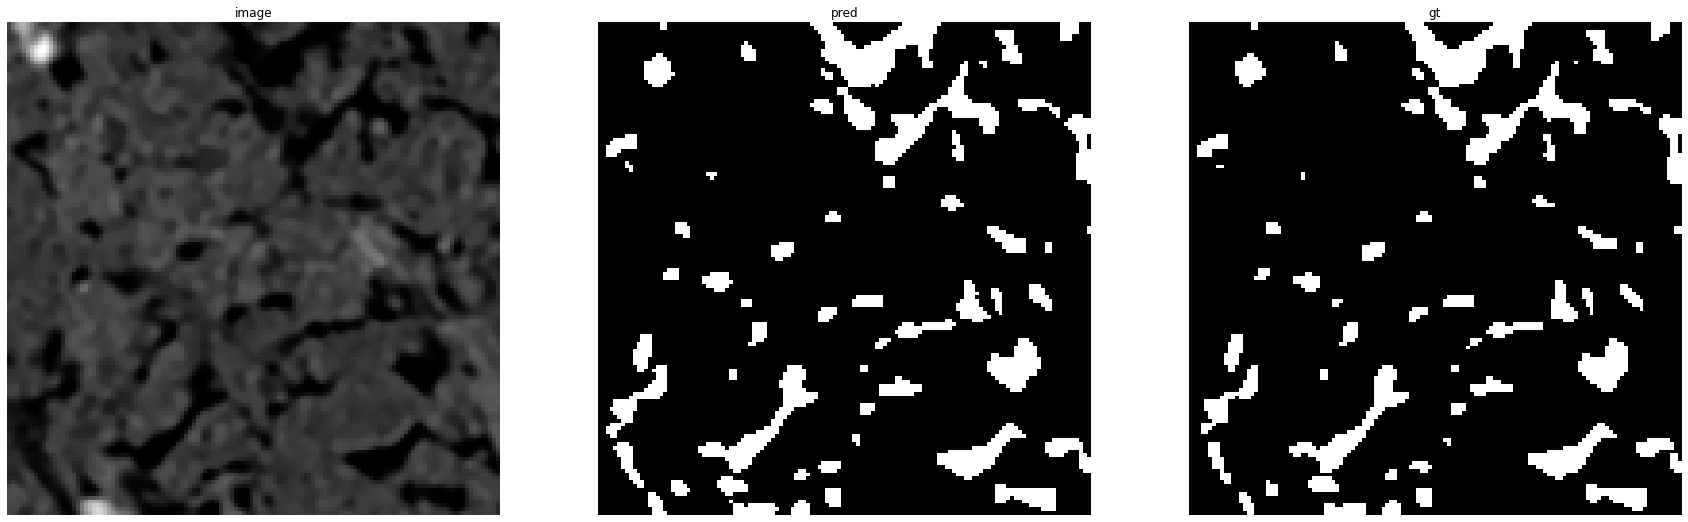

accuracy    : 0.98870849609375
precision   : 0.9225806451612903
recall      : 0.991579990094106
f1          : 0.9558367152064933
pr_auc      : 0.9967981842775377
iou         : 0.9154092363968908
Urna_30


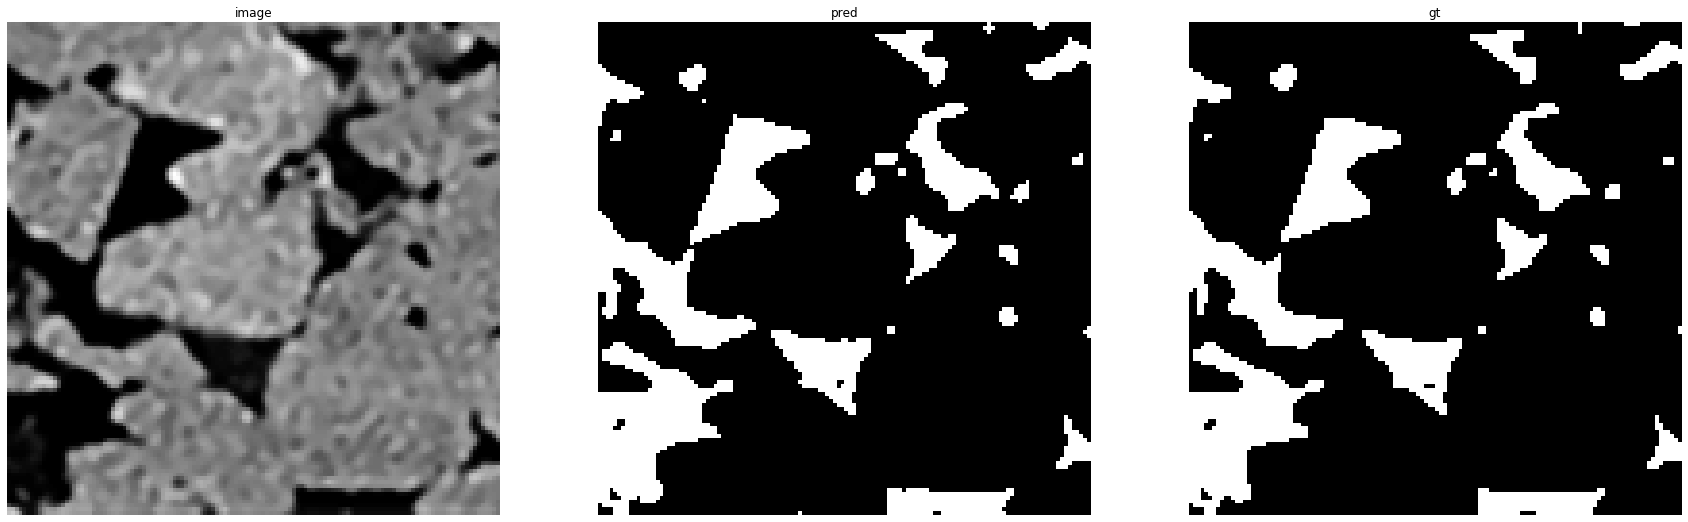

accuracy    : 0.9908447265625
precision   : 0.9570883661792753
recall      : 0.9950429610046265
f1          : 0.975696694750486
pr_auc      : 0.9990210573316232
iou         : 0.9525466624485922


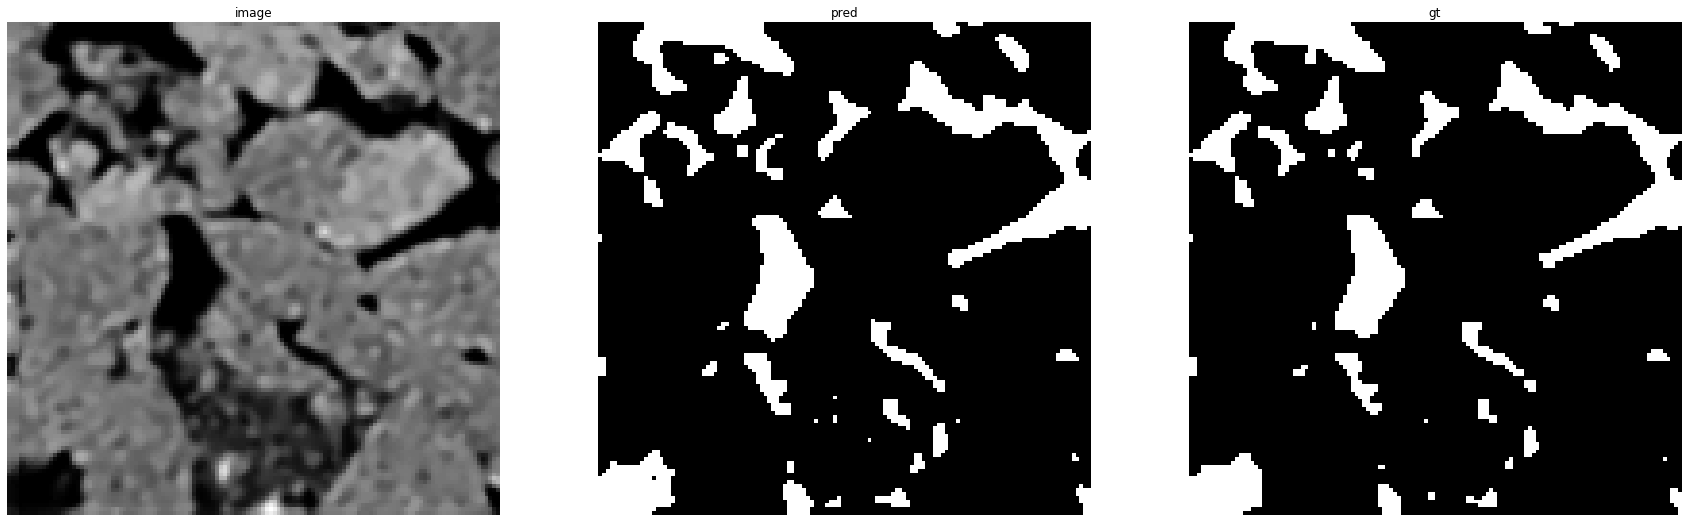

accuracy    : 0.98663330078125
precision   : 0.9232540291634689
recall      : 0.9921649484536083
f1          : 0.9564698867024448
pr_auc      : 0.9964564114681542
iou         : 0.9165714285714286


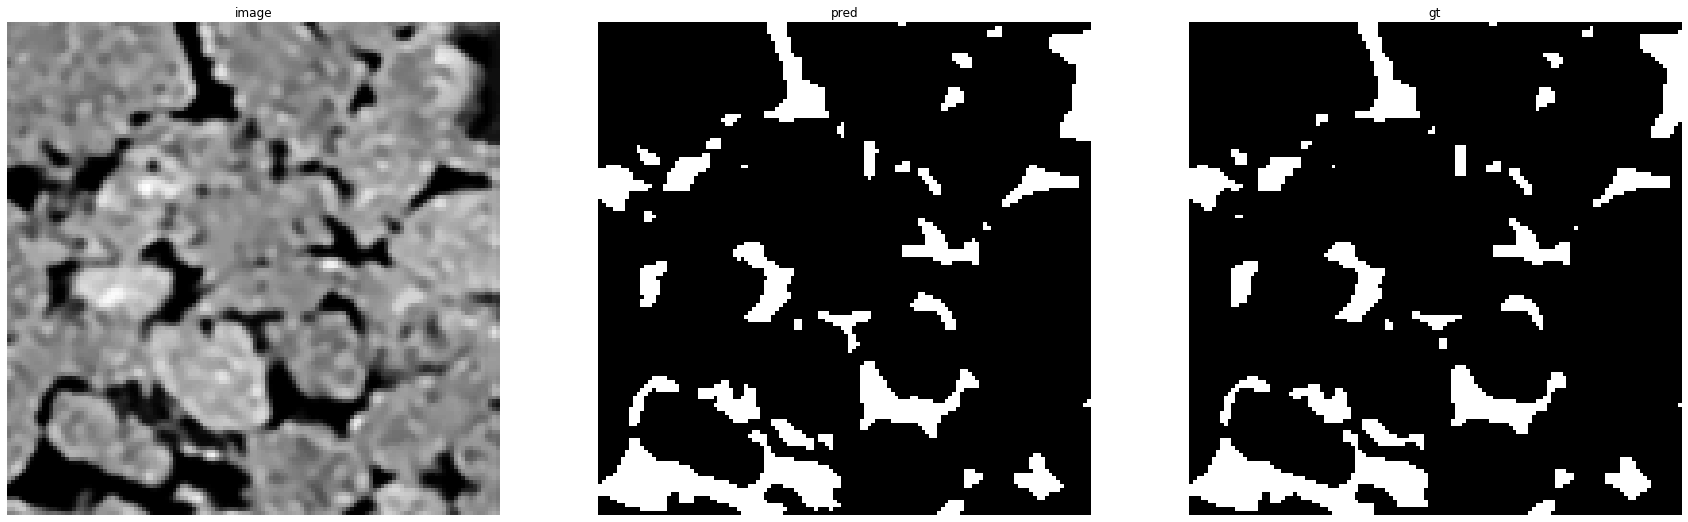

accuracy    : 0.98724365234375
precision   : 0.9210635646032406
recall      : 0.9915026833631485
f1          : 0.9549860004307559
pr_auc      : 0.9969058730779369
iou         : 0.9138499587798846


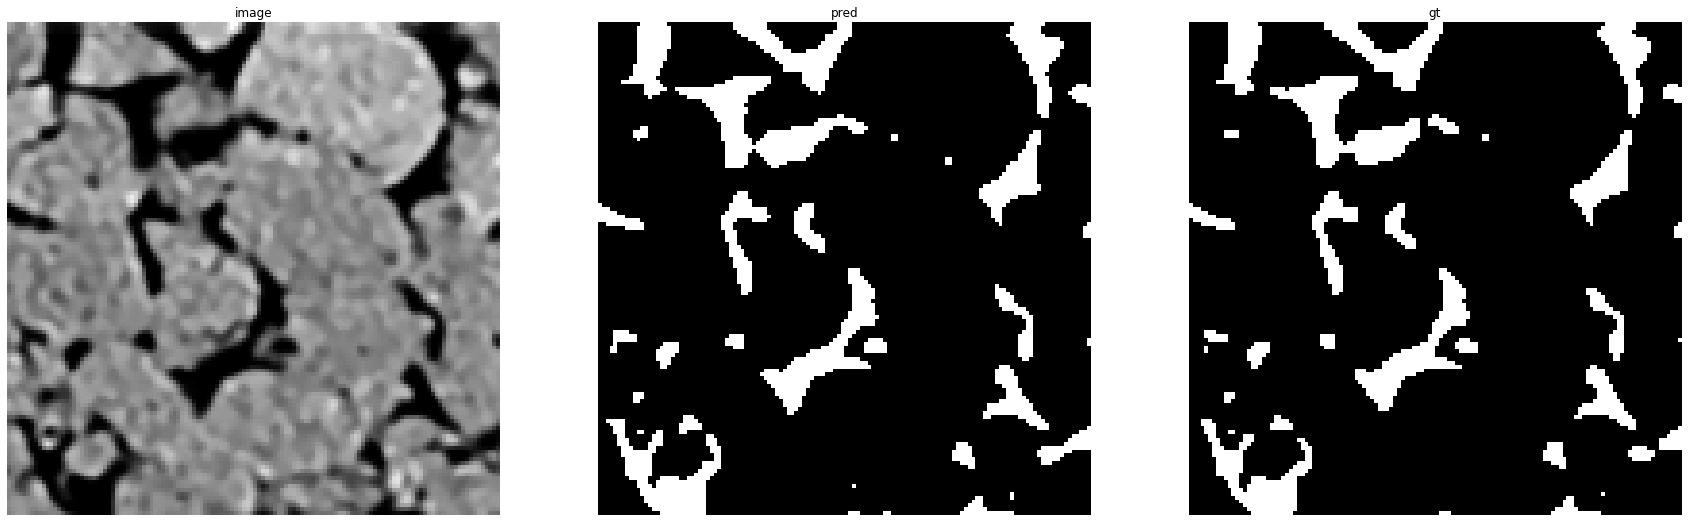

accuracy    : 0.989990234375
precision   : 0.937526382439848
recall      : 0.9928475637013858
f1          : 0.9643942683456362
pr_auc      : 0.9971719731713121
iou         : 0.9312368972746331


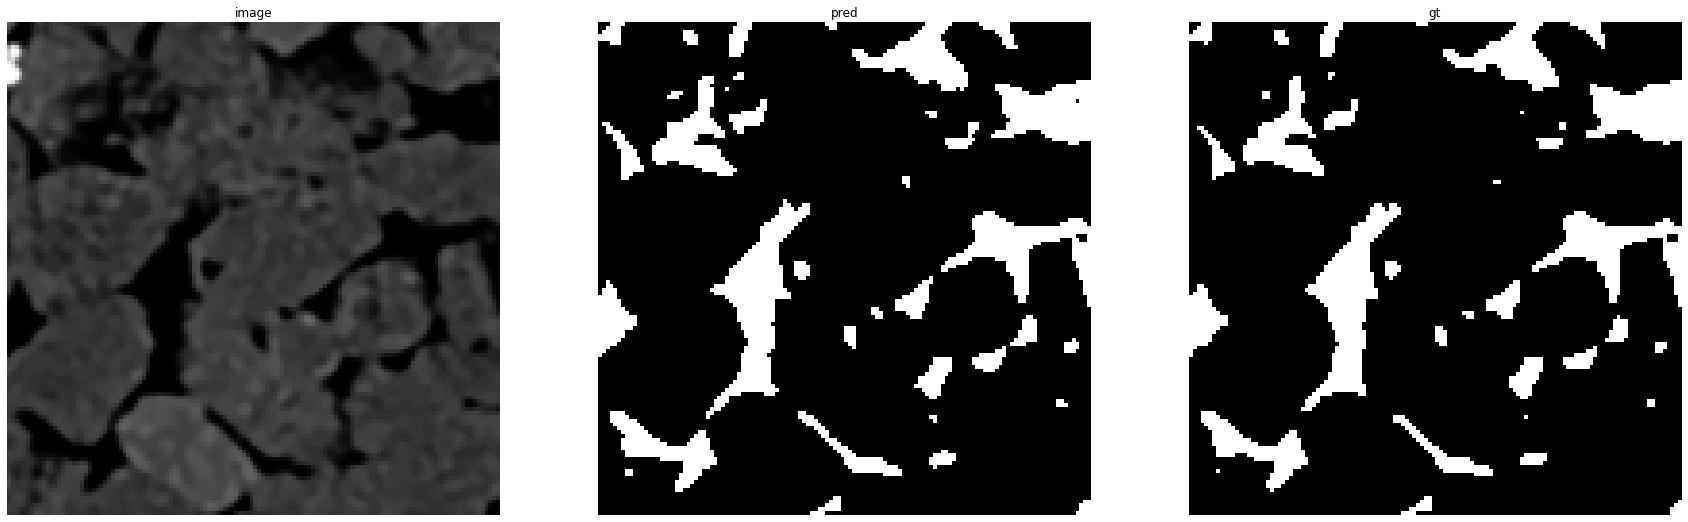

accuracy    : 0.98968505859375
precision   : 0.9393709738537325
recall      : 0.9963826366559485
f1          : 0.9670372537546322
pr_auc      : 0.9978622296711065
iou         : 0.9361782477341389


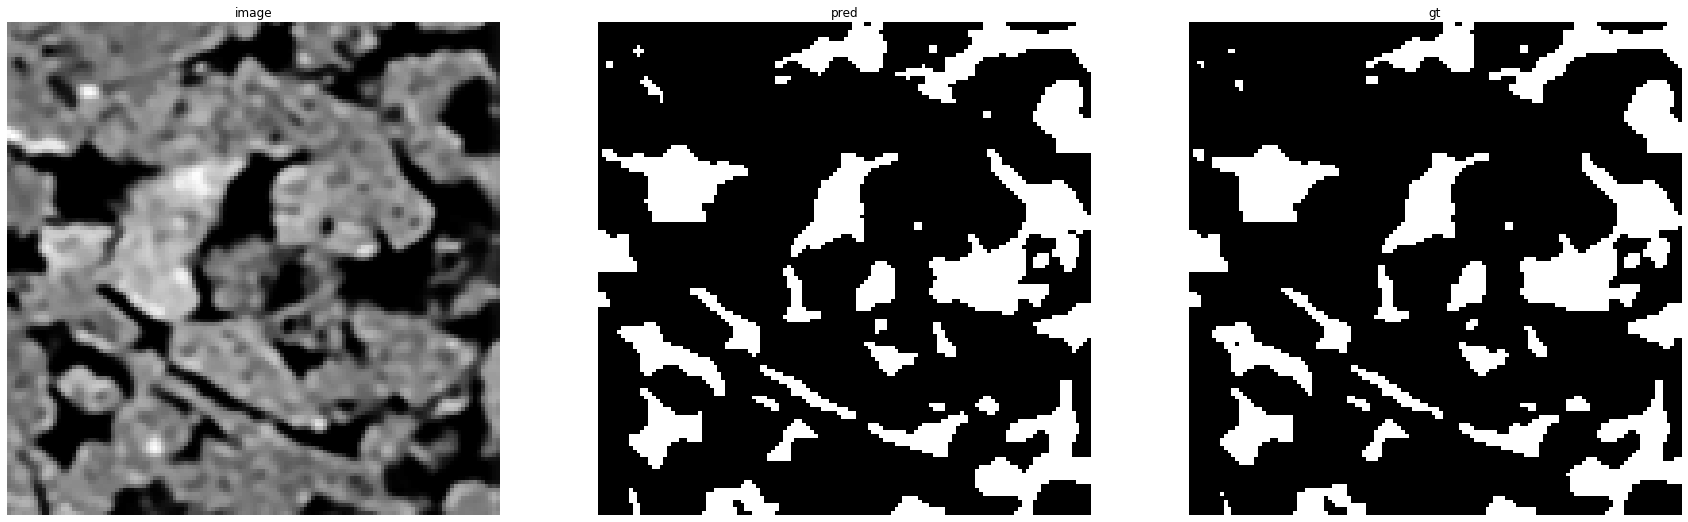

accuracy    : 0.9859619140625
precision   : 0.9490156486622918
recall      : 0.9926082365364308
f1          : 0.9703225806451613
pr_auc      : 0.9981180066554445
iou         : 0.9423558897243107


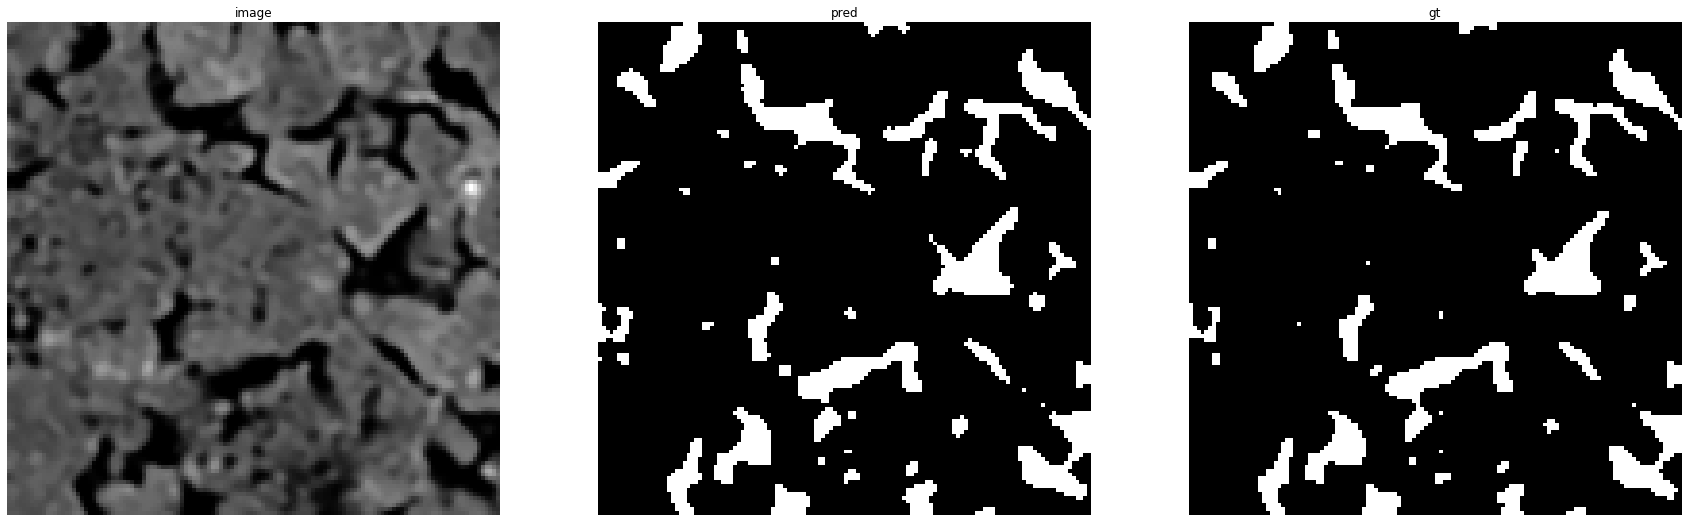

accuracy    : 0.98748779296875
precision   : 0.9192844677137871
recall      : 0.9905970850963799
f1          : 0.9536094138945463
pr_auc      : 0.9965347693093914
iou         : 0.9113321799307958


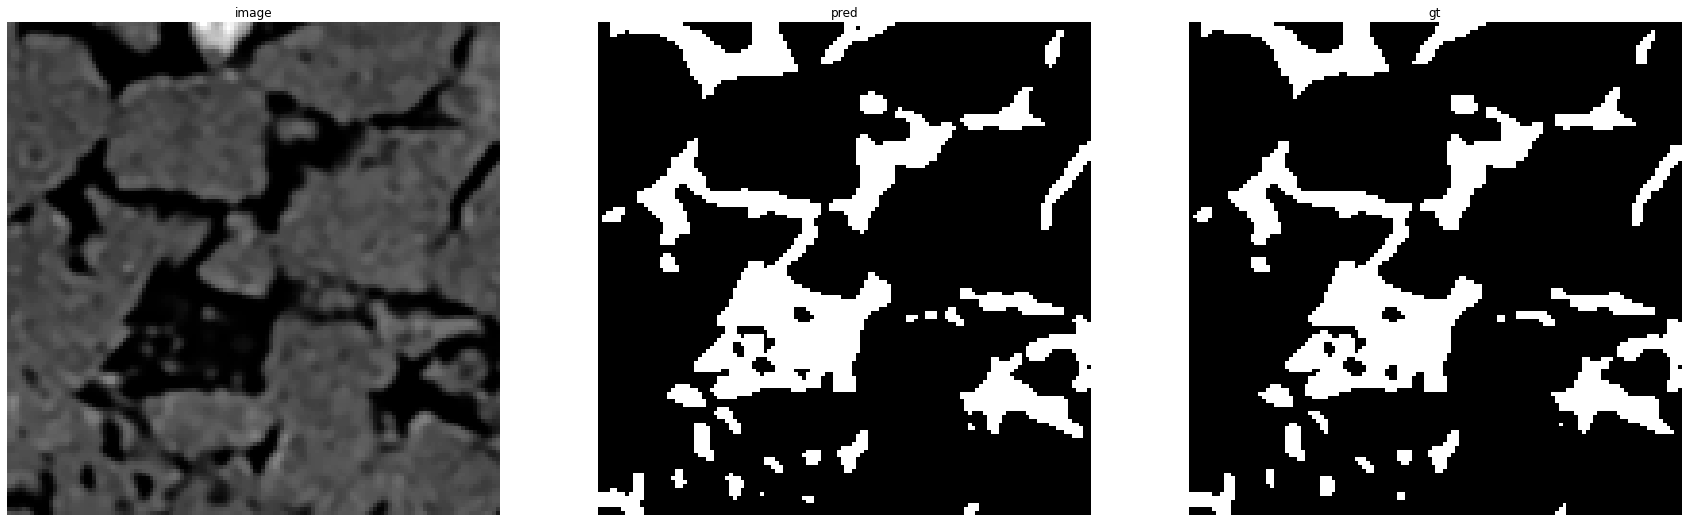

accuracy    : 0.98699951171875
precision   : 0.943900267141585
recall      : 0.9925093632958801
f1          : 0.967594705613875
pr_auc      : 0.9979131477849086
iou         : 0.9372236958443855


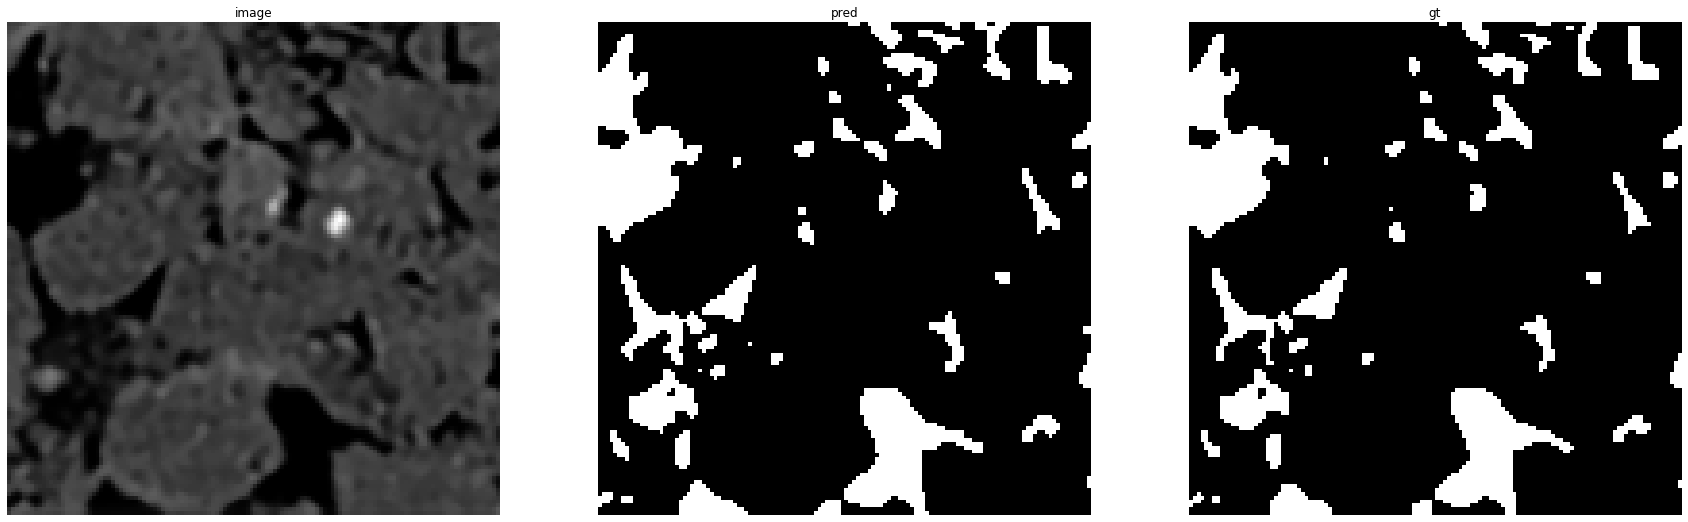

accuracy    : 0.98638916015625
precision   : 0.9201402415270744
recall      : 0.992436974789916
f1          : 0.9549221750555894
pr_auc      : 0.9962257455158655
iou         : 0.9137330754352031


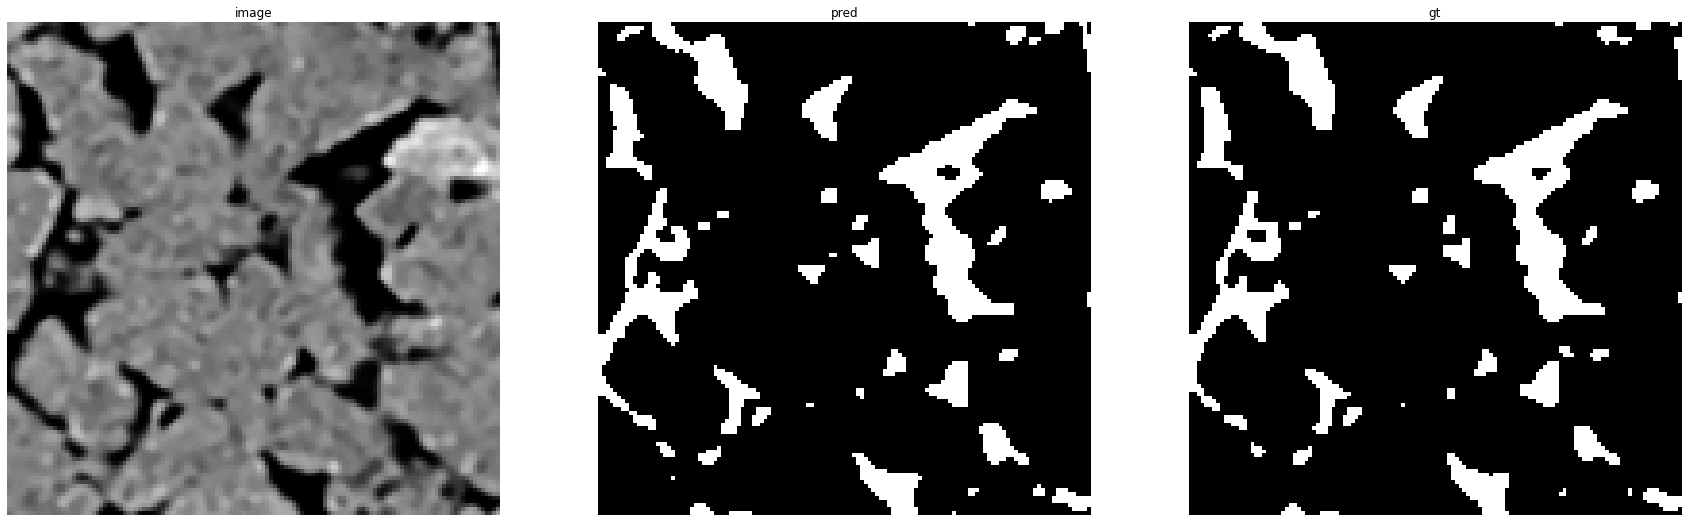

accuracy    : 0.98797607421875
precision   : 0.9401923881221247
recall      : 0.9765421372719374
f1          : 0.9580225868314511
pr_auc      : 0.99509412002093
iou         : 0.9194274028629856
Urna_34


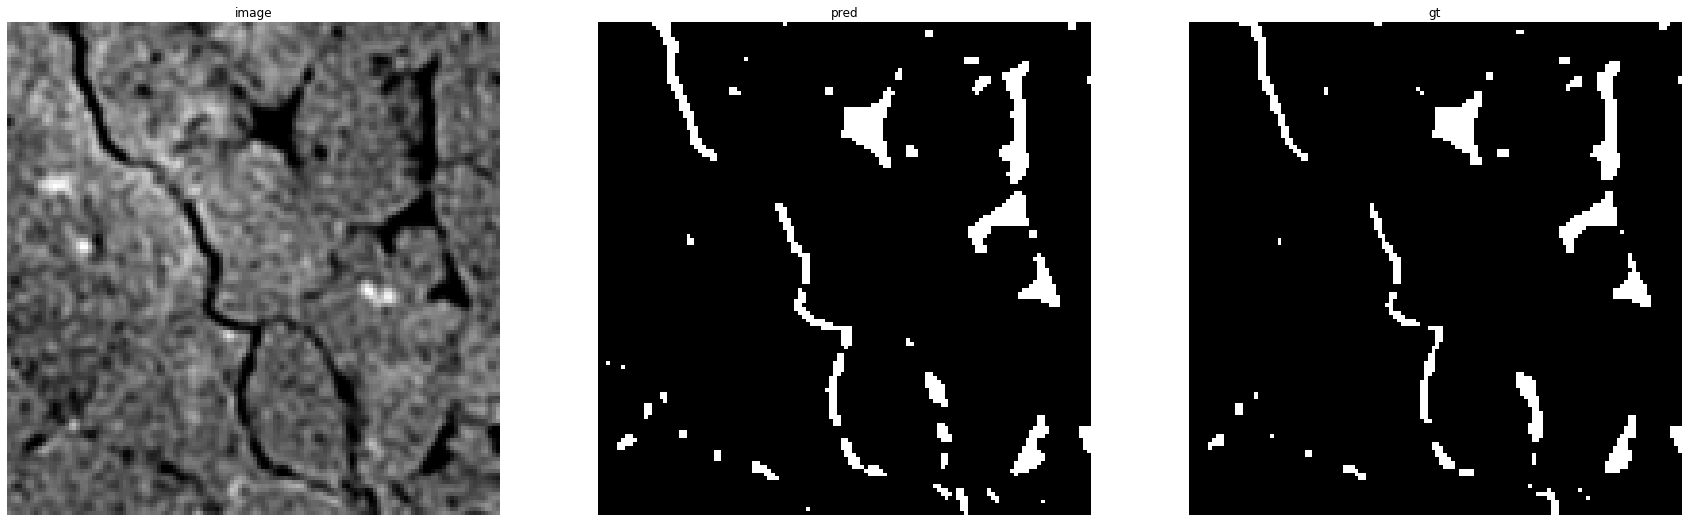

accuracy    : 0.98797607421875
precision   : 0.8363273453093812
recall      : 0.9621125143513203
f1          : 0.8948211425520556
pr_auc      : 0.979990402145141
iou         : 0.8096618357487922


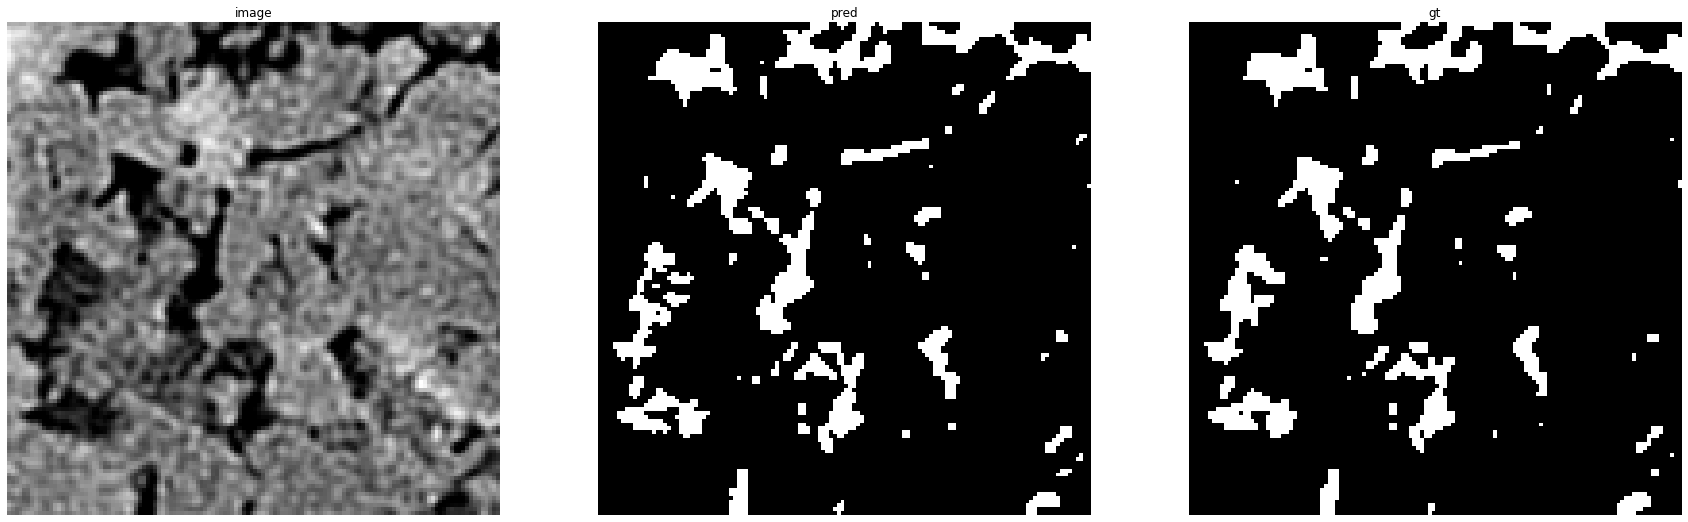

accuracy    : 0.97906494140625
precision   : 0.8988818667963053
recall      : 0.9319556451612904
f1          : 0.9151200197970799
pr_auc      : 0.980797173231877
iou         : 0.843521897810219


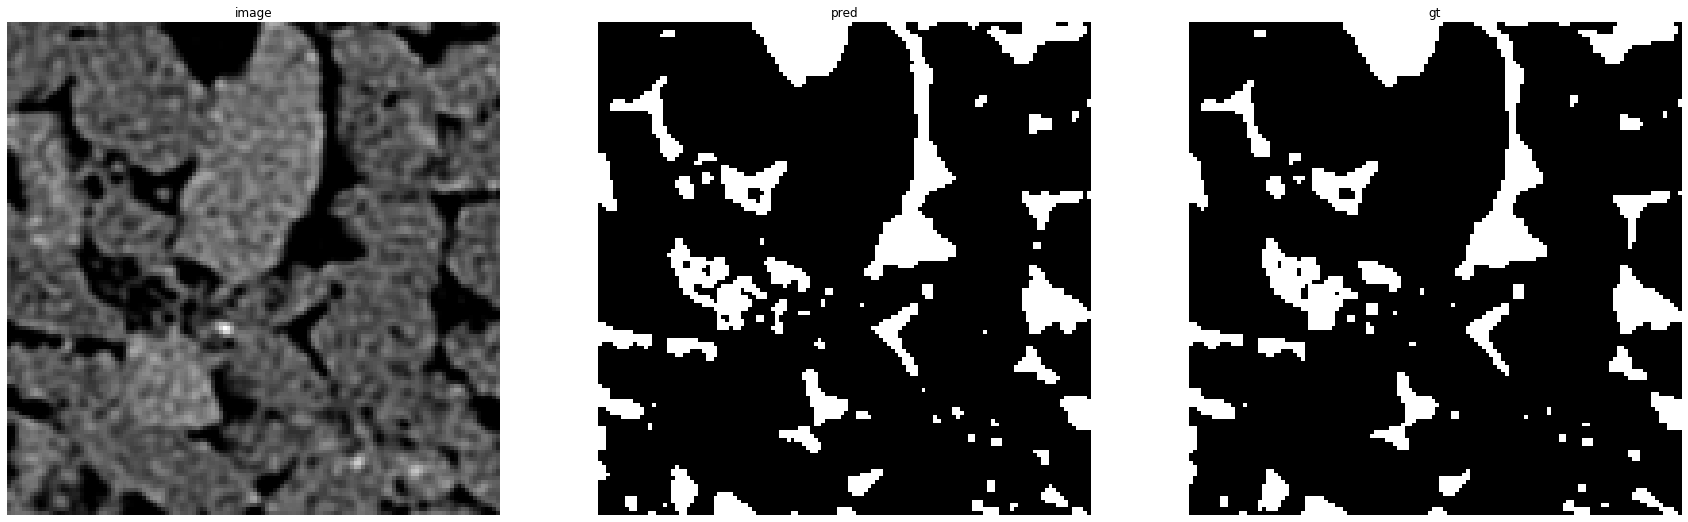

accuracy    : 0.98175048828125
precision   : 0.9211415696582801
recall      : 0.9649881982690794
f1          : 0.9425552353506244
pr_auc      : 0.991618177900516
iou         : 0.8913517441860465


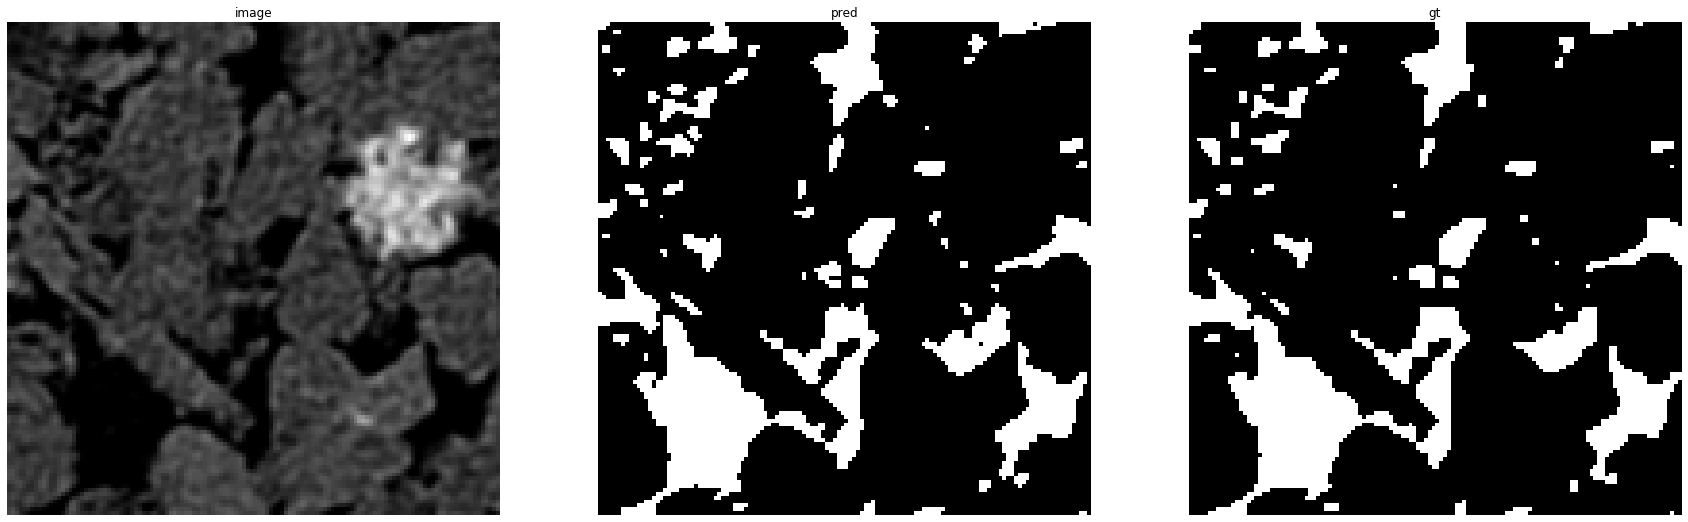

accuracy    : 0.98089599609375
precision   : 0.9250157529930687
recall      : 0.9750913317834606
f1          : 0.9493936944219887
pr_auc      : 0.9942124967205678
iou         : 0.9036626654355187


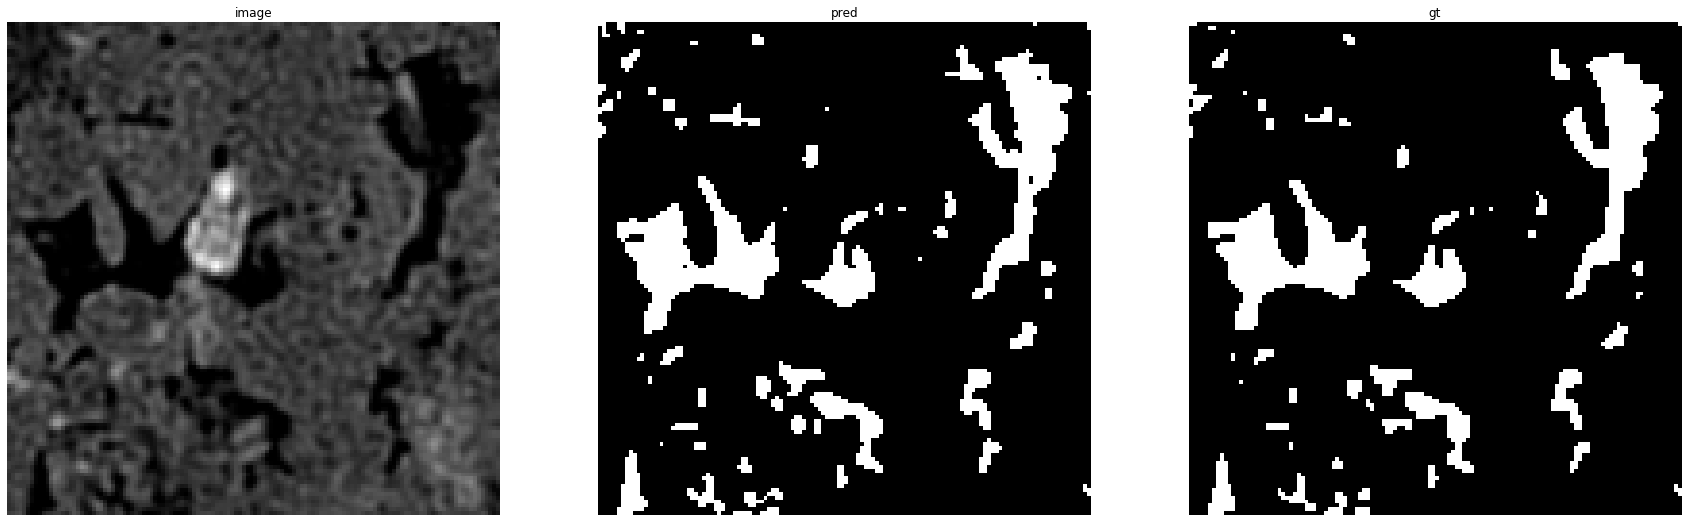

accuracy    : 0.982177734375
precision   : 0.9004291845493563
recall      : 0.9721964782205746
f1          : 0.9349376114081998
pr_auc      : 0.992008720222769
iou         : 0.8778242677824267


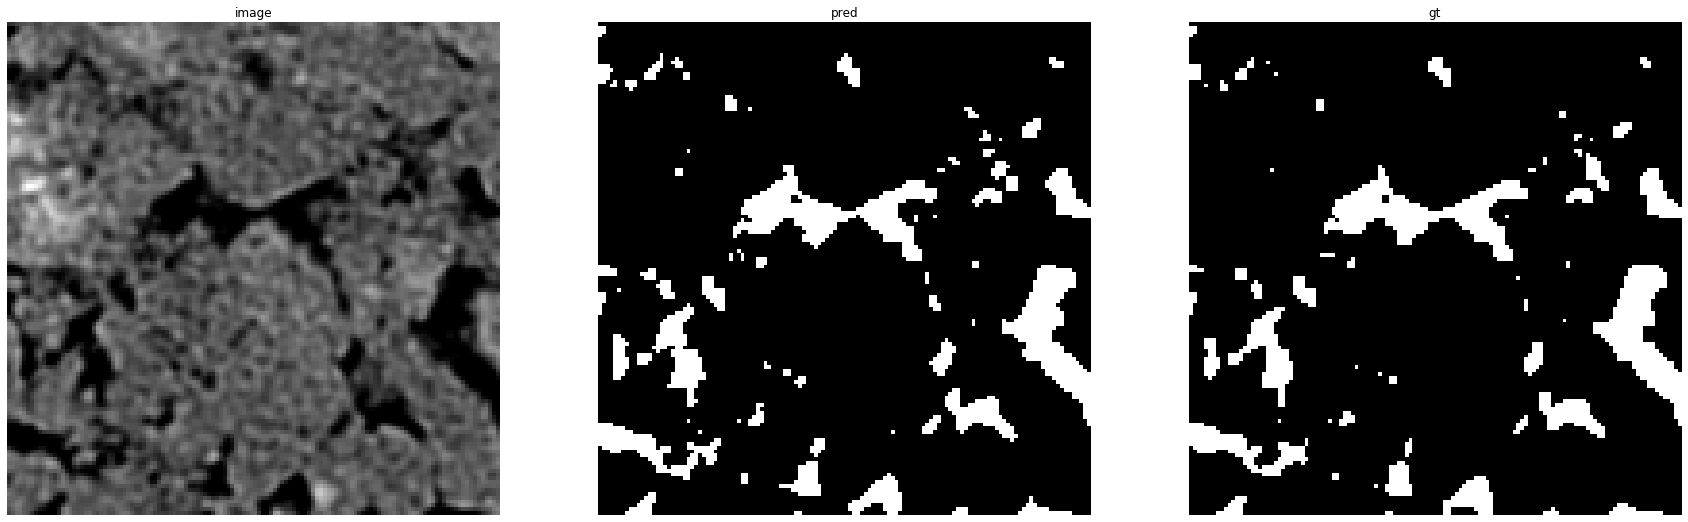

accuracy    : 0.98297119140625
precision   : 0.895492818226845
recall      : 0.9637526652452025
f1          : 0.9283697047496791
pr_auc      : 0.9887266958179123
iou         : 0.8663152850982271


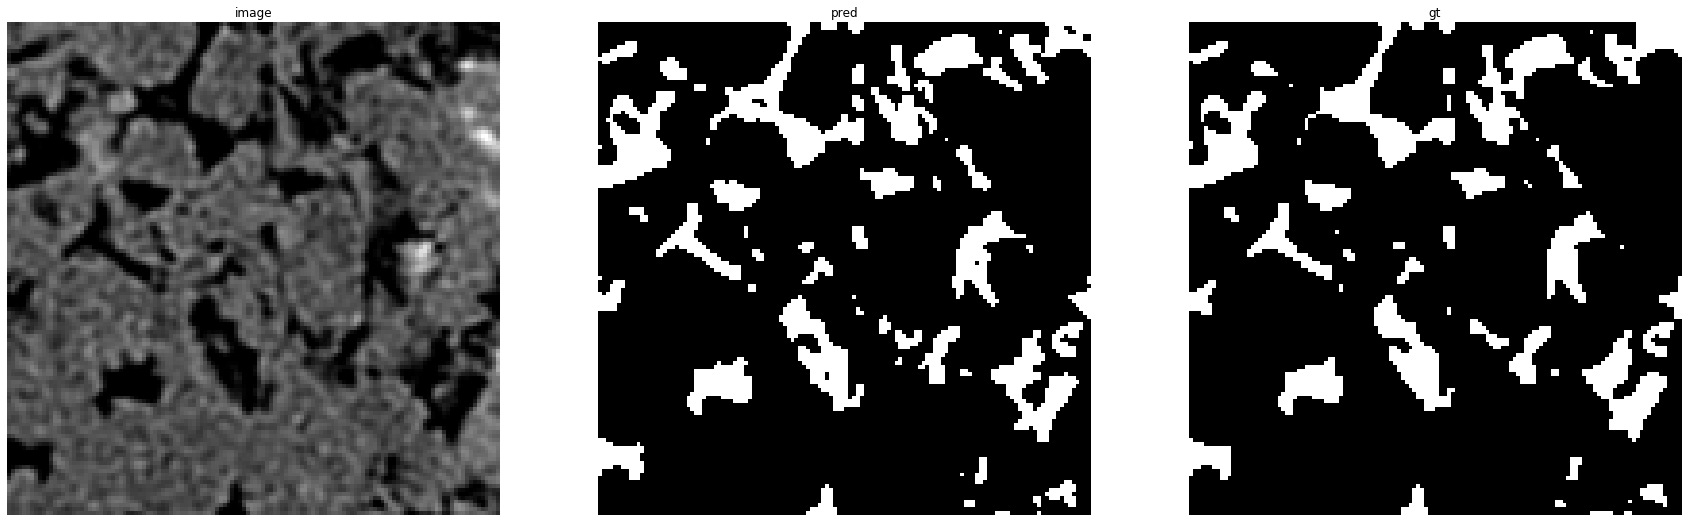

accuracy    : 0.97686767578125
precision   : 0.9124243503025988
recall      : 0.9506676557863502
f1          : 0.9311534968210718
pr_auc      : 0.9879357929906974
iou         : 0.871176070700204


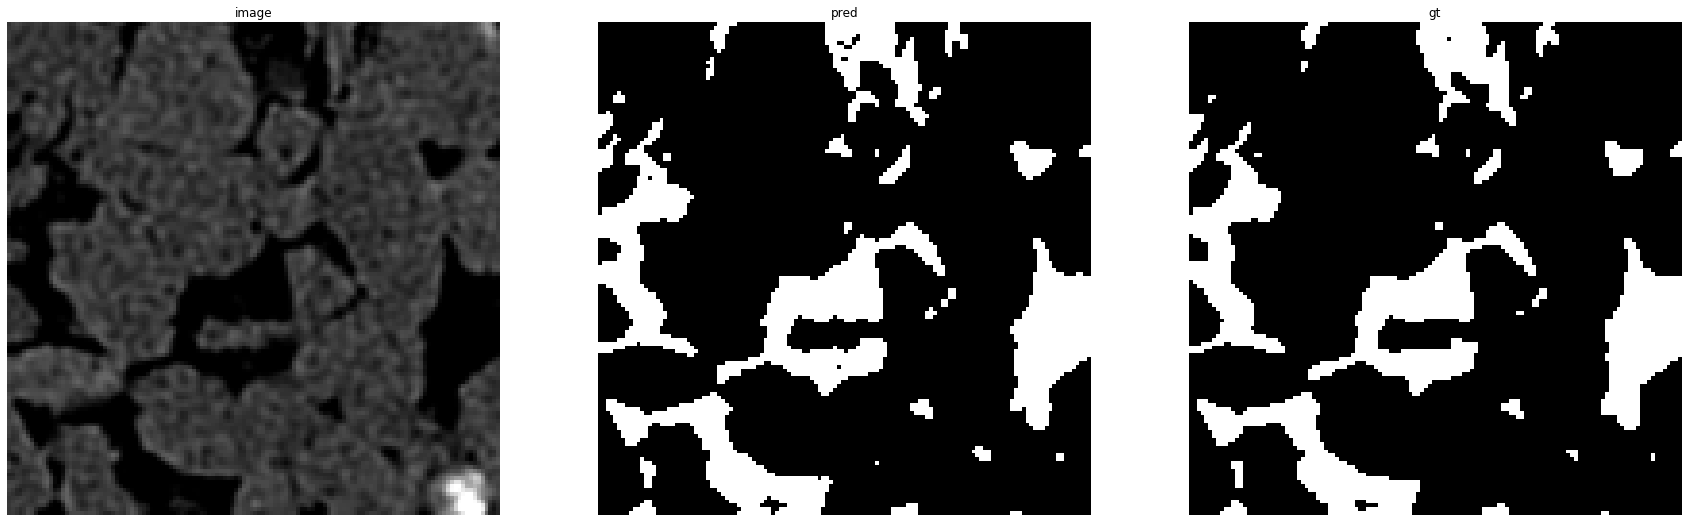

accuracy    : 0.9833984375
precision   : 0.9485967503692763
recall      : 0.9703838017527954
f1          : 0.9593665969524948
pr_auc      : 0.9949073569268592
iou         : 0.9219064025265575


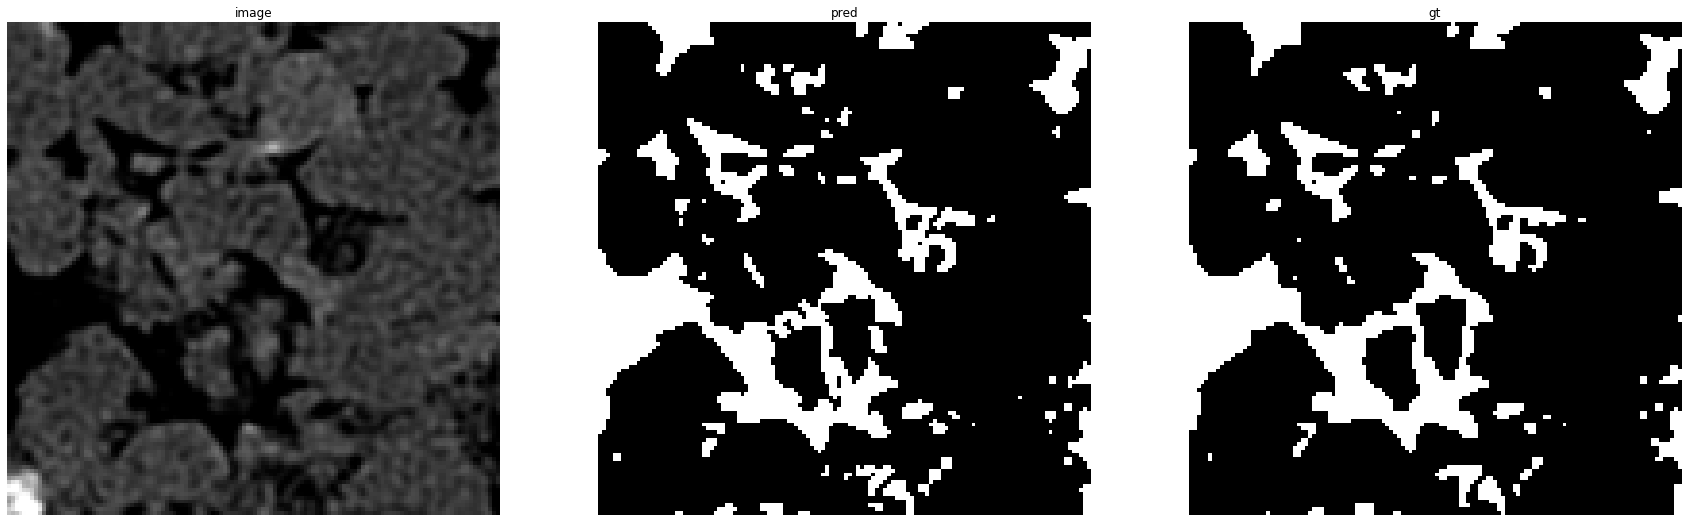

accuracy    : 0.9793701171875
precision   : 0.9285237140948563
recall      : 0.9573002754820936
f1          : 0.9426924381146151
pr_auc      : 0.9911315766042902
iou         : 0.8915971776779987


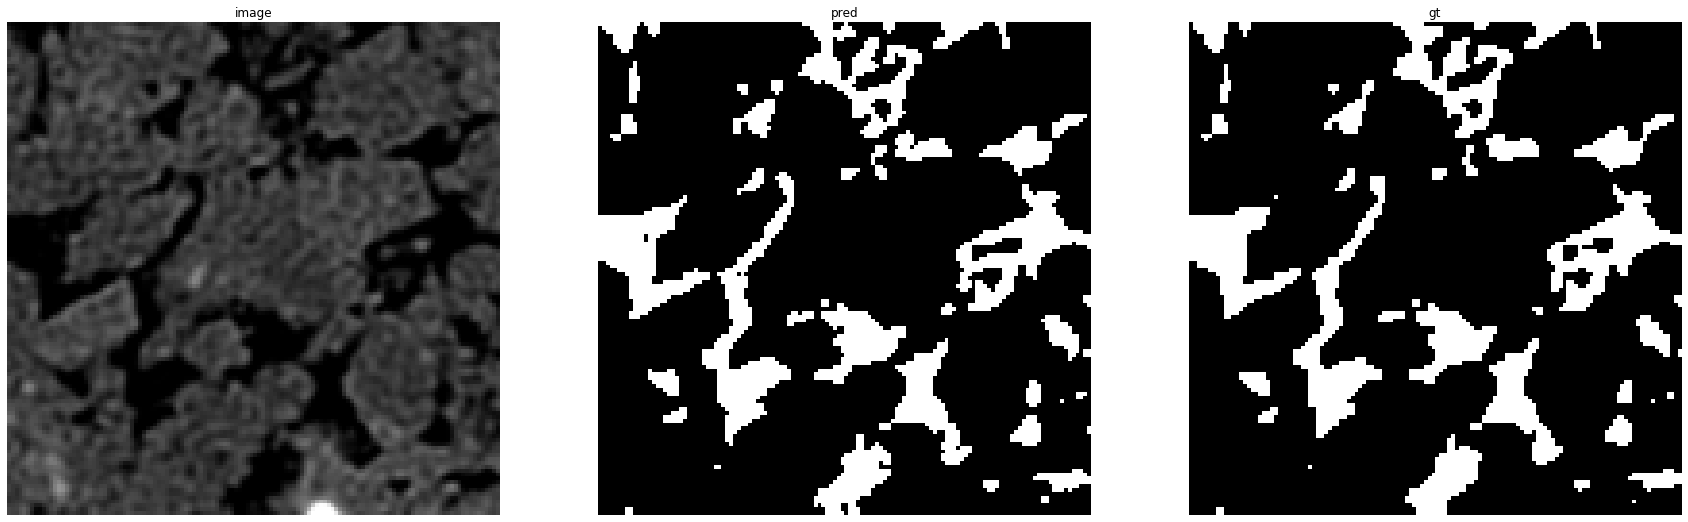

accuracy    : 0.98162841796875
precision   : 0.9318973709217612
recall      : 0.9715984147952443
f1          : 0.9513338722716248
pr_auc      : 0.9940071650394311
iou         : 0.9071847055195806


In [28]:
model.eval()

for stack_name, dataloader_test in dataloaders_test.items():
    cnt = to_plot
    
    stack_name = os.path.split(stack_name)[-1]
    dir_path = os.path.join(os.path.abspath('.'), 'samples', stack_name)
    if stack_name not in os.listdir(os.path.join('.', 'samples')):
        os.mkdir(dir_path)
    print(stack_name)
    for samples, masks in dataloader_test:

        preds = model(torch.from_numpy(samples).to(device)).cpu().data.numpy()

        for sample, mask, pred in list(zip(samples, masks, preds))[:cnt]:
            img_path = os.path.join('.', 'samples', stack_name, '{}.png'.format(cnt))
            plot_sample(sample[0], mask, pred, threshold, metrics, fig_path=None)
            cnt -= 1
            
        if cnt == 0:
            break

## Results

In [29]:
import pandas as pd

In [30]:
from visualization_utils import make_df

In [31]:
df = make_df(results, model_name=data_conf['conf_name'])
df

accuracy  precision    recall        f1    pr_auc       iou  \
0   0.996114   0.955105  0.991948  0.973178  0.998268  0.947757   
1   0.962341   0.761979  0.996835  0.863727  0.992333  0.760140   
2   0.984990   0.910776  0.918655  0.914699  0.978448  0.842806   
3   0.989803   0.942292  0.939675  0.940982  0.990418  0.888541   
4   0.987712   0.893408  0.947992  0.919891  0.984970  0.851665   
5   0.988019   0.822039  0.993461  0.899657  0.992913  0.817615   
6   0.990016   0.988450  0.937321  0.962206  0.995410  0.927165   
7   0.993538   0.989510  0.954351  0.971612  0.997274  0.944792   
8   0.989899   0.920789  0.989397  0.953861  0.996167  0.911792   
9   0.988146   0.937296  0.989896  0.962878  0.997303  0.928413   
10  0.983055   0.921086  0.966788  0.943384  0.991828  0.892835   

                 stack      model  
0            carb96558  carb96558  
1               carb71  carb96558  
2              carbRNF  carb96558  
3   SPE_carb10_58_box3  carb96558  
4             SoilAh-1  carb96558  
5              SoilB-2  carb96558  
6       TeTree_subset1  carb96558  
7       TiTree_subset2  carb96558  
8              Urna_22  carb96558  
9              Urna_30  carb96558  
10             Urna_34  carb96558

## Make prediction for particular stack

In [51]:
# stack_name = 'SPE_carb10_58_box3'
stack_name = 'TiTree_subset2'

In [52]:
stack = Stack.read_from_source('../../data/{}'.format(stack_name))

710it [00:01, 396.07it/s]
100%|██████████| 710/710 [00:06<00:00, 104.53it/s]


In [53]:
predicted_stack_1 = stack.apply(
    model, 
    model_config,
    patch_sizes=(128, 128, 1), 
    bs=32, num_workers=8, device=device,
    threshold=None)

25560it [00:00, 249139.94it/s]
25560it [02:02, 208.32it/s]
100%|██████████| 25560/25560 [00:07<00:00, 3392.42it/s]


In [54]:
predicted_stack_2 = stack.apply(
    model, 
    model_config,
    patch_sizes=(1, 128, 128), 
    bs=32, num_workers=8, device=device,
    threshold=None)

25560it [00:00, 117216.33it/s]
25560it [02:12, 193.00it/s]
100%|██████████| 25560/25560 [00:01<00:00, 14606.11it/s]


In [55]:
predicted_stack_3 = stack.apply(
    model, 
    model_config,
    patch_sizes=(128, 1, 128), 
    bs=32, num_workers=8, device=device,
    threshold=None)

25560it [00:00, 241496.67it/s]
25560it [02:13, 191.55it/s]
100%|██████████| 25560/25560 [00:01<00:00, 13730.05it/s]


In [56]:
iou(np.where(predicted_stack_1.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack_1.preds, 
    mode='stack',
    threshold=0.5)

0.9468094131697686

In [57]:
iou(np.where(predicted_stack_2.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack_2.preds, 
    mode='stack',
    threshold=0.5)

0.9460524229079726

In [58]:
iou(np.where(predicted_stack_3.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack_3.preds, 
    mode='stack',
    threshold=0.5)

0.9452328144640311

In [59]:
iou(np.where(stack.targets == 255, 0, 1).astype(np.uint8), 
    (predicted_stack_1.preds + predicted_stack_2.preds + predicted_stack_3.preds) / 3, 
    mode='stack',
    threshold=0.5)

0.9494787806802841

In [60]:
average_stack = Stack(predicted_stack_1.features, 
                      predicted_stack_1.targets, 
                      (predicted_stack_1.preds + predicted_stack_2.preds + predicted_stack_3.preds) / 3)

In [28]:
for ps, d in zip([(128, 128, 1), (128, 1, 128), (1, 128, 128)], ['z', 'y', 'x']):
    predicted_stack = stack.apply(
        model, 
        model_config=model_config,
        patch_sizes=ps, 
        bs=32, num_workers=8, device=device,
        threshold=None)
    predicted_stack.dump('../segmented_stacks/{}_{}'.format(stack_name, d), 
                         features=False, 
                         targets=True, 
                         preds=True)

8144it [00:00, 72365.38it/s]
8144it [00:44, 184.62it/s]
100%|██████████| 509/509 [00:03<00:00, 151.62it/s]
8144it [00:00, 200209.90it/s]
8144it [00:42, 190.34it/s]
100%|██████████| 509/509 [00:03<00:00, 136.05it/s]
8144it [00:00, 231673.55it/s]
8144it [00:43, 189.23it/s]
100%|██████████| 509/509 [00:03<00:00, 150.18it/s]


In [29]:
average_stack.dump('../segmented_stacks/{}_average'.format(stack_name), 
                   features=False, 
                   targets=True, 
                   preds=True)

100%|██████████| 509/509 [00:03<00:00, 150.61it/s]


In [31]:
for k, v in metrics.items():
    print('{:12}: {:.6f}'.format(k, 
                                 v(np.where(predicted_stack_1.targets == 255, 0, 1).astype(np.uint8), 
                                    predicted_stack_1.preds, 
                                    mode='stack')))

accuracy    : 0.989709
precision   : 0.947774
recall      : 0.941130
f1          : 0.944440
pr_auc      : 0.991501
iou         : 0.894730


## Validate dependence between metrics and distance to patch center

In [21]:
from visualization_utils import output_to_binary

In [25]:
import torch

In [36]:
import pandas as pd

In [62]:
df_agg = None

for i, (img, gt) in tqdm(enumerate(dataloaders_test['../../data/carbRNF'])):
    pred = model(torch.from_numpy(img)).cpu().data.numpy()
    binary = output_to_binary(pred, threshold=0.5, mode='batch')
    
    h, w = binary.shape[1:]
    x = np.arange(h).reshape(-1, 1)
    x = x.repeat(w, axis=1)
    y = np.arange(w).reshape(1, -1)
    y = y.repeat(h, axis=0)
    r = np.sqrt(np.square(x - (h - 1) / 2) + np.square(y - (w - 1) / 2))
    r = r.reshape(1, *r.shape).repeat(binary.shape[0], axis=0).flatten()
    tp = ((binary == 1) & (gt == 1)).astype(np.float32).flatten()
    fp = ((binary == 1) & (gt == 0)).astype(np.float32).flatten()
    fn = ((binary == 0) & (gt == 1)).astype(np.float32).flatten()
    
    df = pd.DataFrame(data={'r': r, 'tp': tp, 'fp': fp, 'fn': fn})
    df['r'] = df['r'].astype('int')
    df['count'] = 1
    if df_agg is None:
        df_agg = df.groupby(by='r').agg({'count': 'sum',
                                         'tp': 'sum',
                                         'fp': 'sum',
                                         'fn': 'sum'})
        
        portion = df.groupby(by='r').agg({'count': 'sum',
                                         'tp': 'sum',
                                         'fp': 'sum',
                                         'fn': 'sum'})
        df_agg = df_agg + portion
    
#     if i > 20:
#         break



0it [00:00, ?it/s]

1it [00:02,  2.39s/it]

2it [00:04,  2.30s/it]

3it [00:06,  2.14s/it]

4it [00:08,  2.04s/it]

5it [00:10,  2.03s/it]

6it [00:12,  2.03s/it]

7it [00:13,  1.95s/it]

8it [00:15,  1.91s/it]

9it [00:17,  1.93s/it]

10it [00:19,  1.87s/it]

11it [00:21,  1.84s/it]

12it [00:22,  1.81s/it]

13it [00:24,  1.80s/it]

14it [00:26,  1.78s/it]

15it [00:28,  1.77s/it]

16it [00:29,  1.77s/it]

17it [00:31,  1.77s/it]

18it [00:33,  1.76s/it]

19it [00:35,  1.76s/it]

20it [00:36,  1.75s/it]

21it [00:38,  1.76s/it]

22it [00:40,  1.76s/it]

23it [00:42,  1.76s/it]

24it [00:43,  1.77s/it]

25it [00:45,  1.80s/it]

26it [00:47,  1.78s/it]

27it [00:49,  1.77s/it]

28it [00:51,  1.77s/it]

29it [00:52,  1.77s/it]

30it [00:54,  1.76s/it]

31it [00:56,  1.76s/it]

32it [00:58,  1.76s/it]

33it [00:59,  1.76s/it]

34it [01:01,  1.76s/it]

35it [01:03,  1.75s/it]

36it [01:05,  1.76s/it]

37it [01:06,  1.76s/it]

38it [01:08,  1.76s/it]

39it [01:10,  1.76s/it]

40it [01:12,

In [63]:
df_agg

count      tp     fp     fn
r                              
0     256    20.0    4.0    0.0
1     512    44.0   12.0    0.0
2    1280   130.0   16.0    6.0
3    1280   124.0    4.0   14.0
4    1792   154.0    6.0    8.0
5    2048   156.0   30.0   20.0
6    2816   220.0   22.0   34.0
7    3328   330.0   24.0   38.0
8    3072   324.0   24.0   28.0
9    3840   336.0   22.0   38.0
10   4352   430.0   34.0   36.0
11   4096   456.0   62.0   42.0
12   5888   678.0   38.0   54.0
13   4864   540.0   46.0   54.0
14   6400   632.0   54.0   40.0
15   6144   544.0   56.0   50.0
16   6400   594.0   56.0   68.0
17   6912   700.0   72.0   60.0
18   6656   702.0   78.0   40.0
19   8960   912.0   68.0   82.0
20   8448   924.0   70.0   60.0
21   8448   942.0   74.0   90.0
22   8704   932.0   76.0  102.0
23   8960   912.0   88.0   86.0
24  11008  1068.0  110.0   88.0
25   9728   924.0   84.0   98.0
26  10496  1048.0  114.0  122.0
27  11520  1142.0  126.0  100.0
28  11008  1070.0  110.0   82.0
29  11776  1062.0  114.0   78.0
..    ...     ...    ...    ...
60  24320  2366.0  180.0  178.0
61  26368  2554.0  190.0  196.0
62  25344  2414.0  166.0  274.0
63  25600  2440.0  152.0  232.0
64  19712  1902.0  150.0  222.0
65  20224  2022.0  138.0  200.0
66  17408  1678.0  138.0  194.0
67  16128  1538.0  126.0  192.0
68  14592  1438.0  116.0  166.0
69  12288  1254.0  104.0  132.0
70  14592  1588.0  110.0  162.0
71  11008  1142.0   94.0  160.0
72  11520  1368.0   82.0  134.0
73  10240  1200.0   86.0  132.0
74   8960   994.0   54.0  112.0
75   9472  1044.0   66.0   96.0
76   7168   770.0   36.0   80.0
77   7936   846.0   48.0  102.0
78   6400   666.0   44.0   66.0
79   6400   680.0   40.0   86.0
80   5632   584.0   42.0   84.0
81   3840   364.0   30.0   46.0
82   5376   518.0   26.0   64.0
83   3072   346.0   10.0   52.0
84   4352   484.0   28.0   42.0
85   1792   186.0    6.0   16.0
86   2304   192.0   10.0   22.0
87   1536   140.0    4.0   16.0
88    768    84.0    2.0    4.0
89    768    76.0    6.0   14.0

[90 rows x 4 columns]

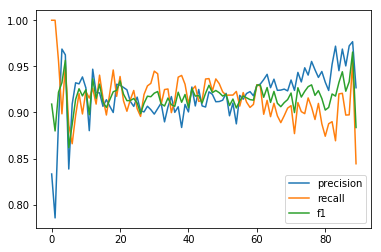

In [65]:
precision = df_agg['tp'] / (df_agg['tp'] + df_agg['fp'])
recall = df_agg['tp'] / (df_agg['tp'] + df_agg['fn'])
plt.plot(df_agg.index, precision, label='precision')
plt.plot(df_agg.index, recall, label='recall')
plt.plot(df_agg.index, 2 * precision * recall / (precision + recall), label='f1')
plt.legend(loc='best')
plt.show()

In [76]:
(2 * precision * recall / (precision + recall)).mean()

0.9169255

In [74]:
np.mean(results['test_metrics']['../../data/carb96558']['f1'])

0.9757604510306116

In [75]:
np.mean(results['test_metrics']['../../data/carbRNF']['f1'])

0.9172696807633565

In [77]:
np.mean(results['test_metrics']['../../data/carbRNF']['iou'])

0.8471886630965806

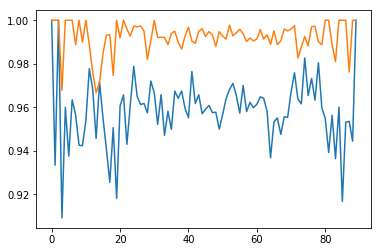

In [60]:
precision = df_agg['tp'] / (df_agg['tp'] + df_agg['fp'])
recall = df_agg['tp'] / (df_agg['tp'] + df_agg['fn'])
plt.plot(df_agg.index, precision)
plt.plot(df_agg.index, recall)
plt.show()

In [14]:
for x, y in dataloader_train:
    break

In [15]:
x.shape

(32, 1, 128, 128)

In [16]:
x[0].mean()

0.011243731

In [19]:
x[0].std()

0.79318494

In [22]:
a = data_train[0]['features']

In [24]:
a.shape

(128, 128, 1)

In [25]:
from stack_segmentation.io import image_process_basic

In [27]:
b = image_process_basic(a)

In [29]:
b.mean()

0.24210383

In [33]:
c = np.squeeze(b)[np.newaxis, np.newaxis, :, :]

In [36]:
import torch

In [55]:
p = model(torch.from_numpy(c).to(device))

In [56]:
d = p.cpu().data.numpy()[0]

In [57]:
from visualization_utils import output_to_binary

In [62]:
e = output_to_binary(d, threshold=0.5)

In [63]:
e.shape

(128, 128)

In [64]:
e

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

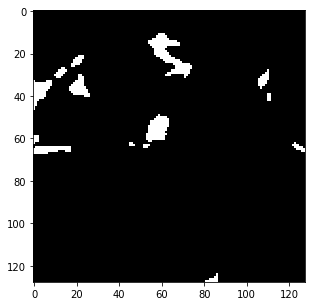

In [65]:
plt.figure(figsize=(5, 5))
plt.imshow(e, cmap='gray')
plt.show()